In [54]:
# imports
import astropy
import numpy as np
from astropy.io import fits, votable
from astropy.table import Table, Column
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import kdtree
from glob import glob
from statistics import median, mean
from scipy.stats.mstats import theilslopes
import gc

In [55]:
# This class emulates a tuple, but contains a useful payload
class Node(object):
    def __init__(self, ra, dec, data, idx = 0):
        self.coords = (ra, dec)
        self.data = data
        self.idx = idx

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, i):
        return self.coords[i]
    
    def getdata(self):
        return self.data
    
    def get_index(self):
        return self.idx

    def __repr__(self):
        return 'Node({}, {}, {})'.format(self.coords[0], self.coords[1], self.data)

In [56]:
# read in the tiles - old spread model cut
def processTile(filename, tree):
    t = Table.read(filename)
    #print('Original:', len(t))
    #idx = np.where(t['CHI_NULL'] > 10)[0]
    #temp = t[np.where(t['N'] > 8)]
    t_s = t[np.where(t['SPREAD_MODEL'] < 0.01)]
    #print('N filt:', len(temp))
    #t_s = temp2[np.where(temp2['CHI_NULL'] > 30)]
    #t_s = t[idx]
    #print('Chi_null filt:', len(t_s))
    tiles.append(t_s)
    # add columns
    print('Tile number:', len(tiles))

In [57]:
# Read in the tiles - new WAVG spread model cut
def processNewTile(filename, tree, array):
    t = Table.read(filename)
    #print('Original:', len(t))
    #idx = np.where(t['CHI_NULL'] > 10)[0]
    #temp = t[np.where(t['N'] > 8)]
    t_s = t[np.where(t['SPREAD_MODEL_WAVG'] < 0.01)]
    #print('N filt:', len(temp))
    #t_s = temp2[np.where(temp2['CHI_NULL'] > 30)]
    #t_s = t[idx]
    #print('Chi_null filt:', len(t_s))
    array.append(t_s)
    # add columns
    print('Tile number:', len(array))

In [58]:
def kdTreeGaia(table):
    """ Calculates the KDTree from Gaia data. """
    nodes = []
    for i in range(len(table)):
        ra_deg = table['ra'][i]
        dec_deg = table['dec'][i]
        curr = Node(ra_deg, dec_deg, table['designation'][i])
        nodes.append(curr)
    tree = kdtree.create(nodes)
    return tree

In [61]:
# g for gaia - gaia table
g = Table.read('gaia/Gaia-Z029.csv')#('Gaia-DR2-short.csv')#Table.read('Gaia-DR2-0135-0416-PM.csv')

In [62]:
tree = kdTreeGaia(g)

In [63]:
# Read in tiles - all from zone029
tiles = []
path = '/Users/Suyog/Documents/GitHub/DES-Proper-Motion/zone029/'
filenames = glob(path+'*proper.fits')
list.sort(filenames)
for name in filenames:
    processTile(name, tree)

Tile number: 1
Tile number: 2
Tile number: 3
Tile number: 4
Tile number: 5
Tile number: 6
Tile number: 7
Tile number: 8
Tile number: 9
Tile number: 10
Tile number: 11
Tile number: 12
Tile number: 13
Tile number: 14
Tile number: 15
Tile number: 16
Tile number: 17
Tile number: 18
Tile number: 19
Tile number: 20
Tile number: 21
Tile number: 22
Tile number: 23
Tile number: 24
Tile number: 25
Tile number: 26
Tile number: 27
Tile number: 28
Tile number: 29
Tile number: 30
Tile number: 31
Tile number: 32
Tile number: 33
Tile number: 34
Tile number: 35
Tile number: 36
Tile number: 37
Tile number: 38
Tile number: 39
Tile number: 40
Tile number: 41
Tile number: 42
Tile number: 43
Tile number: 44
Tile number: 45
Tile number: 46
Tile number: 47
Tile number: 48


In [64]:
# Read in tiles - all from zone029
tiles_n = []
filenames2 = glob(path+'*proper_n.fits')
list.sort(filenames2)
for name in filenames2:
    processNewTile(name, tree, tiles_n)

Tile number: 1
Tile number: 2


/Users/Suyog/anaconda/lib/python3.6/site-packages/astropy/table/column.py:954: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


Tile number: 3
Tile number: 4
Tile number: 5
Tile number: 6
Tile number: 7
Tile number: 8
Tile number: 9
Tile number: 10
Tile number: 11
Tile number: 12
Tile number: 13
Tile number: 14
Tile number: 15
Tile number: 16
Tile number: 17
Tile number: 18
Tile number: 19
Tile number: 20
Tile number: 21
Tile number: 22
Tile number: 23
Tile number: 24
Tile number: 25
Tile number: 26
Tile number: 27
Tile number: 28
Tile number: 29
Tile number: 30
Tile number: 31
Tile number: 32
Tile number: 33
Tile number: 34
Tile number: 35
Tile number: 36
Tile number: 37
Tile number: 38
Tile number: 39
Tile number: 40
Tile number: 41
Tile number: 42
Tile number: 43
Tile number: 44
Tile number: 45
Tile number: 46
Tile number: 47
Tile number: 48


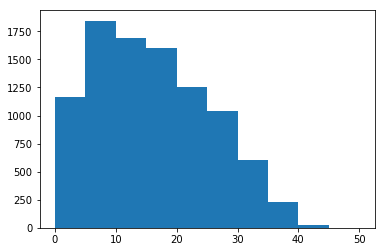

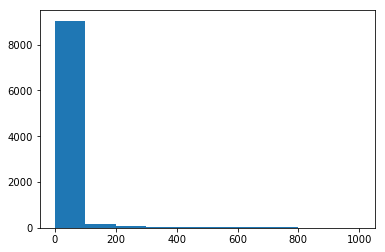

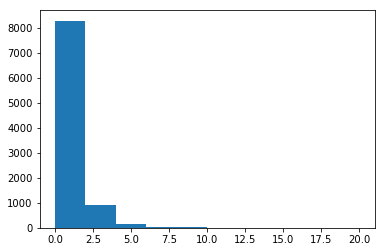

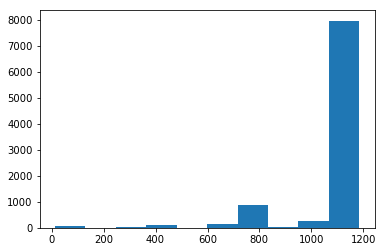

In [380]:
plt.hist(tiles_n[0]['N'], range=(0, 50))
plt.show()
plt.hist(tiles_n[0]['CHI_NULL'], range=(0, 1000))
plt.show()
plt.hist(tiles_n[0]['CHI2_RED'], range=(0, 20))
plt.show()
plt.hist(tiles_n[0]['DELTA_T'])
plt.show()

In [65]:
def getGaiaMatches(tile, tree):
    """ Matches the tile data to Gaia data using the Gaia KDTree provided """
    count = 0
    match = []
    col = Table.Column(data=[''*len(tile)], name = 'GAIA_MATCH', dtype='U50')
    tile['GAIA_MATCH'] = col
    col3 = Table.Column(data=[0]*len(tile), name = 'GAIA_MATCH_DIST', dtype='f8')
    tile['GAIA_MATCH_DIST'] = col3
    for i in range(len(tile)):
        tgt = Node(tile[i]['RA'], tile[i]['DEC'], '')
        tup = tree.search_nn(tgt)
        # 25 arcseconds - 0.00005
        # 10 arcseconds - 0.000008
        # 5 arcseconds - 0.0000019
        # 1 arcsecond - 7.7 x 10^-8
        #print(tup)
        if tup[1] < (7.7*10**-8):
            #print(tile['RA', 'DEC'][i])
            #print(tup)
            count +=1
            match.append(i)
            tile['GAIA_MATCH'][i] = tup[0].data.getdata()
            tile['GAIA_MATCH_DIST'][i] = tup[1]
            #sim_num.append(tup[0].data.get_index())
    print('Matches:', count)
    return match

In [11]:
# running out of index names, so we will use 'cool' as the index for gaia matches
cool = getGaiaMatches(tiles[0], tree)
print('Tile length:', len(tiles[0]))
print('Gaia results:', len(g))

Matches: 1242
Tile length: 9524
Gaia results: 72666


In [381]:
# new matches
cool2 = getGaiaMatches(tiles_n[0], tree)
print('Tile length:', len(tiles_n[0]))
print('Gaia results:', len(g))

Matches: 1241
Tile length: 9465
Gaia results: 72666


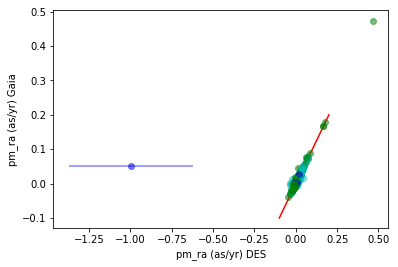

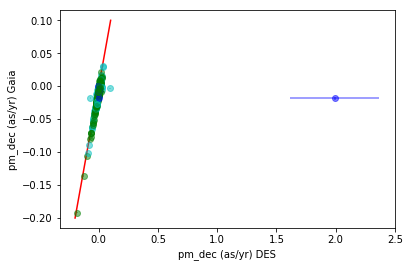

mu RA error (Gaia): median: 0.000850794492569 mean: 0.00109206360383
mu Dec error (Gaia): median: 0.000472471209249 mean: 0.000740344910398
mu RA difference: median: 0.00517092596721 mean: 0.00614460225954
mu Dec difference: median: -0.00626803353825 mean: -0.00814871076477


In [389]:
# Note this is out of order. ComparePM is not yet defined
x = comparePM(tiles_n[0], cool2, g)

In [114]:
tiles_n[0][cool2][np.where(tiles_n[0][cool2]['VEL'] > 1.5)]

<Table length=1>
MATCH_ID   COADD_ID  ...          GAIA_MATCH           GAIA_MATCH_DIST 
float64    float64   ...            str50                  float64     
-------- ----------- ... ---------------------------- -----------------
 23997.0 233009741.0 ... Gaia DR2 2480846025829722368 4.40151002686e-09

In [181]:
fin[np.where(fin['MATCH_ID'] == 23997)]

<Table length=5>
    RA       DEC      ERRAWIN_WORLD   ...  COLOR      NEW_RA       NEW_DEC    
 float64   float64       float64      ... float64    float64       float64    
--------- --------- ----------------- ... ------- ------------- --------------
 24.13026 -4.070308             1e+20 ...    0.61 24.1302602789 -4.07030785257
24.130445 -4.070591 6.55836993246e-06 ...    0.61 24.1303427476 -4.07039297774
24.130308 -4.070329 1.63573004102e-05 ...    0.61 24.1302735447 -4.07037207739
24.130356 -4.070376 1.23361996884e-05 ...    0.61 24.1303225553  -4.0703620065
24.130313 -4.070352 2.08463006857e-06 ...    0.61 24.1303201309 -4.07036026965

In [13]:
fast = tiles_n[0][cool2][np.where(tiles_n[0][cool2]['VEL'] > 0.05)]

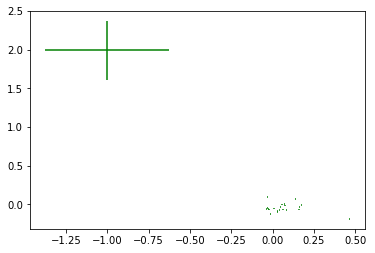

In [118]:
# PMs
for i,iden in enumerate(fast):
    plt.errorbar(fast['MU_RA'][i], fast['MU_DEC'][i], xerr = np.sqrt(fast['MU_RA_ERR'][i]), yerr = np.sqrt(fast['MU_DEC_ERR'][i]), fmt = 'g')
plt.show()

In [66]:
zones = Table.read('zones.fits')

In [100]:
# Dec min = -7.4873059999999994
# Dec max = -2.4736020000000001
# RA min = 23.446251
# RA max = 29.039911999999998
min(zones[np.where(zones['ZONE'] == 29)]['RACMIN'])

23.446251

In [24]:
fin = Table.read('DES0135-0416_final.fits')

In [16]:
temp = fin[np.where(fin['MATCH_ID'] == fast[2]['MATCH_ID'])]
temp[np.where(temp['VERSION'] == 'COADD')]

<Table length=1>
    RA       DEC    ERRAWIN_WORLD ...  COLOR      NEW_RA       NEW_DEC    
 float64   float64     float64    ... float64    float64       float64    
--------- --------- ------------- ... ------- ------------- --------------
23.741647 -4.034075         1e+20 ...    0.61 23.7416467486 -4.03407461161

In [80]:
def colorPoint(chi2, N, dt):
    ''' Colors points in scatter plot by filter'''
    if N < 9:
        return 'bo'
    elif dt < 200:
        return 'ro'
    elif chi2 > 3:
        return 'co'
    else:
        return 'go'

In [61]:
#g[np.where(g['pmra'].mask == True)]

In [385]:
def comparePM(tile, match, gaia):
    ''' Compares proper motion for matched objects in tile to the Gaia proper motions
    args: tile = table of DES tile; match = indices for gaia matches in tile; gaia = gaia table for respective tile/zone region'''
    ra_des = []
    ra_des_err = []
    dec_des = []
    dec_des_err = []
    ra_gaia = []
    ra_gaia_err = []
    dec_gaia = []
    dec_gaia_err = []
    diff_ra = []
    diff_dec = []
    chi2_red = []
    n = []
    dt = []
    for iden in tile[match]:
        ident = iden['GAIA_MATCH']
        #print(gaia['pmra'][np.where(gaia['designation'] == ident)].data.data[0])
        pmra = (gaia['pmra'][np.where(gaia['designation'] == ident)])
        if (len(pmra == 1)) and (pmra.mask == False):
            ra_gaia.append(pmra.data.data[0]/1000)
            dec_gaia.append((gaia['pmdec'][np.where(gaia['designation'] == ident)]).data.data[0]/1000)
            ra_gaia_err.append((gaia['pmra_error'][np.where(gaia['designation'] == ident)]).data.data[0]/1000)
            dec_gaia_err.append((gaia['pmdec_error'][np.where(gaia['designation'] == ident)]).data.data[0]/1000)
            ra_des.append(iden['MU_RA'])
            ra_des_err.append(np.sqrt(iden['MU_RA_ERR']))
            dec_des.append(iden['MU_DEC'])  
            dec_des_err.append(np.sqrt(iden['MU_DEC_ERR']))
            chi2_red.append(iden['CHI2_RED'])
            n.append(iden['N'])
            dt.append(iden['DELTA_T'])
    # make plots
    for i in range(len(ra_des)):
        plt.errorbar(ra_des[i], ra_gaia[i], fmt = colorPoint(chi2_red[i], n[i], dt[i]) ,yerr = ra_gaia_err[i],xerr = ra_des_err[i], label = 'pmra', alpha=0.5)
    plt.plot([-0.1, 0.2], [-0.1, 0.2], color = 'r', label = 'y=x')
    plt.xlabel('pm_ra (as/yr) DES')
    plt.ylabel('pm_ra (as/yr) Gaia')
    plt.show()
    #
    for i in range(len(dec_des)):
        plt.errorbar(dec_des[i], dec_gaia[i], fmt = colorPoint(chi2_red[i], n[i], dt[i]), yerr = dec_gaia_err[i],xerr = dec_des_err[i], label = 'pmdec', alpha = 0.5)
    plt.plot([-0.2, 0.1], [-0.2, 0.1], color = 'r', label = 'y=x')
    plt.xlabel('pm_dec (as/yr) DES')
    plt.ylabel('pm_dec (as/yr) Gaia')
    plt.show()
    # differences
    diff_ra = np.array(ra_gaia) - np.array(ra_des)
    diff_dec = np.array(dec_gaia) - np.array(dec_des)
    # median stats
    print('mu RA error (Gaia): median:', median(ra_gaia_err), 'mean:', mean(ra_gaia_err))
    print('mu Dec error (Gaia): median:', median(dec_gaia_err), 'mean:', mean(dec_gaia_err))
    print('mu RA difference: median:', median(diff_ra), 'mean:', mean(diff_ra))
    print('mu Dec difference: median:', median(diff_dec), 'mean:', mean(diff_dec))
    # make and return dict
    lists = {'des_ra': ra_des, 'des_dec': dec_des,'gaia_ra':ra_gaia, 'gaia_dec': dec_gaia, 'gaia_ra_err':ra_gaia_err, 'gaia_dec_err': dec_gaia_err,'diff_ra':diff_ra, 'diff_dec':diff_dec, 'des_ra_err':ra_des_err, 'des_dec_err': dec_des_err}
    return lists

In [395]:
dicts = []

In [394]:
dicts.append(comparePM(tiles_n[0], cool, g))

IndexError: index 9519 is out of bounds for axis 1 with size 9465

/Users/Suyog/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


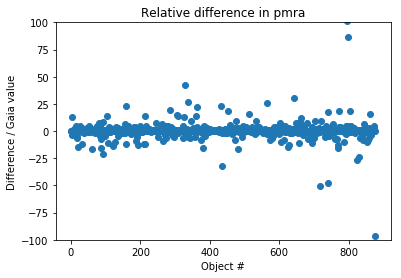

In [42]:

plt.title('Relative difference in pmra')
plt.scatter(range(len(dicts[0]['gaia_ra'])), (dicts[0]['diff_ra'])/np.array(dicts[0]['gaia_ra']))
plt.xlabel('Object #')
plt.ylabel('Difference / Gaia value')
plt.ylim(-100, 100)
plt.show()

/Users/Suyog/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


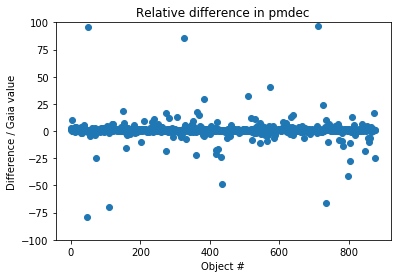

In [43]:

plt.title('Relative difference in pmdec')
plt.scatter(range(len(dicts[0]['gaia_dec'])), (dicts[0]['diff_dec'])/np.array(dicts[0]['gaia_dec']))
plt.xlabel('Object #')
plt.ylabel('Difference / Gaia value')
plt.ylim(-100, 100)
plt.show()

## Get match indixes for all tiles

In [399]:
indices = []
matched = []
matched1 = []
def getIndices(tiles, tree):
    for tile in tiles:
        # new matches
        matches = getGaiaMatches(tile, tree)
        indices.append(matches)
        curr = tile[matches]
        matched1.append(curr)
        fast = curr[np.where(curr['VEL'] > 0.05)]
        for i,iden in enumerate(fast):
            plt.errorbar(fast['MU_RA'][i], fast['MU_DEC'][i], xerr = np.sqrt(fast['MU_RA_ERR'][i]), yerr = np.sqrt(fast['MU_DEC_ERR'][i]), fmt = 'g')
            plt.xlabel('MU_RA (as/yr)')
            plt.ylabel('MU_DEC (as/yr)')
        plt.show()

Matches: 1241


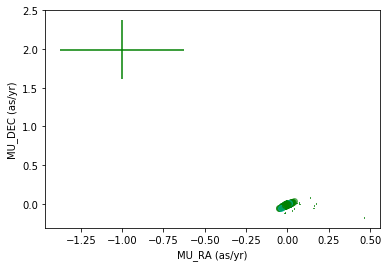

Matches: 1185


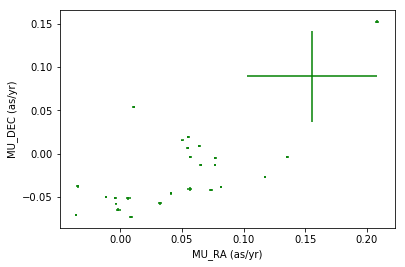

Matches: 1251


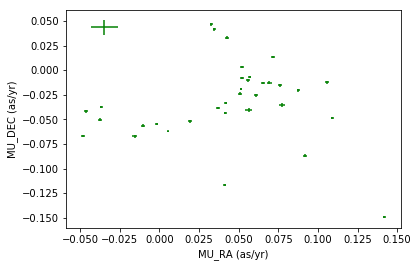

Matches: 1222


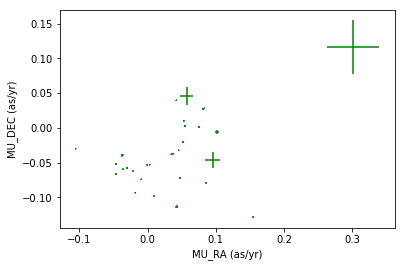

Matches: 1147


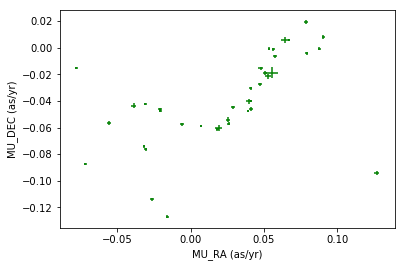

Matches: 1175


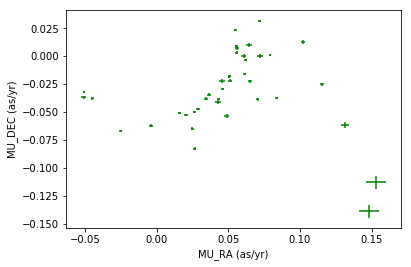

Matches: 1217


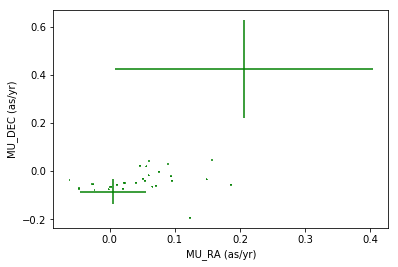

Matches: 1189


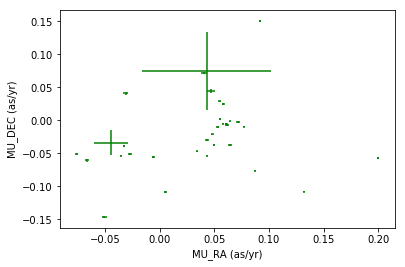

Matches: 1237


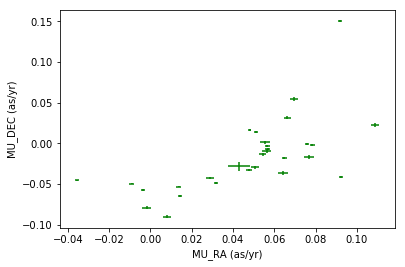

Matches: 1229


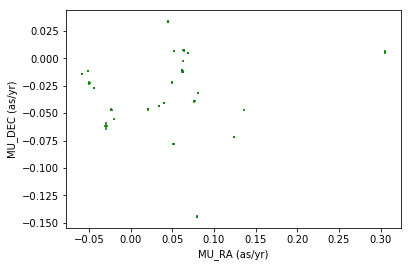

Matches: 1204


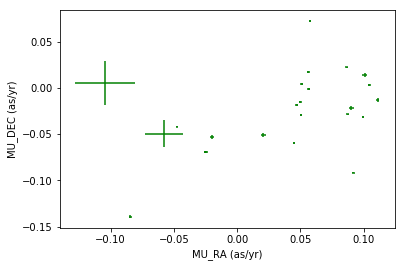

Matches: 1155


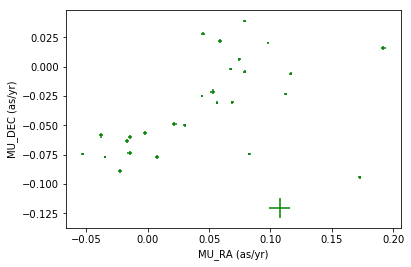

Matches: 1221


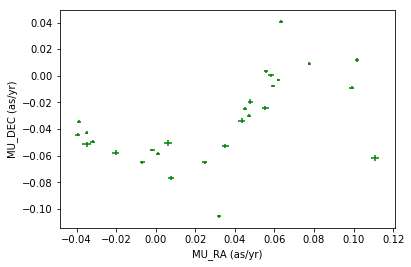

Matches: 1242


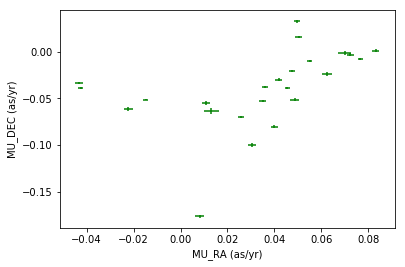

Matches: 1143


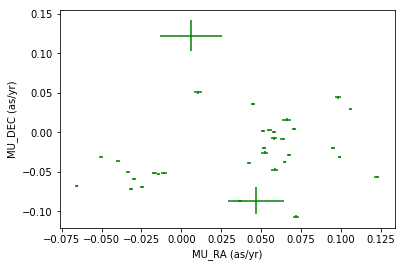

Matches: 1186


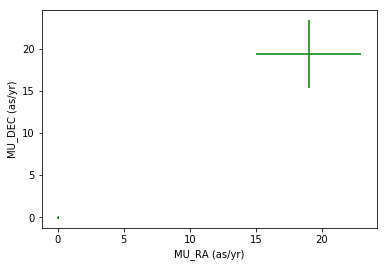

Matches: 1239


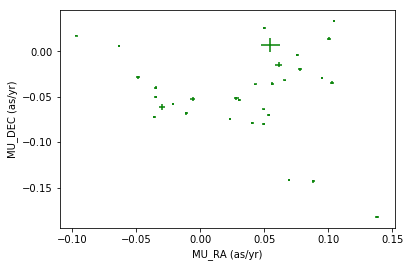

Matches: 1219


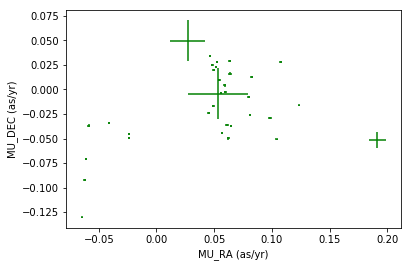

Matches: 1197


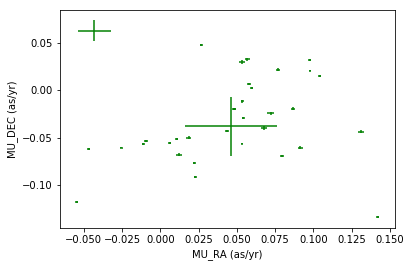

Matches: 1153


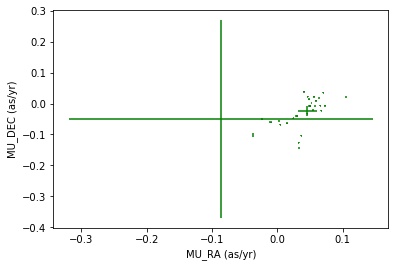

Matches: 1231


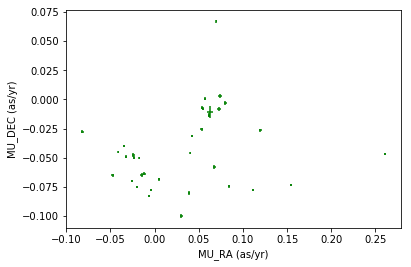

Matches: 1169


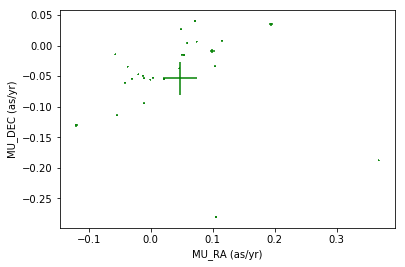

Matches: 1284


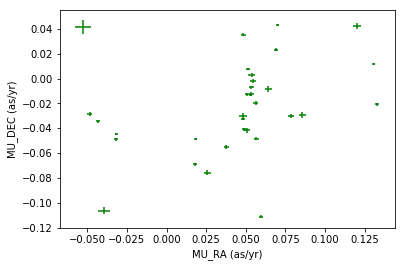

Matches: 1245


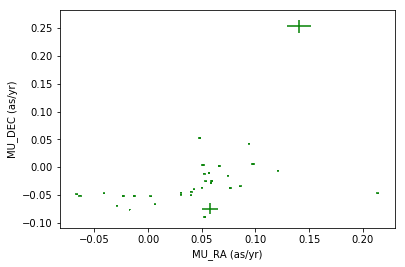

Matches: 1183


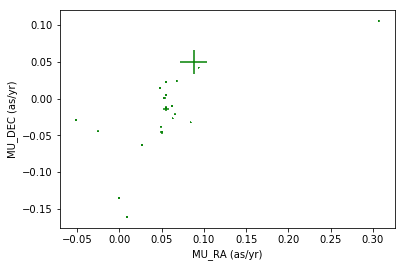

Matches: 1237


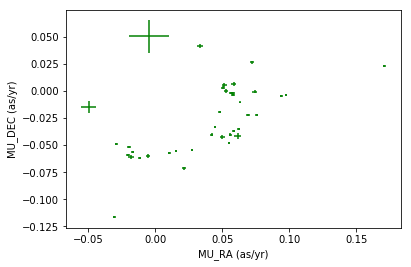

Matches: 1200


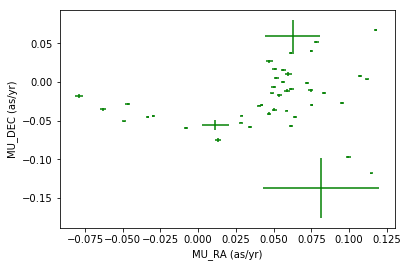

Matches: 1253


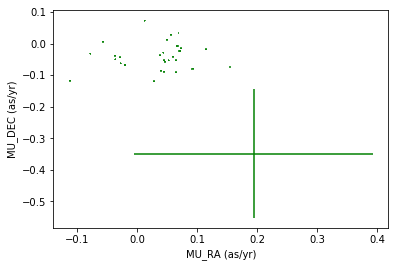

Matches: 1166


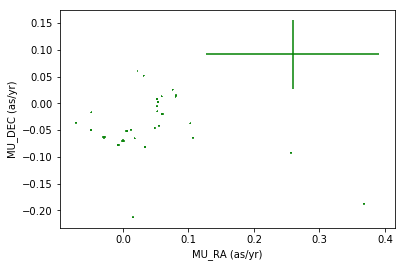

Matches: 1214


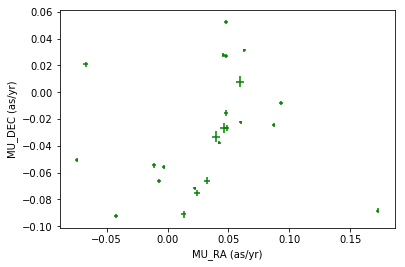

Matches: 1193


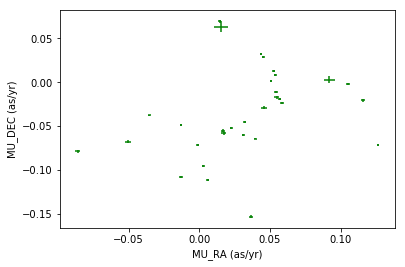

Matches: 1184


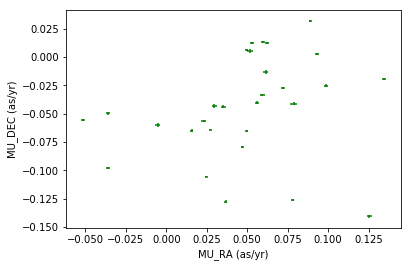

Matches: 1176


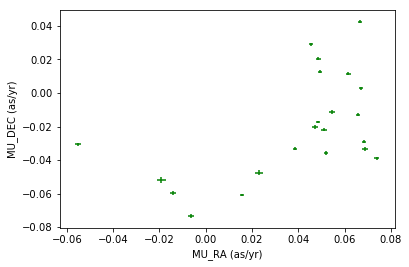

Matches: 1170


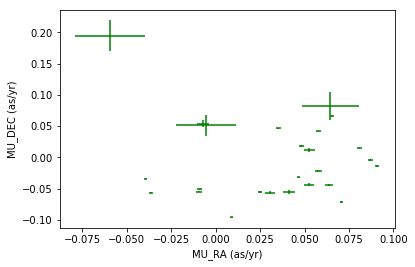

Matches: 1212


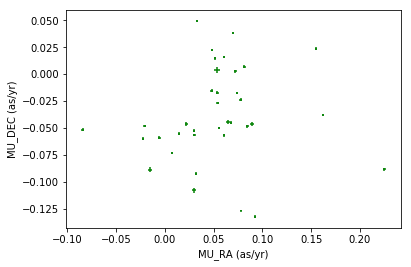

Matches: 1201


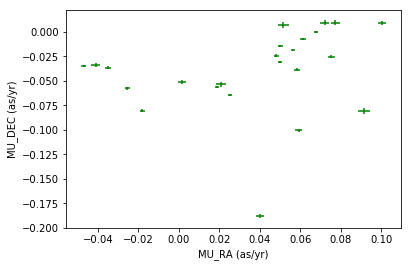

Matches: 1225


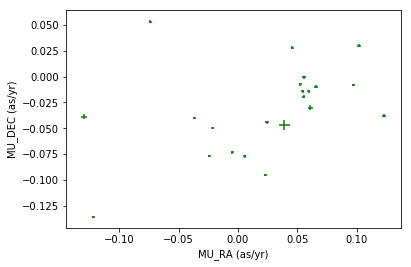

Matches: 1201


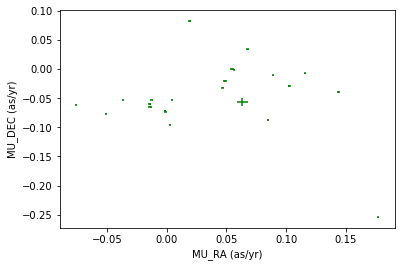

Matches: 1153


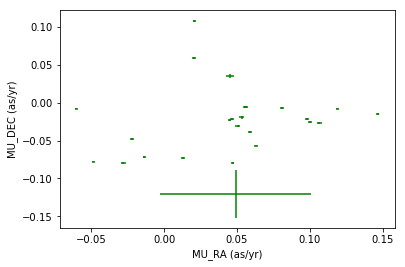

Matches: 1178


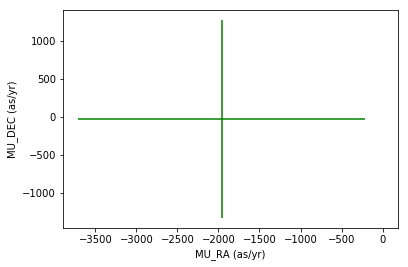

Matches: 1219


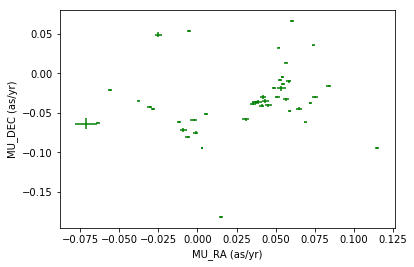

Matches: 1242


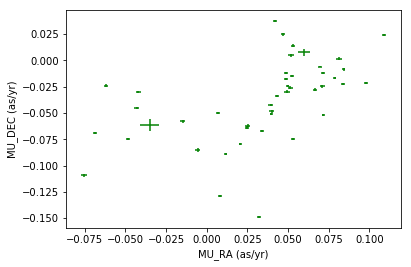

Matches: 1245


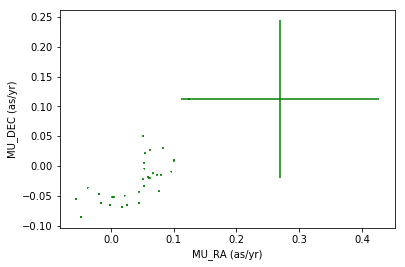

Matches: 1214


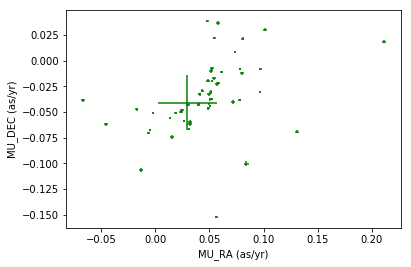

Matches: 1176


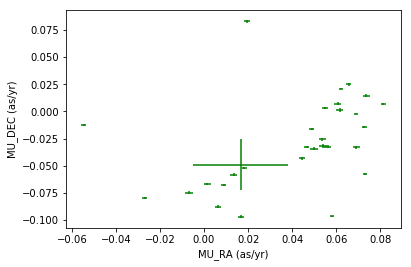

Matches: 1213


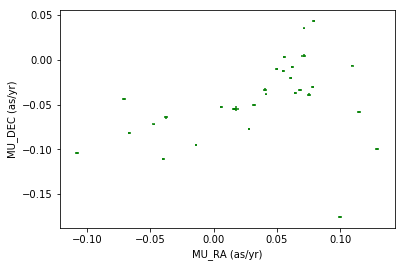

Matches: 1203


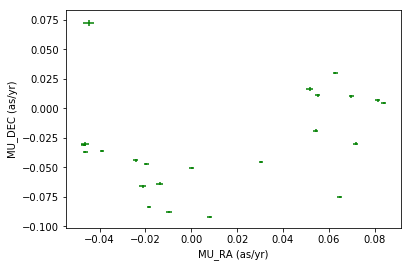

Matches: 1207


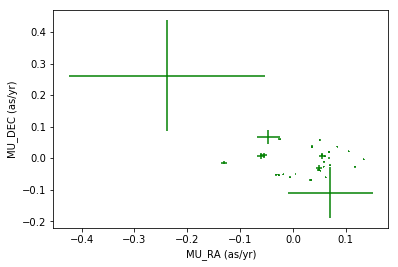

In [400]:
getIndices(tiles_n, tree)

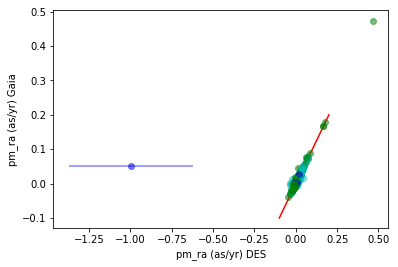

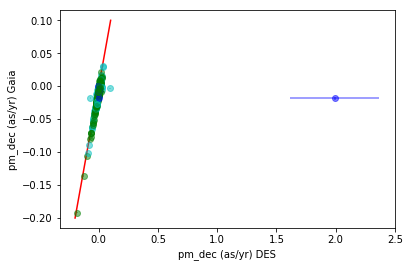

mu RA error (Gaia): median: 0.000850794492569 mean: 0.00109206360383
mu Dec error (Gaia): median: 0.000472471209249 mean: 0.000740344910398
mu RA difference: median: 0.00517092596721 mean: 0.00614460225954
mu Dec difference: median: -0.00626803353825 mean: -0.00814871076477


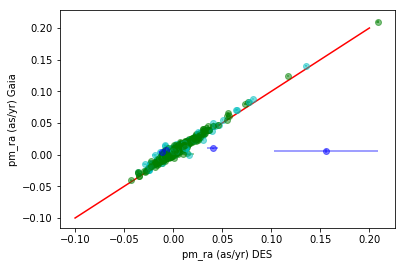

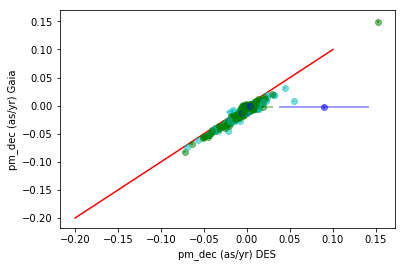

mu RA error (Gaia): median: 0.000812491090278 mean: 0.00107235177692
mu Dec error (Gaia): median: 0.000483377642437 mean: 0.000783875002228
mu RA difference: median: 0.00509729616351 mean: 0.00492103659279
mu Dec difference: median: -0.00641264401674 mean: -0.0065996969407


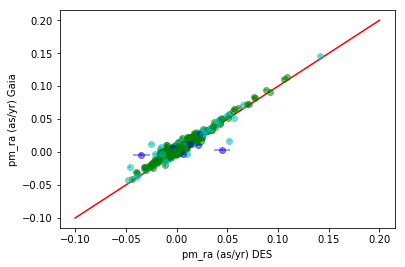

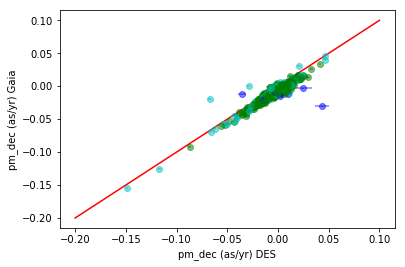

mu RA error (Gaia): median: 0.00082724838361 mean: 0.001076251075
mu Dec error (Gaia): median: 0.000475117664115 mean: 0.000751875447313
mu RA difference: median: 0.00529211973375 mean: 0.00517375569554
mu Dec difference: median: -0.00540976213589 mean: -0.00538193355075


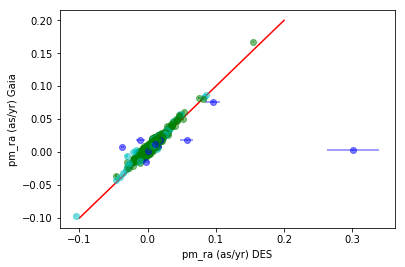

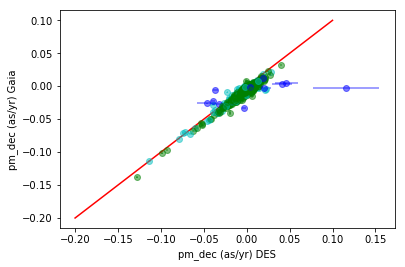

mu RA error (Gaia): median: 0.000875036879456 mean: 0.00113757295486
mu Dec error (Gaia): median: 0.000463524722484 mean: 0.000810712135222
mu RA difference: median: 0.00521299955093 mean: 0.00475673637541
mu Dec difference: median: -0.00566213113965 mean: -0.00575967233362


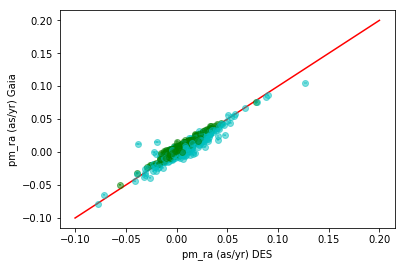

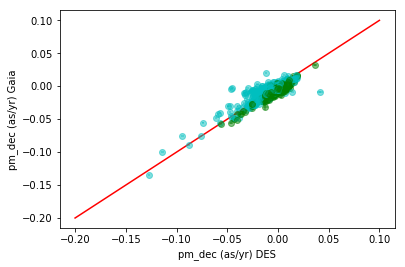

mu RA error (Gaia): median: 0.000764597654387 mean: 0.00101710361389
mu Dec error (Gaia): median: 0.000502413556349 mean: 0.000820422613773
mu RA difference: median: 0.00187479923162 mean: 0.00130287434588
mu Dec difference: median: -0.0040232627518 mean: -0.00277582468725


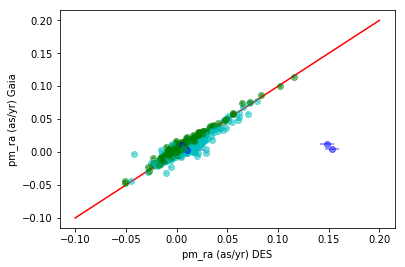

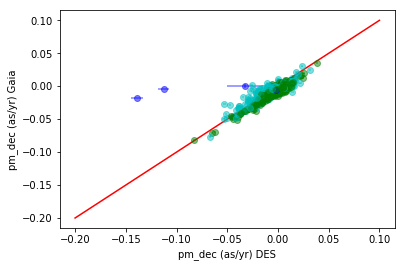

mu RA error (Gaia): median: 0.000822591652164 mean: 0.00114657263964
mu Dec error (Gaia): median: 0.000474843227109 mean: 0.000818543765707
mu RA difference: median: 0.00259255140704 mean: 0.0016531708897
mu Dec difference: median: -0.00505485174119 mean: -0.00407264867998


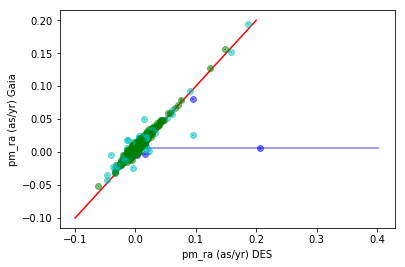

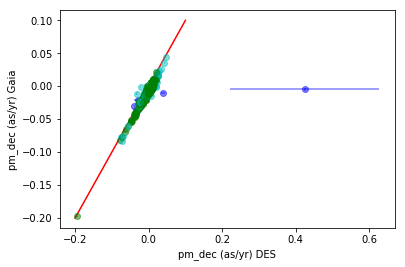

mu RA error (Gaia): median: 0.000916113177016 mean: 0.00114294084665
mu Dec error (Gaia): median: 0.000497317548854 mean: 0.000804443133492
mu RA difference: median: 0.00531391976615 mean: 0.00515173793236
mu Dec difference: median: -0.00559098928415 mean: -0.00603902060608


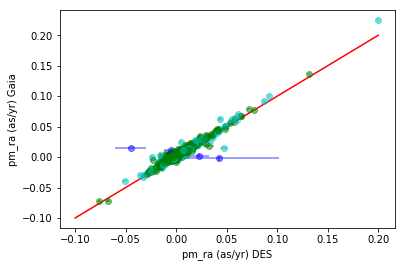

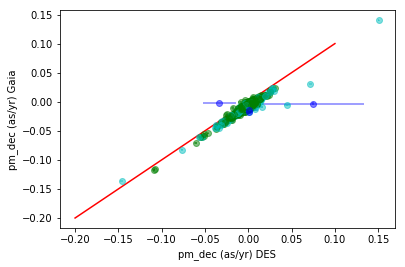

mu RA error (Gaia): median: 0.000832464037468 mean: 0.00108945301021
mu Dec error (Gaia): median: 0.000478527271939 mean: 0.000785057778181
mu RA difference: median: 0.00390908339073 mean: 0.00384141745978
mu Dec difference: median: -0.0061602036809 mean: -0.00641098757574


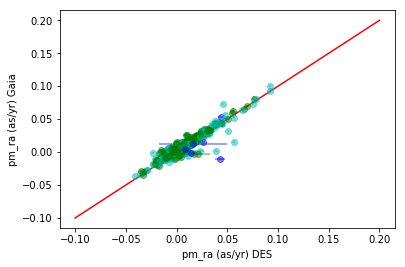

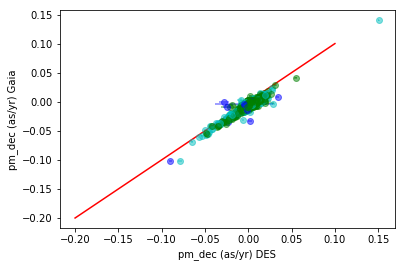

mu RA error (Gaia): median: 0.000778670067542 mean: 0.00106118511608
mu Dec error (Gaia): median: 0.000462857282074 mean: 0.000809364960943
mu RA difference: median: 0.00339598700408 mean: 0.00309558684242
mu Dec difference: median: -0.00556365633189 mean: -0.00567185711504


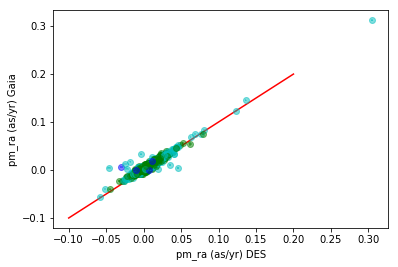

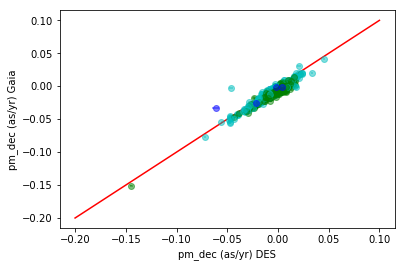

mu RA error (Gaia): median: 0.000891832759219 mean: 0.00115823072161
mu Dec error (Gaia): median: 0.000463950794547 mean: 0.000784677063177
mu RA difference: median: 0.00350602634243 mean: 0.00343365375335
mu Dec difference: median: -0.00460129869109 mean: -0.00450331540233


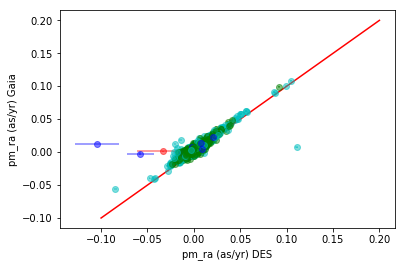

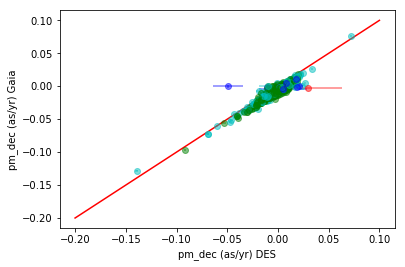

mu RA error (Gaia): median: 0.000837434306154 mean: 0.00108878324448
mu Dec error (Gaia): median: 0.000512920619614 mean: 0.000825029254336
mu RA difference: median: 0.00496340701339 mean: 0.00502929699239
mu Dec difference: median: -0.00512381881008 mean: -0.00507661873328


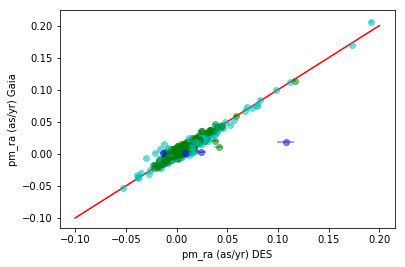

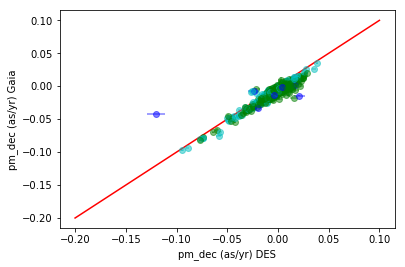

mu RA error (Gaia): median: 0.000863622487226 mean: 0.00110409767652
mu Dec error (Gaia): median: 0.000505867611525 mean: 0.000764352350161
mu RA difference: median: 0.00162519118799 mean: 0.00151094938999
mu Dec difference: median: -0.00521755784515 mean: -0.00523663831239


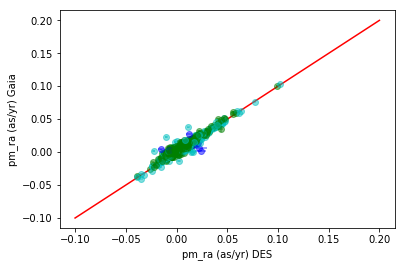

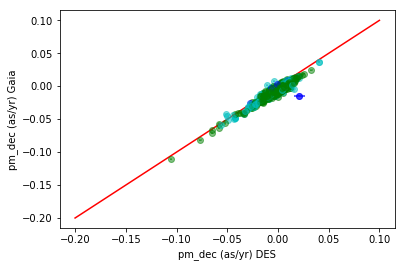

mu RA error (Gaia): median: 0.000929586701665 mean: 0.00118572523861
mu Dec error (Gaia): median: 0.000534032982238 mean: 0.000840176383872
mu RA difference: median: 0.00270723117922 mean: 0.00260755843231
mu Dec difference: median: -0.00474245296618 mean: -0.00470415315237


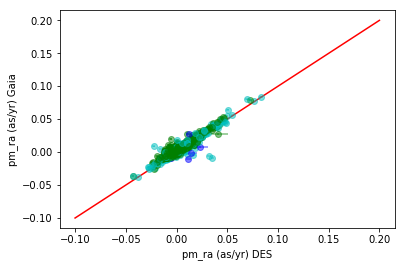

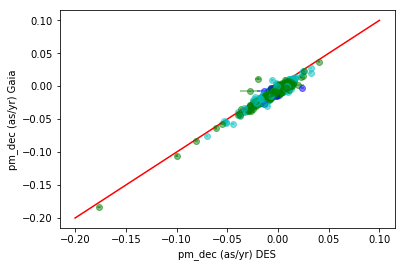

mu RA error (Gaia): median: 0.000786049394931 mean: 0.00100578388557
mu Dec error (Gaia): median: 0.000504428315909 mean: 0.000803970110977
mu RA difference: median: 0.0031506586909 mean: 0.00311309369662
mu Dec difference: median: -0.0052438863618 mean: -0.00522458234844


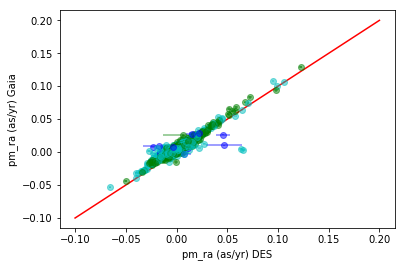

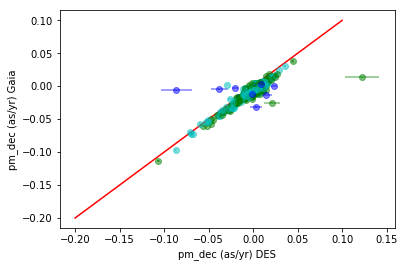

mu RA error (Gaia): median: 0.000854906889546 mean: 0.00110840916131
mu Dec error (Gaia): median: 0.00050121076382 mean: 0.000826369964175
mu RA difference: median: 0.00536231333057 mean: 0.00518638342231
mu Dec difference: median: -0.00606018984647 mean: -0.00605399012971


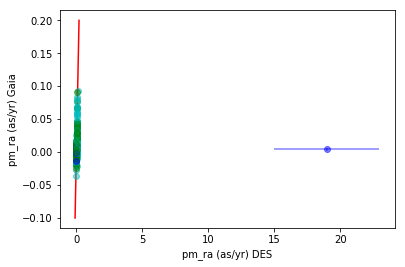

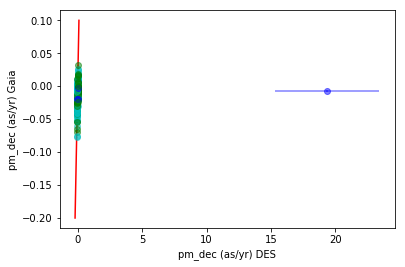

mu RA error (Gaia): median: 0.000814306684033 mean: 0.00107926892932
mu Dec error (Gaia): median: 0.000479247955234 mean: 0.00077906195489
mu RA difference: median: 0.0036812189233 mean: -0.0157228499265
mu Dec difference: median: -0.00413341069927 mean: -0.0215070191033


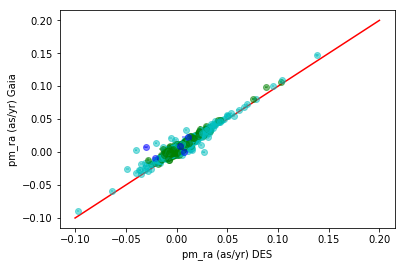

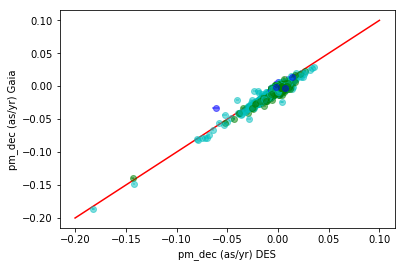

mu RA error (Gaia): median: 0.000741056165349 mean: 0.00101253988593
mu Dec error (Gaia): median: 0.00046872455394 mean: 0.000832232682972
mu RA difference: median: 0.00413455754006 mean: 0.00426285703281
mu Dec difference: median: -0.00463538298418 mean: -0.00469727399713


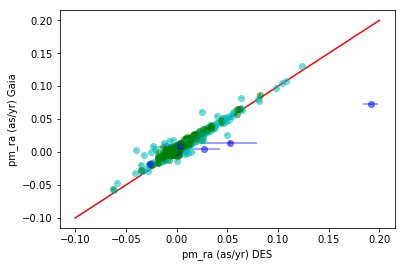

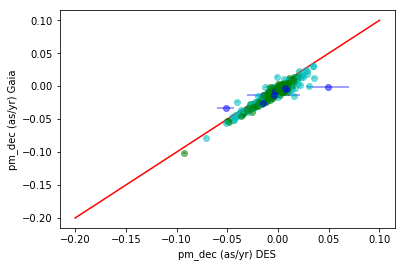

mu RA error (Gaia): median: 0.000728198134479 mean: 0.00101876367914
mu Dec error (Gaia): median: 0.000454206329769 mean: 0.000797814406374
mu RA difference: median: 0.00403879288562 mean: 0.00407274934135
mu Dec difference: median: -0.00561080723279 mean: -0.00570996431587


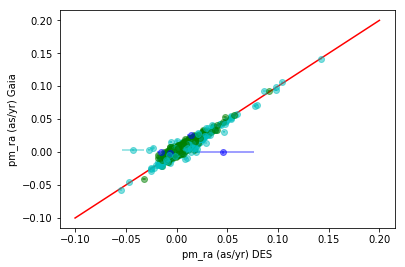

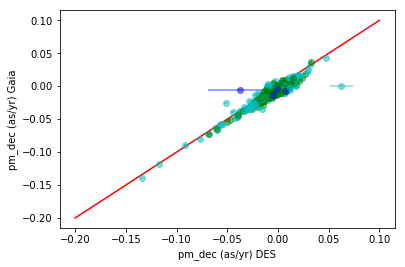

mu RA error (Gaia): median: 0.000912724310206 mean: 0.00119863955552
mu Dec error (Gaia): median: 0.000518590023515 mean: 0.000862229186186
mu RA difference: median: 0.000963490274672 mean: 0.00112995362817
mu Dec difference: median: -0.00438615286143 mean: -0.00417109935259


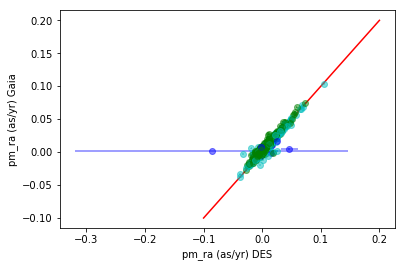

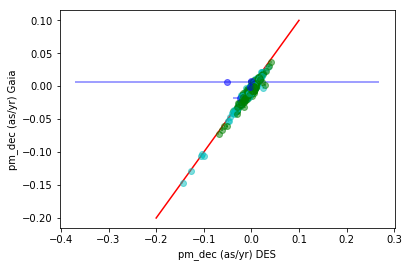

mu RA error (Gaia): median: 0.00063340717938 mean: 0.000889918880333
mu Dec error (Gaia): median: 0.000421789033177 mean: 0.000751767308321
mu RA difference: median: 0.00337387650347 mean: 0.00326587281439
mu Dec difference: median: -0.00447920529101 mean: -0.00437357276485


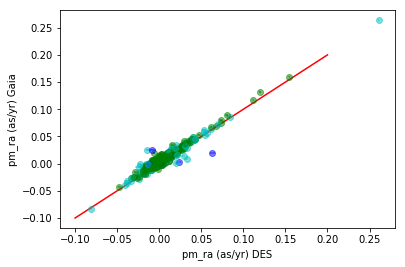

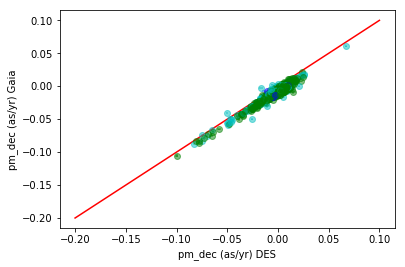

mu RA error (Gaia): median: 0.000851342396348 mean: 0.0011018066294
mu Dec error (Gaia): median: 0.000517566229773 mean: 0.000820608464701
mu RA difference: median: 0.0040137013455 mean: 0.0040463425995
mu Dec difference: median: -0.00663583756289 mean: -0.0067369710833


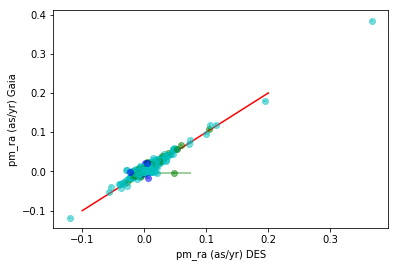

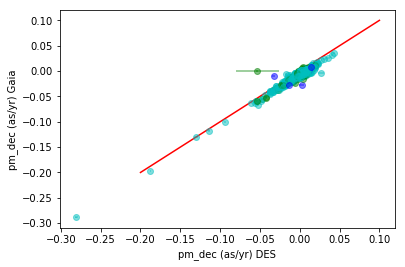

mu RA error (Gaia): median: 0.000810459806219 mean: 0.00104417177651
mu Dec error (Gaia): median: 0.000494851798931 mean: 0.000757024398491
mu RA difference: median: 0.00505354059813 mean: 0.00487680321472
mu Dec difference: median: -0.0058747609552 mean: -0.00596799122011


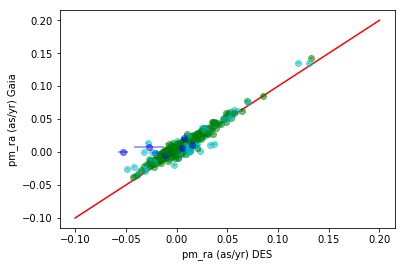

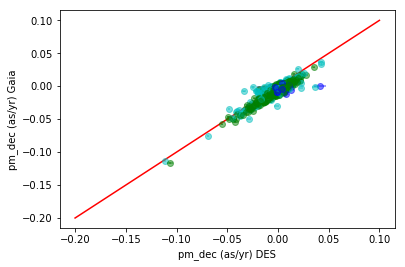

mu RA error (Gaia): median: 0.000862294748455 mean: 0.00105907303293
mu Dec error (Gaia): median: 0.000533070876348 mean: 0.000849310344608
mu RA difference: median: 0.00496224362261 mean: 0.00480424844961
mu Dec difference: median: -0.00496814071029 mean: -0.00469523246519


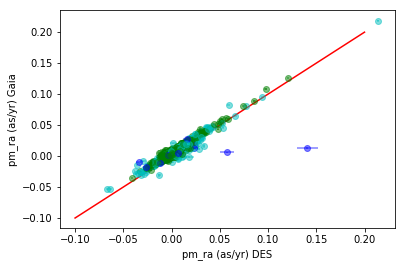

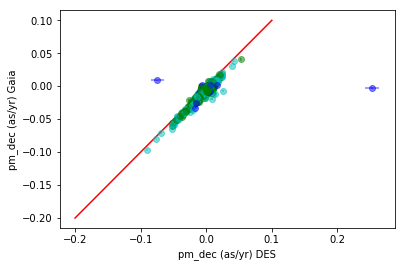

mu RA error (Gaia): median: 0.000727344875827 mean: 0.000980617688115
mu Dec error (Gaia): median: 0.000455138593548 mean: 0.000794620660244
mu RA difference: median: 0.00500466610374 mean: 0.00459721531156
mu Dec difference: median: -0.00564683687816 mean: -0.00597093028749


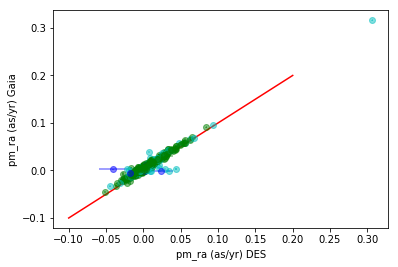

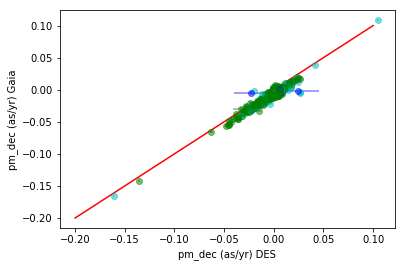

mu RA error (Gaia): median: 0.000828484479223 mean: 0.00109158983465
mu Dec error (Gaia): median: 0.000490709221095 mean: 0.000803386716909
mu RA difference: median: 0.00504954854908 mean: 0.00495927229254
mu Dec difference: median: -0.00597548274465 mean: -0.00594002163483


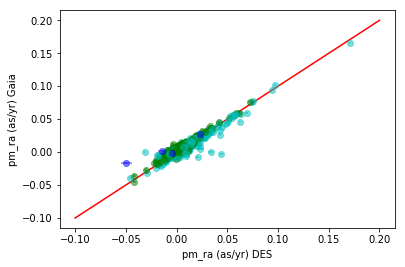

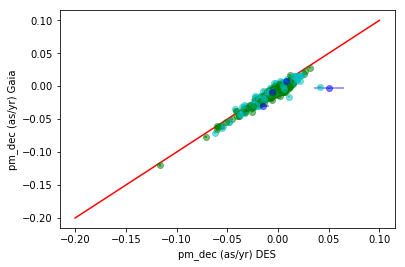

mu RA error (Gaia): median: 0.000752992970489 mean: 0.0010017369013
mu Dec error (Gaia): median: 0.000531361475421 mean: 0.000847248633312
mu RA difference: median: 0.00217566209217 mean: 0.00180321118127
mu Dec difference: median: -0.00487548203191 mean: -0.00483457413572


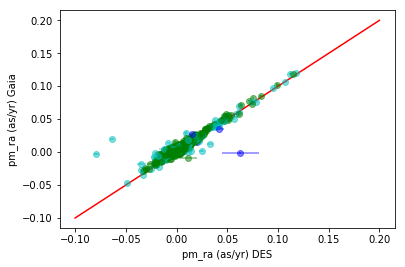

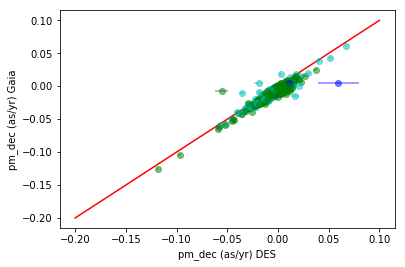

mu RA error (Gaia): median: 0.000761480295347 mean: 0.00105395110795
mu Dec error (Gaia): median: 0.000499688280125 mean: 0.000842435846497
mu RA difference: median: 0.003685410052 mean: 0.00386455930913
mu Dec difference: median: -0.00559108161501 mean: -0.00550929311617


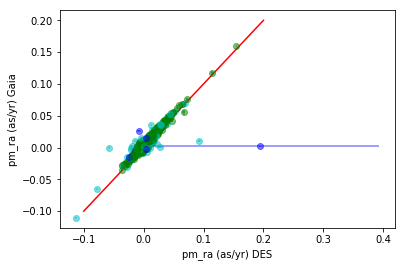

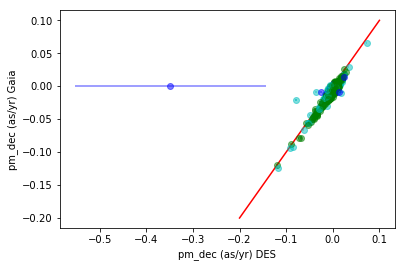

mu RA error (Gaia): median: 0.000765670023667 mean: 0.0010465953238
mu Dec error (Gaia): median: 0.000469469094615 mean: 0.000824573384291
mu RA difference: median: 0.00488303739761 mean: 0.00450482730428
mu Dec difference: median: -0.00578565793454 mean: -0.0052943746018


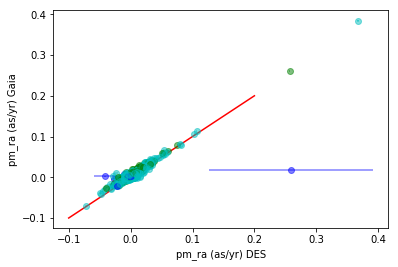

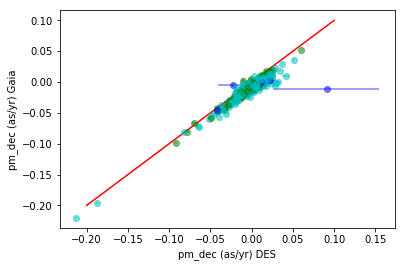

mu RA error (Gaia): median: 0.000779642400677 mean: 0.00104911574152
mu Dec error (Gaia): median: 0.000465134170794 mean: 0.000791796647187
mu RA difference: median: 0.00534602692543 mean: 0.0052181285195
mu Dec difference: median: -0.00650372756272 mean: -0.00704581496166


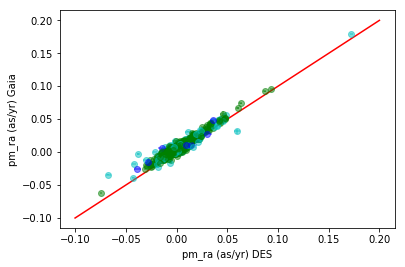

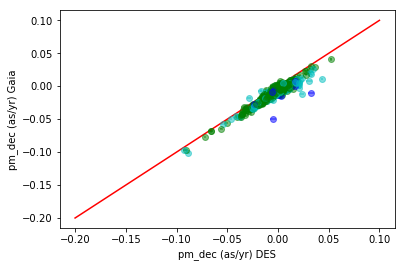

mu RA error (Gaia): median: 0.000812055085634 mean: 0.00101806122923
mu Dec error (Gaia): median: 0.000530717232316 mean: 0.000876973698871
mu RA difference: median: 0.00566187989691 mean: 0.00566098218744
mu Dec difference: median: -0.00602952645496 mean: -0.00622864307514


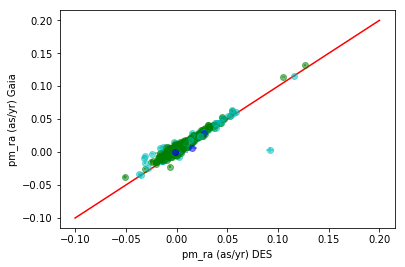

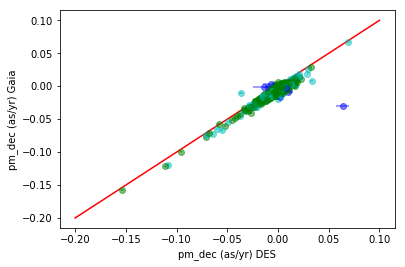

mu RA error (Gaia): median: 0.000708166050863 mean: 0.00101816402679
mu Dec error (Gaia): median: 0.000453453553656 mean: 0.000798584316086
mu RA difference: median: 0.00489058670297 mean: 0.00477562325474
mu Dec difference: median: -0.00534386021062 mean: -0.00543561959961


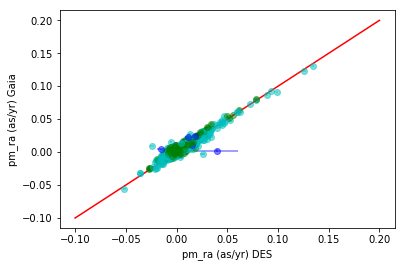

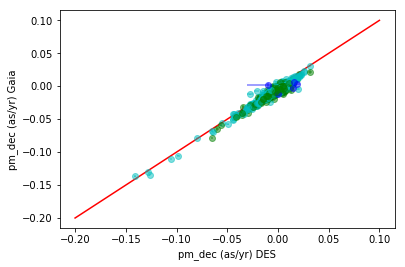

mu RA error (Gaia): median: 0.000753385987763 mean: 0.0010218069644
mu Dec error (Gaia): median: 0.00051791194204 mean: 0.000915270263503
mu RA difference: median: 0.00266315831651 mean: 0.00240445059254
mu Dec difference: median: -0.00468635732399 mean: -0.00457860423138


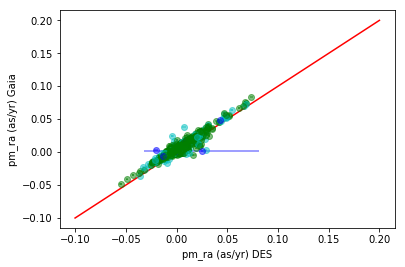

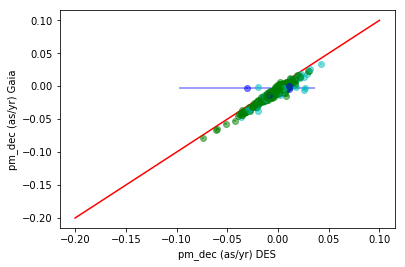

mu RA error (Gaia): median: 0.000828993861798 mean: 0.00106771055804
mu Dec error (Gaia): median: 0.000507460844555 mean: 0.000796096131322
mu RA difference: median: 0.00514111014971 mean: 0.00468134690078
mu Dec difference: median: -0.00613867702427 mean: -0.0061207153117


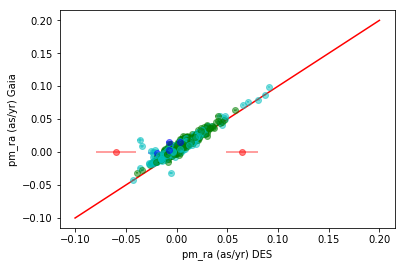

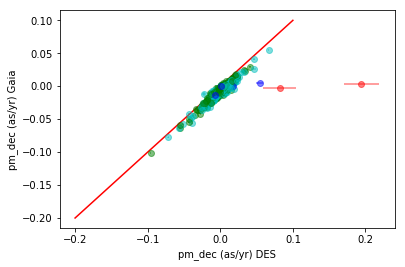

mu RA error (Gaia): median: 0.000791381735876 mean: 0.000995091552773
mu Dec error (Gaia): median: 0.00051716393273 mean: 0.000775228072051
mu RA difference: median: 0.00548146330127 mean: 0.00558314437794
mu Dec difference: median: -0.00660307578706 mean: -0.00698768490008


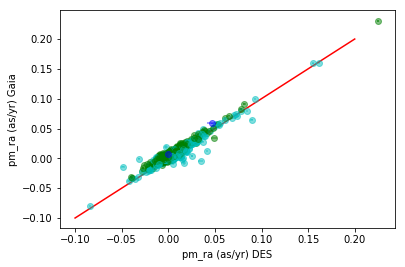

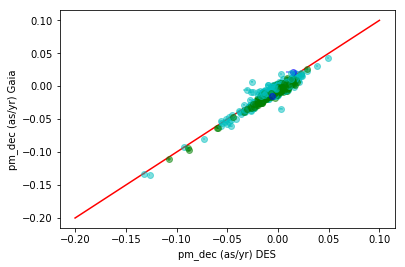

mu RA error (Gaia): median: 0.00073914715344 mean: 0.00102205179779
mu Dec error (Gaia): median: 0.000472649124667 mean: 0.000784340877373
mu RA difference: median: 0.00413927061974 mean: 0.00372785836142
mu Dec difference: median: -0.00507487249752 mean: -0.00458374052299


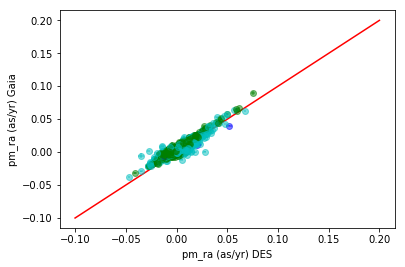

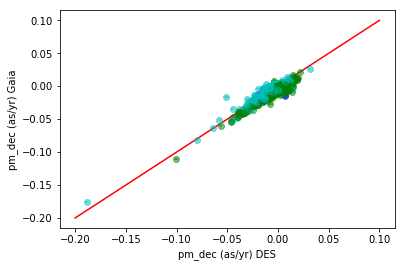

mu RA error (Gaia): median: 0.000736895091991 mean: 0.000974145869871
mu Dec error (Gaia): median: 0.00049101946264 mean: 0.000857808818838
mu RA difference: median: 0.00459975203739 mean: 0.00359176852831
mu Dec difference: median: -0.00405929524233 mean: -0.00343571147425


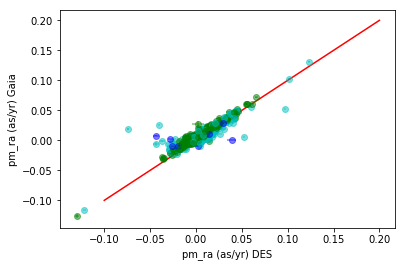

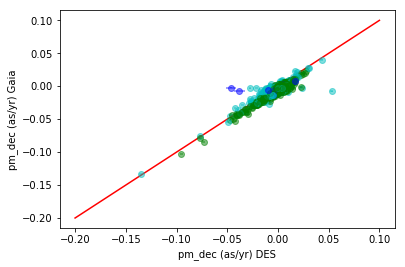

mu RA error (Gaia): median: 0.000831456221398 mean: 0.00108818265724
mu Dec error (Gaia): median: 0.000551589856609 mean: 0.000893613315086
mu RA difference: median: 0.005012430774 mean: 0.00472069648539
mu Dec difference: median: -0.00476012531945 mean: -0.00419141205687


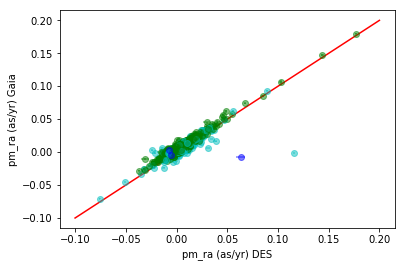

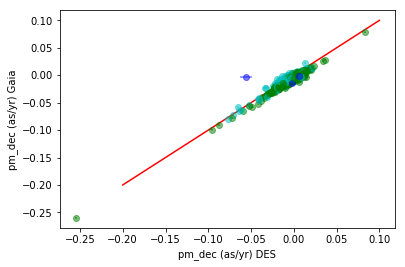

mu RA error (Gaia): median: 0.000897099984332 mean: 0.00112584801954
mu Dec error (Gaia): median: 0.000545782335149 mean: 0.00082570473656
mu RA difference: median: 0.00427336224321 mean: 0.0037660163568
mu Dec difference: median: -0.00449354680138 mean: -0.00393370458811


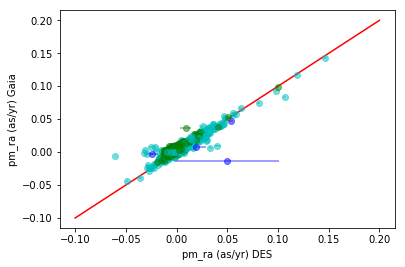

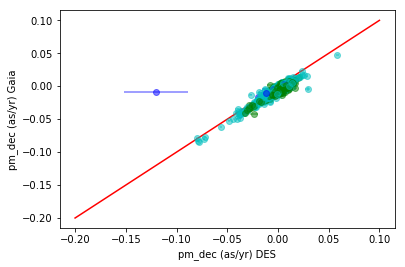

mu RA error (Gaia): median: 0.000843440347406 mean: 0.00110149020966
mu Dec error (Gaia): median: 0.000539782037843 mean: 0.000859289582798
mu RA difference: median: 0.00346797995182 mean: 0.0034267340175
mu Dec difference: median: -0.00510993031629 mean: -0.00498498252329


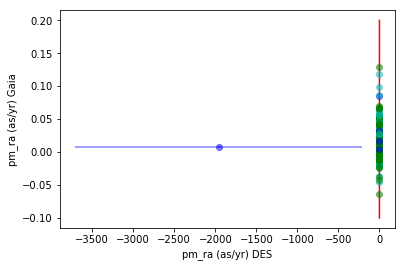

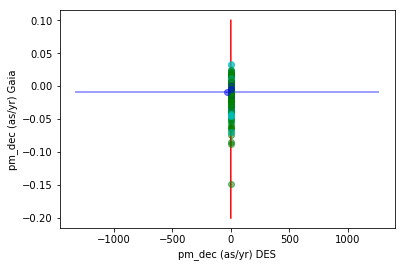

mu RA error (Gaia): median: 0.00070863948797 mean: 0.000946321766324
mu Dec error (Gaia): median: 0.000481868151094 mean: 0.000802858717341
mu RA difference: median: 0.00560240067943 mean: 2.05431499067
mu Dec difference: median: -0.00627352090796 mean: 0.0257136648681


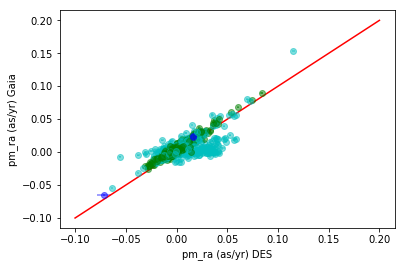

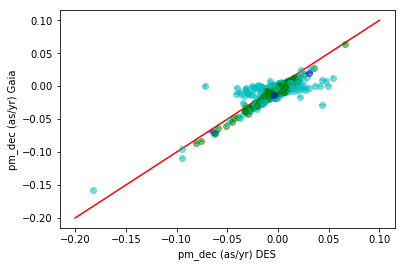

mu RA error (Gaia): median: 0.000792186879716 mean: 0.00102942551177
mu Dec error (Gaia): median: 0.000518784033502 mean: 0.000818915456283
mu RA difference: median: 0.00499974531325 mean: 0.00306166834437
mu Dec difference: median: -0.00584299622832 mean: -0.00538102494912


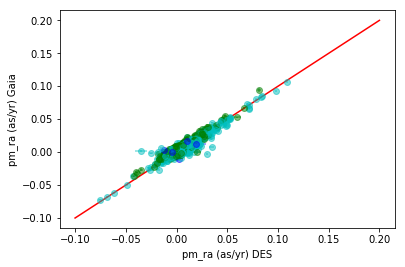

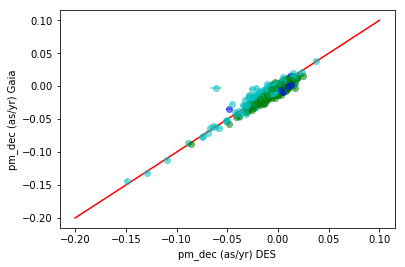

mu RA error (Gaia): median: 0.000756083675935 mean: 0.00101057034363
mu Dec error (Gaia): median: 0.000517095830289 mean: 0.000829151140488
mu RA difference: median: 0.00151579863149 mean: 0.00136270514137
mu Dec difference: median: -0.00276964444333 mean: -0.00256581447148


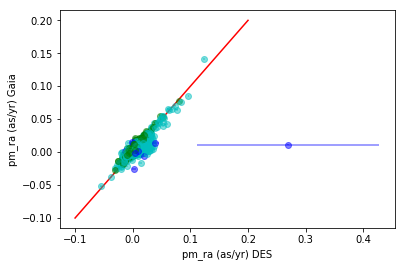

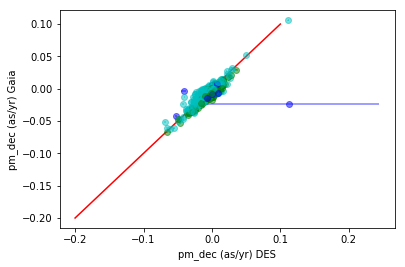

mu RA error (Gaia): median: 0.000720514705335 mean: 0.00106990137028
mu Dec error (Gaia): median: 0.000526306835986 mean: 0.000910469736554
mu RA difference: median: 0.00116645291467 mean: -8.73019667866e-05
mu Dec difference: median: -0.00188284651759 mean: -0.00170257085637


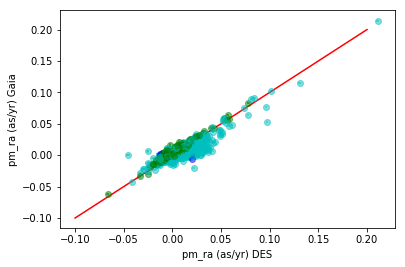

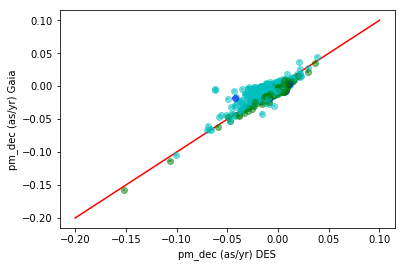

mu RA error (Gaia): median: 0.000864762426165 mean: 0.00114554127734
mu Dec error (Gaia): median: 0.000522865945661 mean: 0.000871501805766
mu RA difference: median: -7.05869775182e-05 mean: -0.0016816744903
mu Dec difference: median: -0.00112024948862 mean: 0.000201627620784


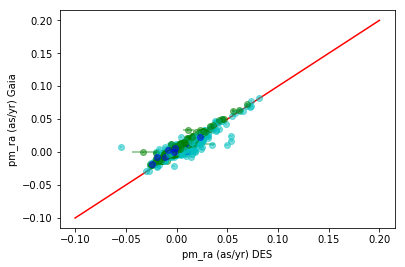

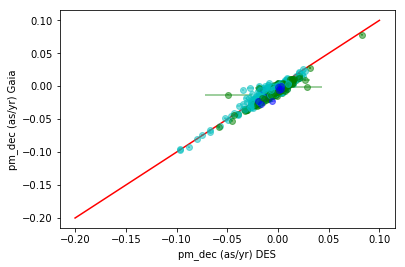

mu RA error (Gaia): median: 0.000680706599664 mean: 0.000955458700148
mu Dec error (Gaia): median: 0.000509342466337 mean: 0.0008613911845
mu RA difference: median: 0.00283820521704 mean: 0.00212778084021
mu Dec difference: median: -0.00328704223768 mean: -0.00286713733899


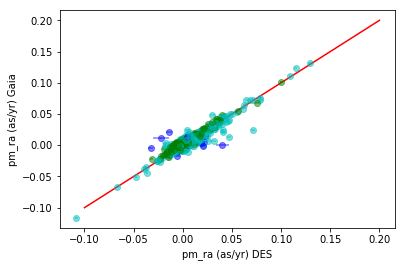

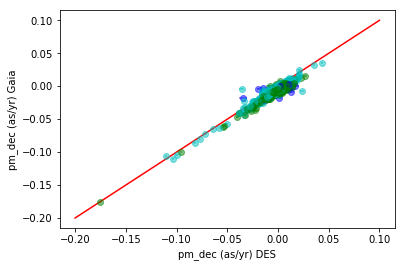

mu RA error (Gaia): median: 0.000728083514988 mean: 0.000973896022298
mu Dec error (Gaia): median: 0.000505205994504 mean: 0.000809563408838
mu RA difference: median: 0.00185811069984 mean: 0.00160623805235
mu Dec difference: median: -0.00474468166718 mean: -0.00453214105836


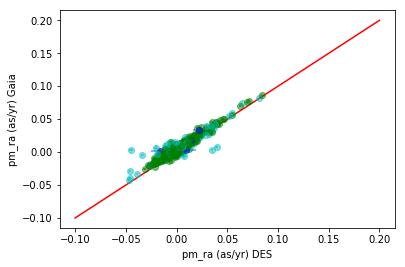

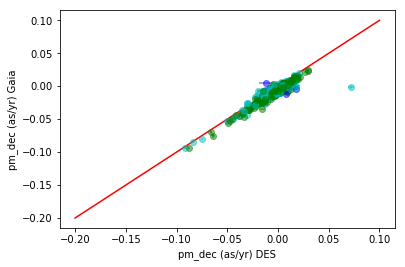

mu RA error (Gaia): median: 0.000775820997993 mean: 0.0010321016295
mu Dec error (Gaia): median: 0.000527585692024 mean: 0.000862955589315
mu RA difference: median: 0.00465049879471 mean: 0.00467704391563
mu Dec difference: median: -0.00489015722015 mean: -0.00480202847984


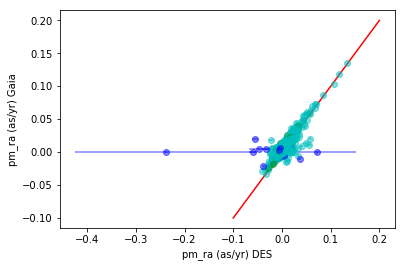

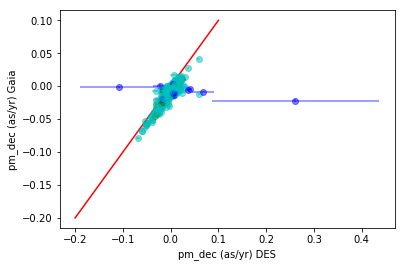

mu RA error (Gaia): median: 0.00074836090329 mean: 0.000964403321006
mu Dec error (Gaia): median: 0.000504915365204 mean: 0.000794179790708
mu RA difference: median: 0.00580925169445 mean: 0.00550377693699
mu Dec difference: median: -0.0070495591586 mean: -0.00724940798895


In [401]:
dicts = []
for i, tile in enumerate(tiles_n):
    dicts.append(comparePM(tile, indices[i], g))

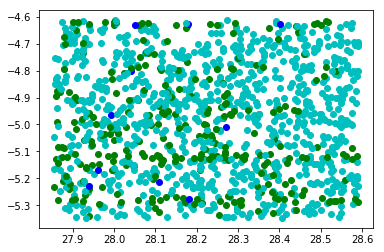

In [310]:
for row in matched1[-5]:
    plt.plot(row['RA'], row['DEC'], colorPoint(row['CHI2_RED'], row['N']))
plt.show()

In [33]:
tiles_n[21][np.where((tiles_n[21]['MU_RA'] > 0.3) & (tiles_n[21]['N'] > 20))]

<Table length=1>
MATCH_ID   COADD_ID  ...          GAIA_MATCH           GAIA_MATCH_DIST 
float64    float64   ...            str50                  float64     
-------- ----------- ... ---------------------------- -----------------
 13061.0 268493828.0 ... Gaia DR2 2467182154313027712 6.32988771045e-09

In [35]:
tiles_n[-5][np.where((tiles_n[-5]['MU_RA'] > 0.2) & (tiles_n[-5]['N'] > 10))]

<Table length=1>
MATCH_ID   COADD_ID  ...          GAIA_MATCH           GAIA_MATCH_DIST 
float64    float64   ...            str50                  float64     
-------- ----------- ... ---------------------------- -----------------
  5154.0 257563036.0 ... Gaia DR2 2491988648464518400 3.55311056204e-09

In [82]:
filenames[-5]

'/Users/Suyog/Documents/GitHub/DES-Proper-Motion/zone029/DES0152-0458_proper.fits'

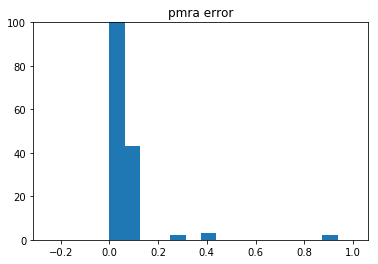

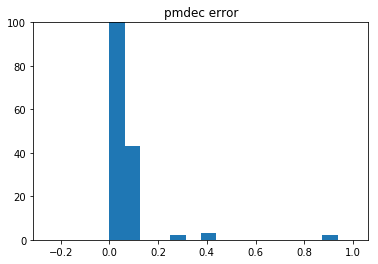

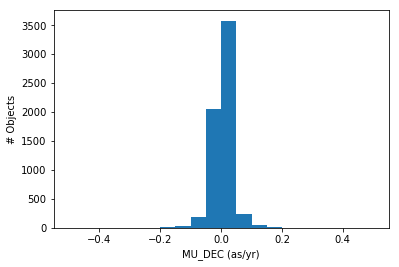

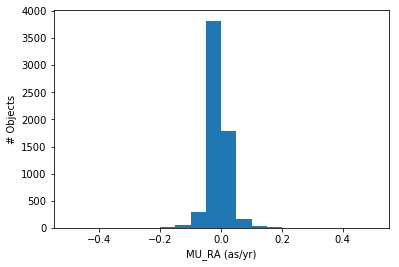

In [417]:
# Potentially galaxies?
gals = Table.read('zone029/DES0135-0416_proper_n.fits')
#some[np.where(some['SPREAD_MODEL'] > 0.01)]['SPREAD_MODEL']
gal = np.where(gals['SPREAD_MODEL_WAVG'] > 0.01)
plt.hist(np.sqrt(gals[gal]['MU_RA_ERR']), range =(-0.25, 1), bins = 20)
plt.ylim(0, 100)
plt.title('pmra error')
plt.show()
plt.hist(np.sqrt(gals[gal]['MU_DEC_ERR']), range =(-0.25, 1), bins = 20)
plt.ylim(0, 100)
plt.title('pmdec error')
plt.show()
plt.hist(gals[gal]['MU_DEC'], range =(-0.5, 0.5), bins = 20)
#plt.ylim(0, 100)
plt.xlabel('MU_DEC (as/yr)')
plt.ylabel('# Objects')
#plt.title('pmdec')
plt.show()
plt.hist(gals[gal]['MU_RA'], range =(-0.5, 0.5), bins = 20)
#plt.ylim(0, 100)
plt.xlabel('MU_RA (as/yr)')
plt.ylabel('# Objects')
#plt.title('pmra')
plt.show()


In [428]:
galx = gals[gal]
gal_m = getGaiaMatches(galx, tree)

Matches: 35


In [429]:
galx[gal_m]

<Table length=35>
MATCH_ID COADD_OBJECT_ID ...          GAIA_MATCH           GAIA_MATCH_DIST 
float64      float64     ...            str50                  float64     
-------- --------------- ... ---------------------------- -----------------
   356.0     233004679.0 ... Gaia DR2 2480884268218734720 5.73740545473e-09
   487.0     233009085.0 ... Gaia DR2 2480878323983998976 5.03956986549e-09
   673.0     233007707.0 ... Gaia DR2 2480890934007991040 3.14683159141e-09
   694.0     233007092.0 ... Gaia DR2 2480890964072534912 2.97728351782e-09
   729.0     233005697.0 ... Gaia DR2 2480891689922233600 3.65127526219e-09
  1152.0     233007985.0 ... Gaia DR2 2480888288308168832 3.10427576976e-09
  1348.0     233005304.0 ... Gaia DR2 2480892342756801792 3.96539174587e-09
  1606.0     233012625.0 ... Gaia DR2 2480871756978513280 4.91351405621e-09
  2115.0     233014362.0 ... Gaia DR2 2480861900029089664 3.46883290238e-09
  2120.0     233013535.0 ... Gaia DR2 2480862071827781120 4.38200809709e-09
     ...             ... ...                          ...               ...
  4892.0     233028557.0 ... Gaia DR2 2480793558509513600 3.78855760508e-09
  5047.0     233037134.0 ... Gaia DR2 2480703467275499008 6.57889568005e-09
  5247.0     233002811.0 ... Gaia DR2 2483887034474422272 5.21473821343e-09
  5335.0     233003964.0 ... Gaia DR2 2480884126484342784 4.87288930921e-09
  5497.0     233011123.0 ... Gaia DR2 2480877391975851520 5.07759098722e-09
  5713.0     233017664.0 ... Gaia DR2 2480857192744904064 4.62588936748e-09
  7578.0     233037162.0 ... Gaia DR2 2480784968574889344 3.71186947282e-09
  7628.0     233033308.0 ... Gaia DR2 2480786033726278528 4.63447596879e-09
  8013.0     233012658.0 ... Gaia DR2 2480838741565444736 4.13413204484e-09
  8596.0     233004183.0 ... Gaia DR2 2480905090220195456 7.79595442819e-09

In [257]:
fin[np.where(fin['MATCH_ID'] == 3949)]

<Table length=8>
    RA       DEC      ERRAWIN_WORLD   ...     NEW_RA       NEW_DEC    
 float64   float64       float64      ...    float64       float64    
--------- --------- ----------------- ... ------------- --------------
23.455253 -4.478221 1.18712996766e-07 ... 23.4552672888 -4.47824665242
23.455235 -4.478223 1.15590999883e-07 ... 23.4552688147  -4.4782472279
23.455242 -4.478223 1.04153997427e-07 ... 23.4552624268 -4.47822312347
23.455234 -4.478209 1.13570997939e-07 ... 23.4552938524 -4.47821052766
23.455222  -4.47823 1.22681001358e-07 ... 23.4552419317 -4.47822489026
23.455242 -4.478215 1.10390999453e-07 ...  23.455236716  -4.4782129366
23.455231 -4.478221 9.94512987518e-08 ... 23.4552753399  -4.4782257247
23.455264  -4.47822             1e+20 ... 23.4552636803 -4.47822000306

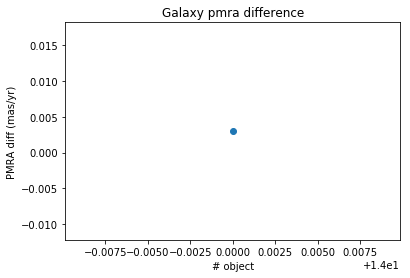

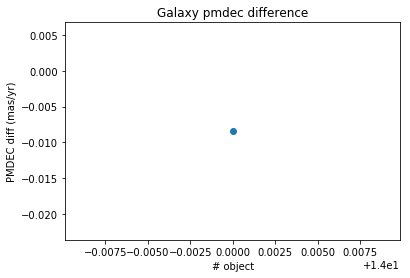

PMRA Diff Galaxies median: [--]
PMDEC Diff Galaxies median: [--]


In [430]:
# Gaia only has 2-parameter solutions for most of these :(
dpmra = []
dpmdec = []
gra = []
gdec = []
for iden in galx[gal_m]:
    g_id = iden['GAIA_MATCH']
    row = g[np.where(g['designation'] == g_id)]
    gra.append((row['pmra']/1000).data.data[0])
    gdec.append((row['pmdec']/1000).data.data[0])
    dpmra.append(row['pmra']/1000 - iden['MU_RA'])
    dpmdec.append(row['pmdec']/1000 - iden['MU_DEC'])
plt.scatter(range(len(dpmra)),dpmra)
plt.title('Galaxy pmra difference')
plt.xlabel('# object')
plt.ylabel('PMRA diff (mas/yr)')
plt.show()
plt.scatter(range(len(dpmdec)),dpmdec)
plt.title('Galaxy pmdec difference')
plt.xlabel('# object')
plt.ylabel('PMDEC diff (mas/yr)')
plt.show()
print('PMRA Diff Galaxies median:', median(dpmra).data)
print('PMDEC Diff Galaxies median:', median(dpmdec).data)

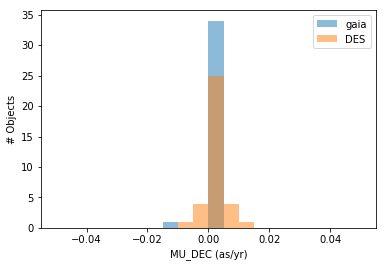

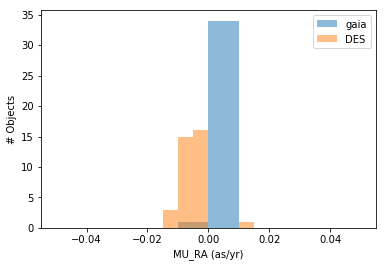

In [423]:
# galaxy plots
plt.hist(gdec, range =(-0.05, 0.05), bins = 20, label = 'gaia', alpha = 0.5)
plt.hist(galx[gal_m]['MU_DEC'], range =(-0.05, 0.05), bins = 20, label = 'DES', alpha = 0.5)
#plt.ylim(0, 100)
plt.xlabel('MU_DEC (as/yr)')
plt.ylabel('# Objects')
#plt.title('pmdec')
plt.legend()
plt.show()
plt.hist(gra, range =(-0.05, 0.05), bins = 10, label = 'gaia', alpha = 0.5)
plt.hist(galx[gal_m]['MU_RA'], range =(-0.05, 0.05), bins = 20, label = 'DES', alpha = 0.5)
#plt.ylim(0, 100)
plt.xlabel('MU_RA (as/yr)')
plt.ylabel('# Objects')
#plt.title('pmra')
plt.legend()
plt.show()

In [424]:
print('gaia median pmra galaxies:', median(gra))
print('DES median pmra galaxies:', median(galx[gal_m]['MU_RA']))
print('gaia median pmdec galaxies:', median(gdec))
print('DES median pmdec galaxies:', median(galx[gal_m]['MU_DEC']))

gaia median pmra galaxies: 0.0
DES median pmra galaxies: -0.0050480031035
gaia median pmdec galaxies: 0.0
DES median pmdec galaxies: 0.00242898969914


In [432]:
print('Median pmra error:', median(np.sqrt(galx[gal_m]['MU_RA_ERR'])))
print('Median pmdec error:', median(np.sqrt(galx[gal_m]['MU_DEC_ERR'])))

Median pmra error: 0.00132152127887
Median pmdec error: 0.00125027493481


In [201]:
matched[9][np.where(matched[9]['MU_DEC'] < -0.05)]

<Table length=5>
MATCH_ID   COADD_ID  ...          GAIA_MATCH           GAIA_MATCH_DIST 
float64    float64   ...            str50                  float64     
-------- ----------- ... ---------------------------- -----------------
  1125.0 265468967.0 ... Gaia DR2 2479651230352568064 4.97459469529e-09
  1265.0 265470765.0 ... Gaia DR2 2479727581986298624 4.61805838197e-09
  2821.0 265487252.0 ... Gaia DR2 2479579349780047744 2.27513738787e-09
  3602.0 265491942.0 ... Gaia DR2 2479563926552612992 6.05269524826e-10
  5165.0 265484806.0 ... Gaia DR2 2479579968255372544 3.83846254805e-09

In [45]:
x = np.where(np.abs(dicts[0]['diff_ra']) > 0.04)
matched[0][x]
#dicts[15]['diff_ra'][x]

<Table length=5>
MATCH_ID   COADD_ID  ...          GAIA_MATCH           GAIA_MATCH_DIST 
float64    float64   ...            str50                  float64     
-------- ----------- ... ---------------------------- -----------------
  1569.0 233015070.0 ... Gaia DR2 2480870554390630272  6.3361002489e-09
  2220.0 233012243.0 ... Gaia DR2 2480863201405309696 4.84942988133e-09
  2799.0 233019800.0 ... Gaia DR2 2480854233513262848 6.47364196027e-09
 10731.0 233014531.0 ... Gaia DR2 2480837775200667520 5.25964083256e-09
 23997.0 233009741.0 ... Gaia DR2 2480846025829722368 4.40151002686e-09

In [67]:
g[np.where(g['designation'] == 'Gaia DR2 2480870554390630272')]

<Table masked=True length=1>
        designation               source_id      ... teff_val a_g_val
           str28                    int64        ... float64  float64
---------------------------- ------------------- ... -------- -------
Gaia DR2 2480870554390630272 2480870554390630272 ...       --      --

In [117]:
def predictPositions(match_id, final, mjd):
    pec = final[np.where(final['MATCH_ID'] == match_id)]
    pec2 = pec[np.where(pec['VERSION'] != 'COADD')]
    # get time range
    time0 = min(mjd)
    time_max = max(mjd)
    time = list(mjd)
    #time = np.linspace(np.ceil(time0), np.ceil(time_max), n = time_max - time0)
    # get mu_ra and mu_dec using match id
    pmra = tiles_n[0][np.where(tiles_n[0]['MATCH_ID'] == match_id)]['MU_RA'] / 3600
    pmdec = tiles_n[0][np.where(tiles_n[0]['MATCH_ID'] == match_id)]['MU_DEC'] / 3600
    # get earliest position
    ra0, dec0 = pec2[np.where(mjd == min(mjd))]['NEW_RA'], pec2[np.where(mjd == min(mjd))]['NEW_DEC']
    # ra and dec calc
    ra = []
    dec = []
    # calculate cumulative array
    for t in time:
        dt = (t - time0) / 365.25
        ra.append(ra0 + (pmra*dt))
        dec.append(dec0 + (pmdec*dt))
    return ra, dec

In [115]:
def posOverTime(match_id, final):
    pec = final[np.where(final['MATCH_ID'] == match_id)]
    pec2 = pec[np.where(pec['VERSION'] != 'COADD')]
    ra_1, dec_1 = predictPositions(match_id, final, pec2['MJD_OBS'])
    ts1 = theilslopes(pec2['NEW_DEC'], pec2['NEW_RA'])
    abline_values = [ts1[0] * i + ts1[1] for i in pec2['NEW_RA']]
    #
    
    plt.plot(pec2['NEW_RA'], abline_values, '--')
    plt.plot(ra_1, dec_1)
    plt.errorbar(pec2['NEW_RA'], pec2['NEW_DEC'],fmt ='bo', markersize = 2, xerr = pec2['ERRAWIN_WORLD'], yerr = pec2['ERRBWIN_WORLD'])
    plt.title('Plot for: %s' % str(match_id))
    plt.xlim(min(pec2['NEW_RA']) - 10**-5, max(pec2['NEW_RA']) + 10**-5)
    plt.ylim(min(pec2['NEW_DEC']) - 10**-5, max(pec2['NEW_DEC']) + 10**-5)
    plt.xlabel('RA')
    plt.ylabel('DEC')
    plt.show()
    #
    ts2 = theilslopes(pec2['NEW_RA'], pec2['MJD_OBS'])
    line2 = [ts2[0] * i + ts2[1] for i in pec2['MJD_OBS']]
    print('MU_RA', ts2[0] * 3600 *365.25)
    plt.scatter(pec2['MJD_OBS'], pec2['NEW_RA'])
    plt.plot(pec2['MJD_OBS'], line2, '--')
    plt.plot(pec2['MJD_OBS'], np.array(ra_1))
    plt.ylim(min(pec2['NEW_RA']) - 10**-5, max(pec2['NEW_RA']) + 10**-5)
    plt.ylabel('RA')
    plt.xlabel('Time')
    #for i in pec2:
        #plt.text(i['MJD_OBS'], i['NEW_RA'], i['MJD_OBS'])
    plt.show()
    #
    ts3 = theilslopes(pec2['NEW_DEC'], pec2['MJD_OBS'])
    line3 = [ts3[0] * i + ts3[1] for i in pec2['MJD_OBS']]
    print('MU_DEC', ts3[0] * 3600 * 365.25)
    plt.scatter(pec2['MJD_OBS'], pec2['NEW_DEC'])
    plt.plot(pec2['MJD_OBS'], line3, '--')
    plt.plot(pec2['MJD_OBS'], np.array(dec_1))
    plt.ylim(min(pec2['NEW_DEC']) - 10**-5, max(pec2['NEW_DEC']) + 10**-5)
    plt.ylabel('DEC')
    plt.xlabel('Time')
    for i in pec2:
        #plt.text(i['MJD_OBS'], i['NEW_DEC'], i['MJD_OBS'])
        pass
    plt.show()

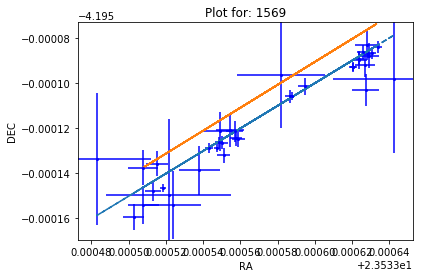

MU_RA 0.137926150818


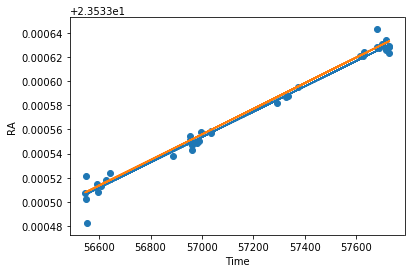

MU_DEC 0.0696395500581


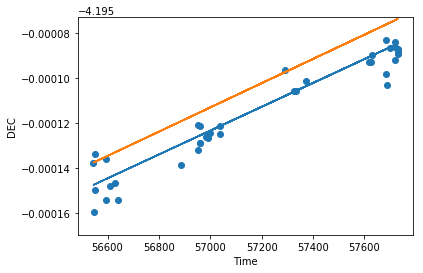

In [63]:
#fin[np.where(fin['MATCH_ID'] == 1569)]
posOverTime(1569, fin)

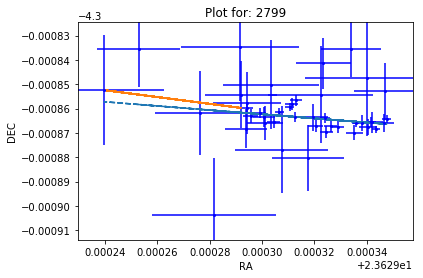

MU_RA 0.0576797406965


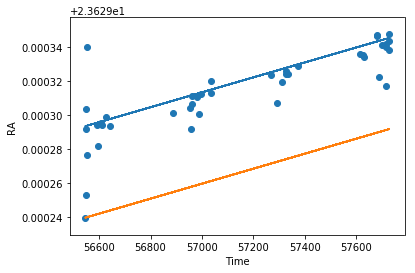

MU_DEC -0.010068012443


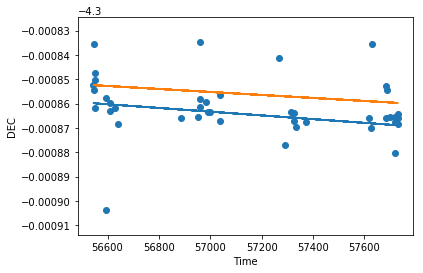

In [64]:
posOverTime(2799, fin)

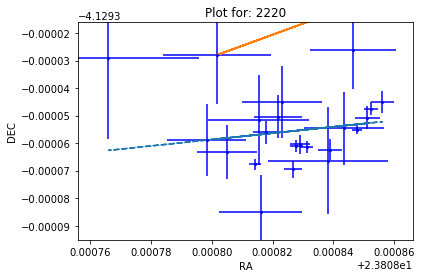

MU_RA 0.0486652472164


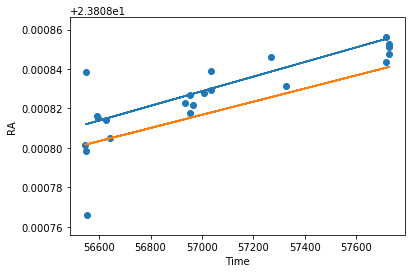

MU_DEC 0.00822169930905


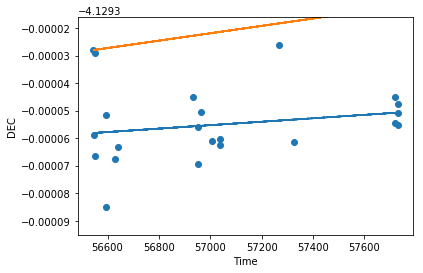

In [65]:
posOverTime(2220, fin)

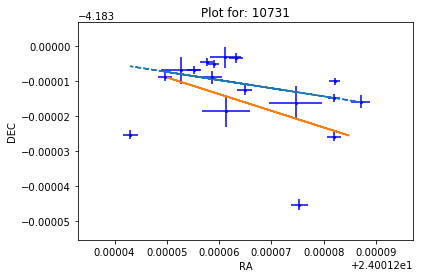

MU_RA 0.0371120493953


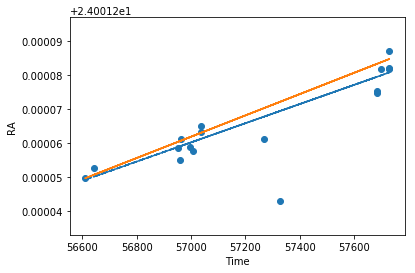

MU_DEC -0.0134177784715


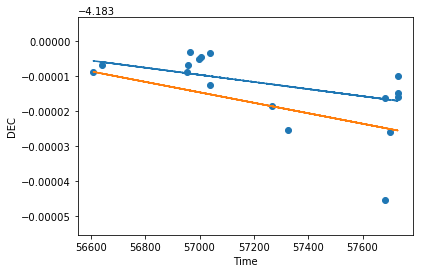

In [66]:
posOverTime(10731, fin)

In [73]:
zones[np.where((zones['RACMIN'] < 53.92) & (zones['RACMAX'] > 53.92) & (zones['DECCMIN'] < -54.05) & (zones['DECCMAX'] > -54.05))]

<Table length=1>
 ZONE     TILE     GROUP_NAME   TILENAME   ...  DECCMAX     RACMIN    RACMAX 
int64    str12        str9       str20     ...  float64    float64   float64 
----- ------------ ---------- ------------ ... ---------- --------- ---------
  186 DES0337-5414  footprint DES0337-5414 ... -53.872058 53.627429 54.888495

In [74]:
zones[np.where((zones['RACMIN'] < 56.09) & (zones['RACMAX'] > 56.09) & (zones['DECCMIN'] < -43.53) & (zones['DECCMAX'] > -43.53))]

<Table length=1>
 ZONE     TILE     GROUP_NAME   TILENAME   ...  DECCMAX     RACMIN    RACMAX 
int64    str12        str9       str20     ...  float64    float64   float64 
----- ------------ ---------- ------------ ... ---------- --------- ---------
  147 DES0343-4331  footprint DES0343-4331 ... -43.164227 55.300204 56.313868

In [42]:
gd = Table.read('Gaia-Dwarf.csv')

In [ ]:
# dec min = -22.478643999999999
# dec max = -17.464952999999998
# ra min = 45.721325
# ra max = 51.676530999999997

In [50]:
min(zones[np.where(zones['ZONE'] == 55)]['RACMIN'])

45.721325

In [501]:
# g for gaia - gaia table
g2 = Table.read('Gaia-Z55.csv')#('Gaia-DR2-short.csv')#Table.read('Gaia-DR2-0135-0416-PM.csv')

In [502]:
tree2 = kdTreeGaia(g2)

In [500]:
# Read in tiles - all from zone029
tiles_55 = []
path2 = '/Users/Suyog/Documents/GitHub/DES-Proper-Motion/zone055/'
filenames2 = glob(path2+'*proper_n.fits')
list.sort(filenames2)
for name in filenames2:
    processNewTile(name, tree2, tiles_55)

Tile number: 1
Tile number: 2
Tile number: 3
Tile number: 4
Tile number: 5
Tile number: 6
Tile number: 7
Tile number: 8
Tile number: 9
Tile number: 10
Tile number: 11
Tile number: 12
Tile number: 13
Tile number: 14
Tile number: 15
Tile number: 16
Tile number: 17
Tile number: 18
Tile number: 19
Tile number: 20
Tile number: 21
Tile number: 22
Tile number: 23
Tile number: 24
Tile number: 25
Tile number: 26
Tile number: 27
Tile number: 28
Tile number: 29
Tile number: 30
Tile number: 31
Tile number: 32
Tile number: 33
Tile number: 34
Tile number: 35
Tile number: 36
Tile number: 37
Tile number: 38
Tile number: 39
Tile number: 40
Tile number: 41
Tile number: 42
Tile number: 43
Tile number: 44
Tile number: 45
Tile number: 46
Tile number: 47
Tile number: 48


Matches: 1168


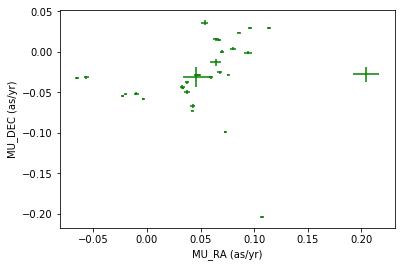

Matches: 1171


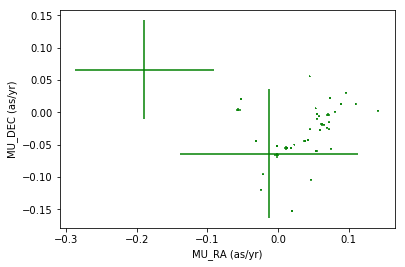

Matches: 1212


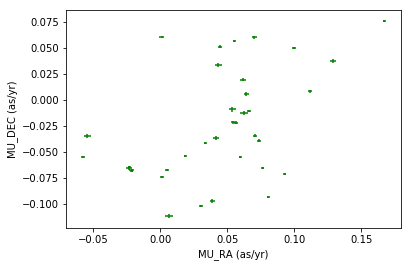

Matches: 1170


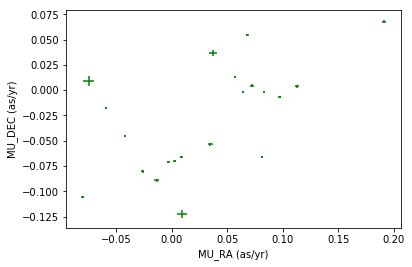

Matches: 1253


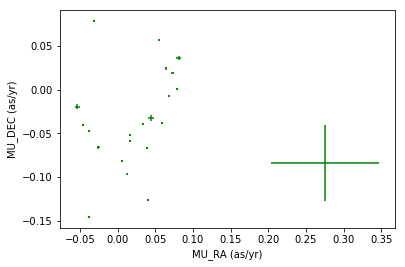

Matches: 1208


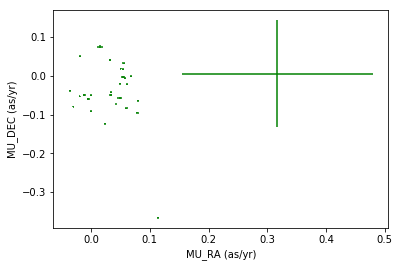

Matches: 1207


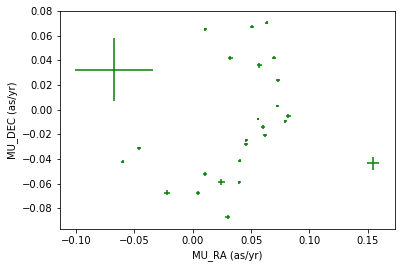

Matches: 1055


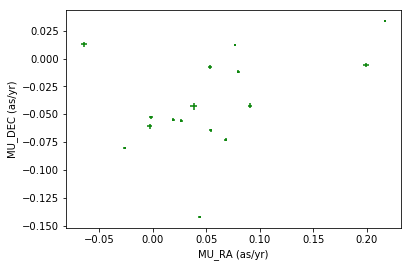

Matches: 1187


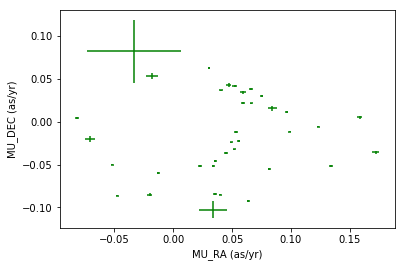

Matches: 1227


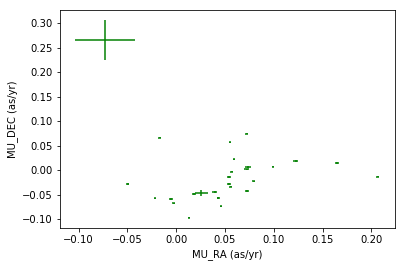

Matches: 1234


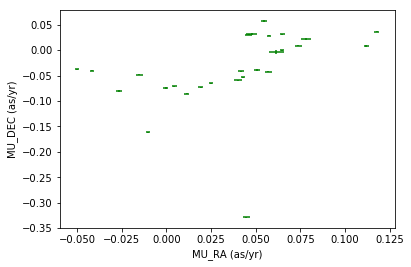

Matches: 1206


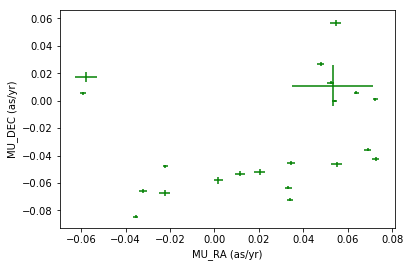

Matches: 1216


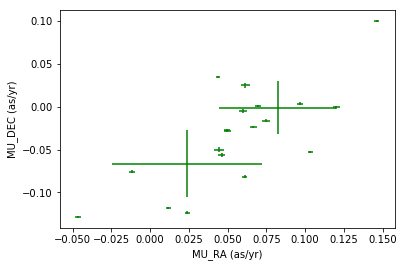

Matches: 1254


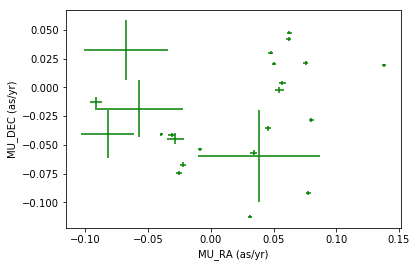

Matches: 1166


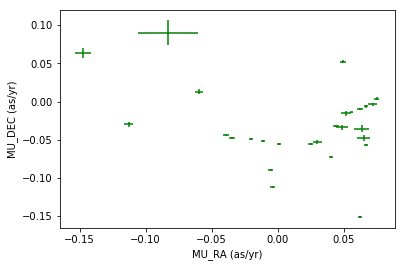

Matches: 1136


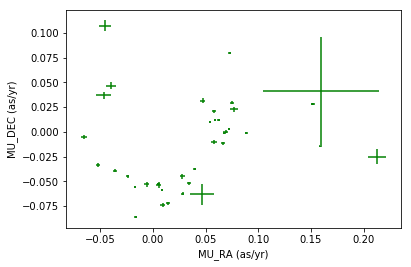

Matches: 1257


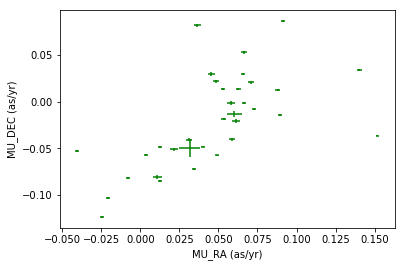

Matches: 1227


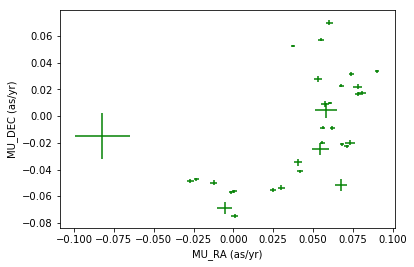

Matches: 1227


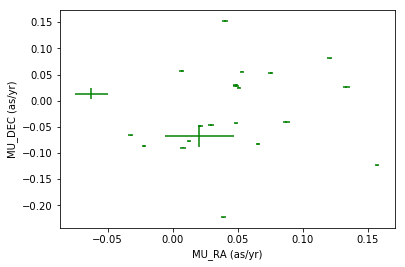

Matches: 1211


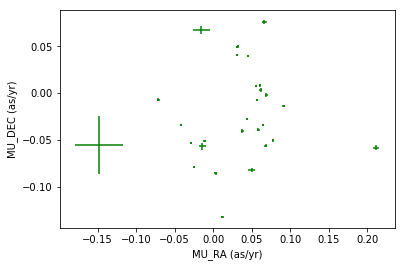

Matches: 1265


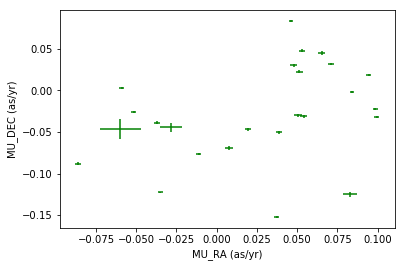

Matches: 1284


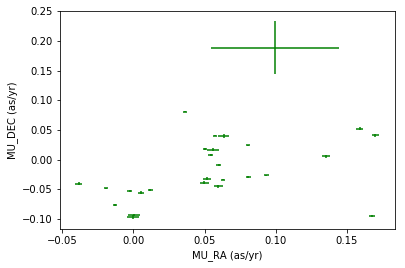

Matches: 1160


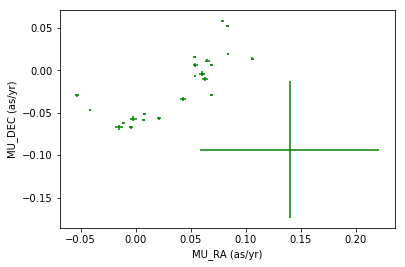

Matches: 1239


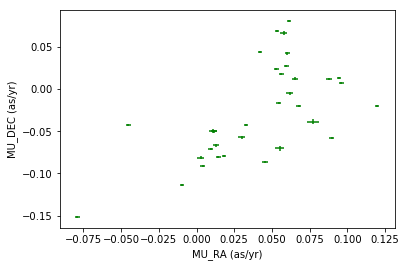

Matches: 1181


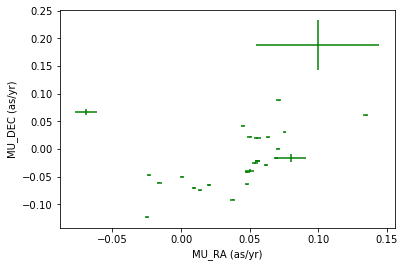

Matches: 1252


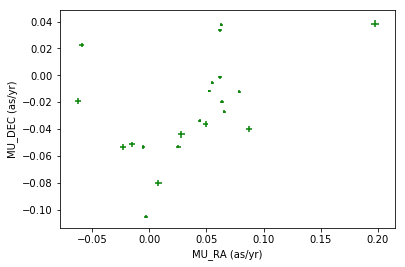

Matches: 1277


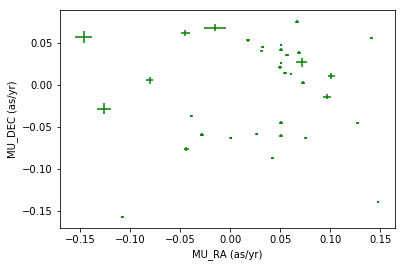

Matches: 1317


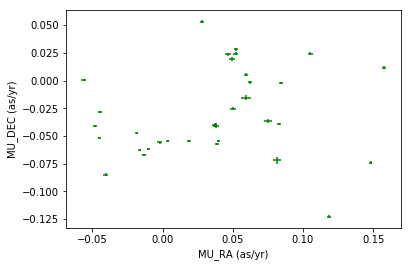

Matches: 1242


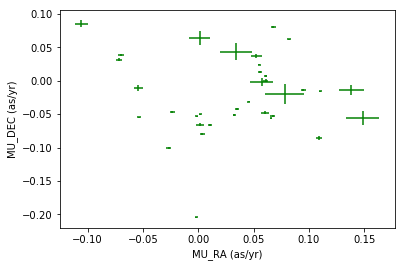

Matches: 1215


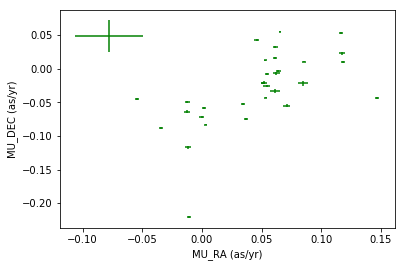

Matches: 1319


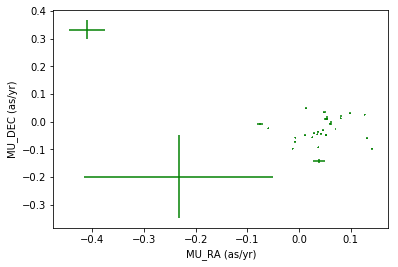

Matches: 1203


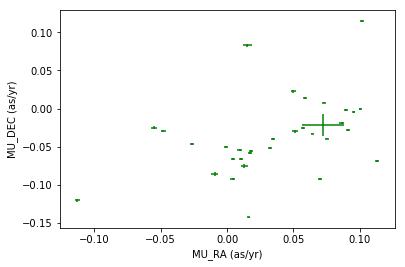

Matches: 1191


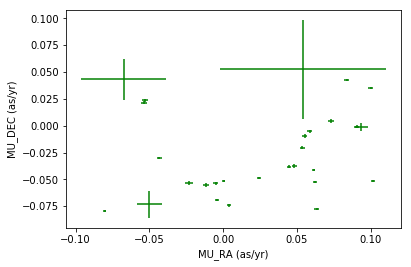

Matches: 1204


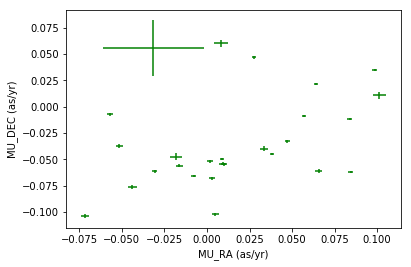

Matches: 1279


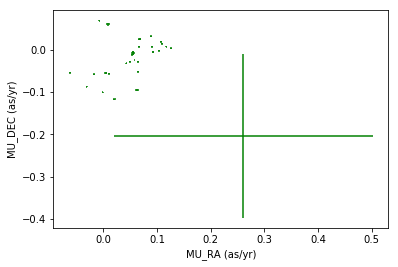

Matches: 1240


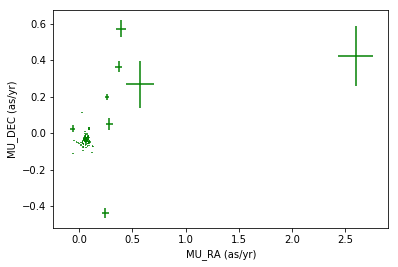

Matches: 1215


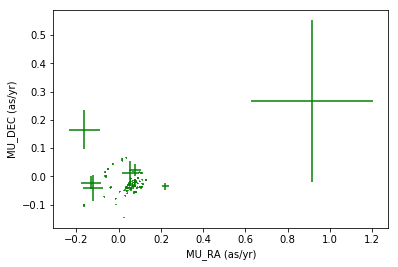

Matches: 1210


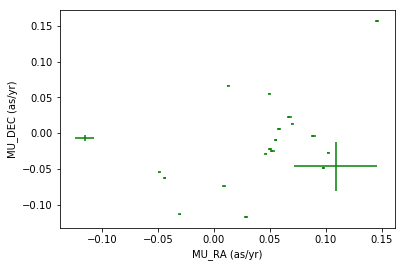

Matches: 1330


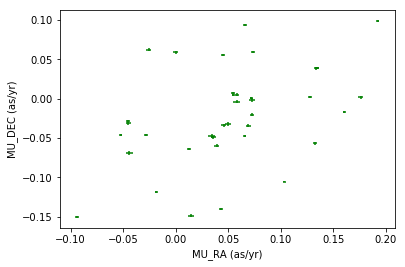

Matches: 1169


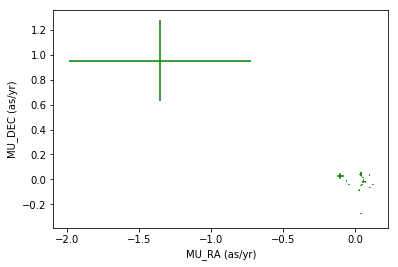

Matches: 1296


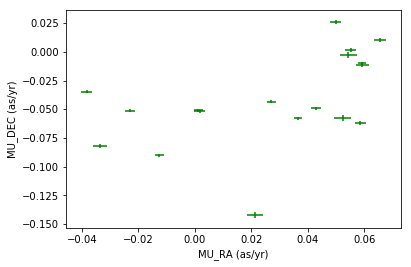

Matches: 1250


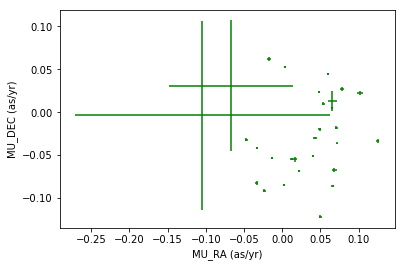

Matches: 1282


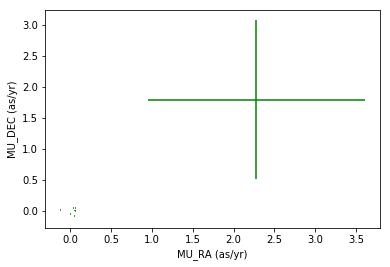

Matches: 1239


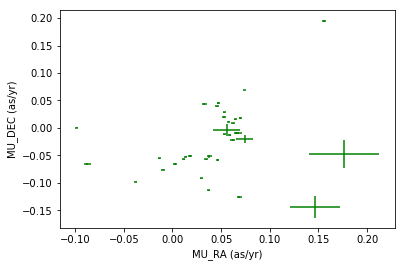

Matches: 1233


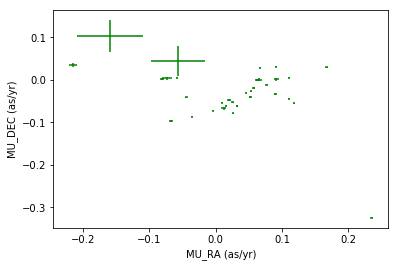

Matches: 1270


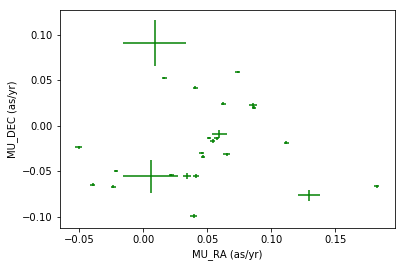

Matches: 1281


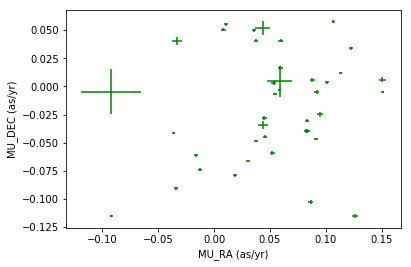

Matches: 1249


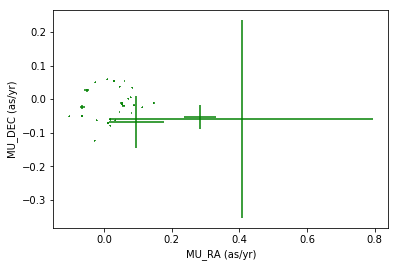

In [315]:
getIndices(tiles_55,tree2)

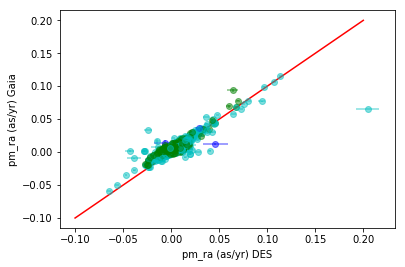

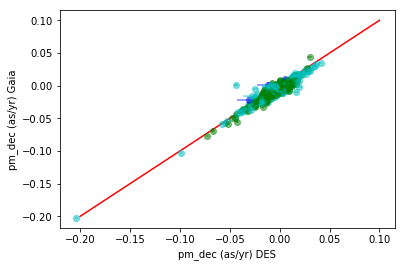

mu RA error (Gaia): median: 0.000550759000504 mean: 0.000781959075056
mu Dec error (Gaia): median: 0.000637885545282 mean: 0.000953497085794
mu RA difference: median: 0.00434416110787 mean: 0.00408973463208
mu Dec difference: median: -0.00315674791193 mean: -0.00309191587375


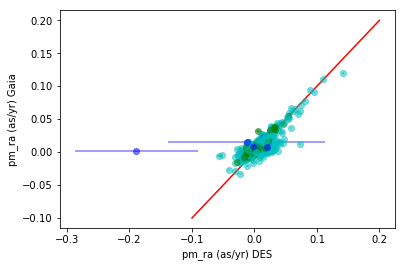

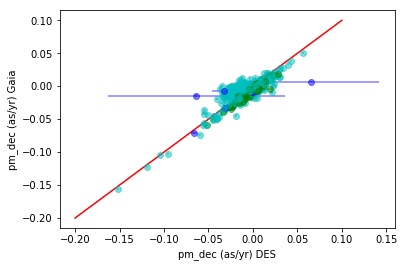

mu RA error (Gaia): median: 0.000647891901636 mean: 0.000839997310511
mu Dec error (Gaia): median: 0.000689294447927 mean: 0.000925815102048
mu RA difference: median: 0.00532996601735 mean: 0.0040670224919
mu Dec difference: median: -0.00385985639053 mean: -0.00230183078112


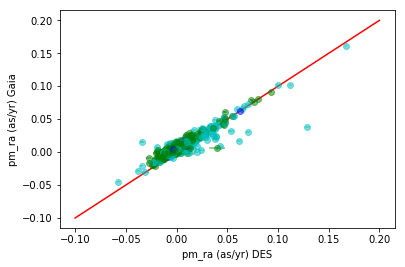

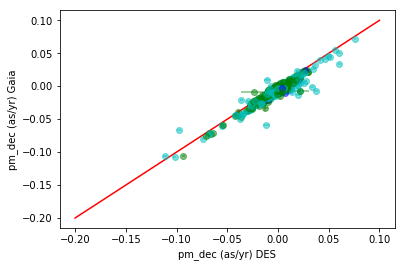

mu RA error (Gaia): median: 0.000640819356958 mean: 0.000883295154901
mu Dec error (Gaia): median: 0.00068174258962 mean: 0.000977701259447
mu RA difference: median: 0.00562151475908 mean: 0.00529583218436
mu Dec difference: median: -0.00497056152022 mean: -0.00515744451071


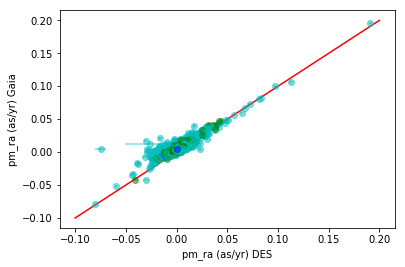

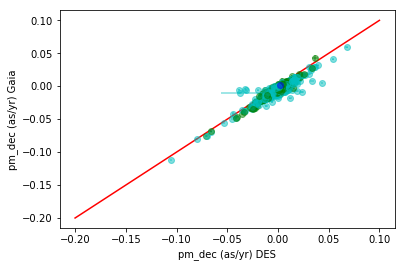

mu RA error (Gaia): median: 0.000655471042906 mean: 0.000889776501663
mu Dec error (Gaia): median: 0.000733188135122 mean: 0.00104161307174
mu RA difference: median: 0.00680570136692 mean: 0.00728225911031
mu Dec difference: median: -0.00515918829272 mean: -0.00507169977762


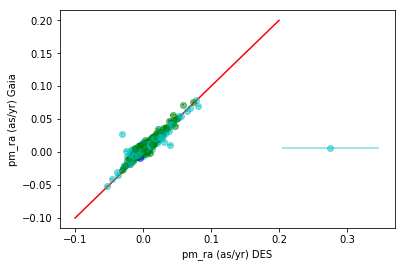

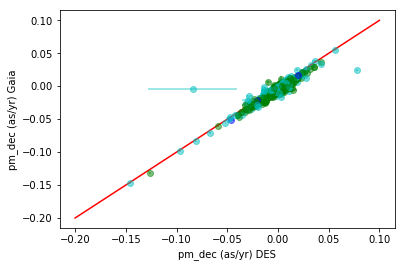

mu RA error (Gaia): median: 0.000614765338029 mean: 0.000823904948009
mu Dec error (Gaia): median: 0.00065481707108 mean: 0.000943234032128
mu RA difference: median: 0.00460778491251 mean: 0.00444362658894
mu Dec difference: median: -0.0038209167874 mean: -0.00385846422452


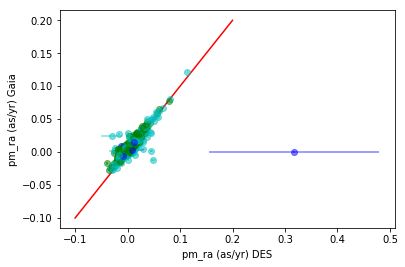

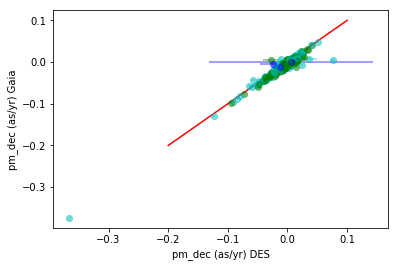

mu RA error (Gaia): median: 0.00059450346351 mean: 0.000819270213338
mu Dec error (Gaia): median: 0.000616899141183 mean: 0.000905533685722
mu RA difference: median: 0.00473516649744 mean: 0.00440218402356
mu Dec difference: median: -0.00355279809812 mean: -0.00354189225186


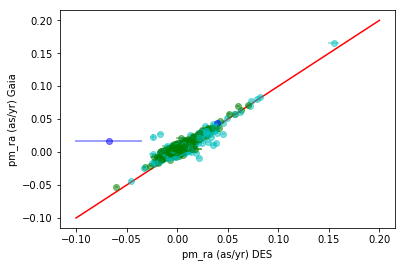

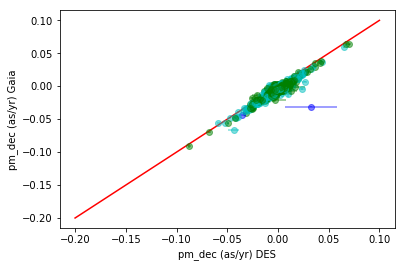

mu RA error (Gaia): median: 0.000601930888143 mean: 0.000828155319989
mu Dec error (Gaia): median: 0.000682617904378 mean: 0.000943527294773
mu RA difference: median: 0.00408562592646 mean: 0.00406420879466
mu Dec difference: median: -0.00392390001301 mean: -0.00402116893329


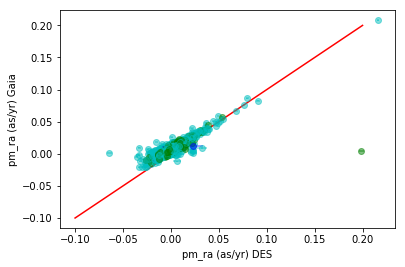

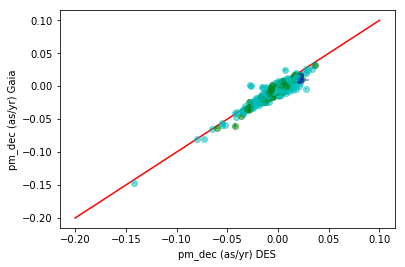

mu RA error (Gaia): median: 0.000667410676228 mean: 0.000881815367925
mu Dec error (Gaia): median: 0.000750120961601 mean: 0.00107229880147
mu RA difference: median: 0.00703705395423 mean: 0.0071981137358
mu Dec difference: median: -0.00402034078915 mean: -0.0040497371973


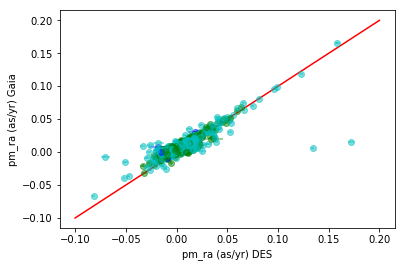

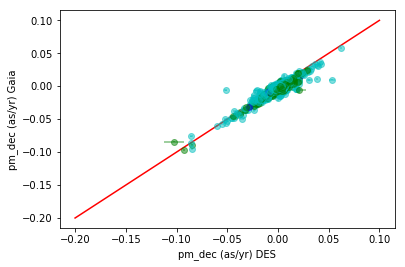

mu RA error (Gaia): median: 0.000593919414795 mean: 0.000806751410817
mu Dec error (Gaia): median: 0.000699897083864 mean: 0.00100316013141
mu RA difference: median: 0.00588494286726 mean: 0.00523905036033
mu Dec difference: median: -0.00335955407706 mean: -0.00339663613995


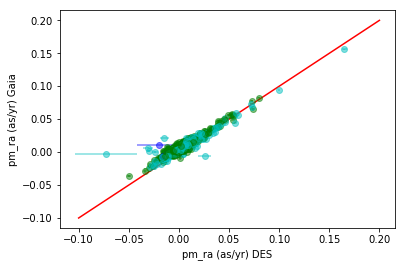

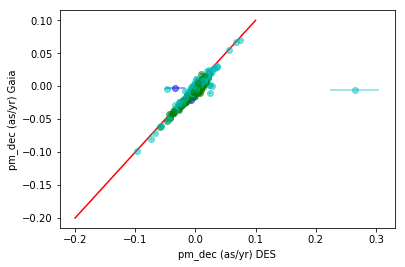

mu RA error (Gaia): median: 0.000627074474936 mean: 0.000869821484959
mu Dec error (Gaia): median: 0.000693250122852 mean: 0.000964002815562
mu RA difference: median: 0.00513161200015 mean: 0.00525409935777
mu Dec difference: median: -0.00404569412062 mean: -0.00433646673393


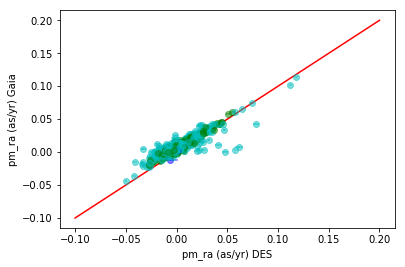

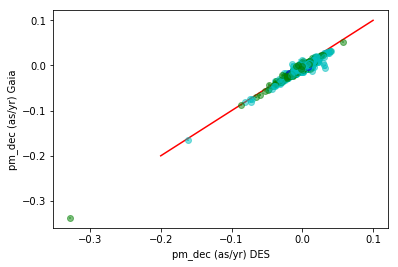

mu RA error (Gaia): median: 0.000606002735079 mean: 0.000830657616582
mu Dec error (Gaia): median: 0.000648912269762 mean: 0.000947267370877
mu RA difference: median: 0.00700788166157 mean: 0.00702799601378
mu Dec difference: median: -0.00485757013113 mean: -0.0048500983057


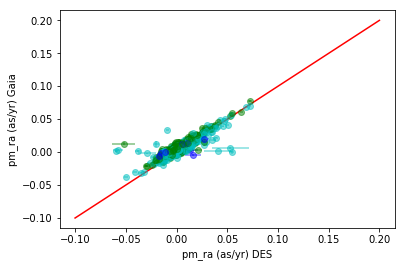

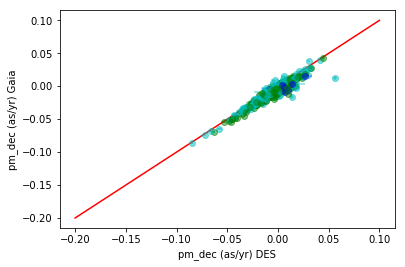

mu RA error (Gaia): median: 0.000602909988879 mean: 0.000850117178264
mu Dec error (Gaia): median: 0.000675400493014 mean: 0.000917932330661
mu RA difference: median: 0.00410115084118 mean: 0.00413763246268
mu Dec difference: median: -0.00356325489114 mean: -0.00378951263353


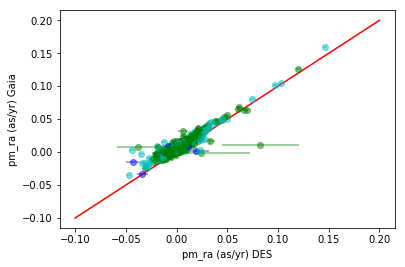

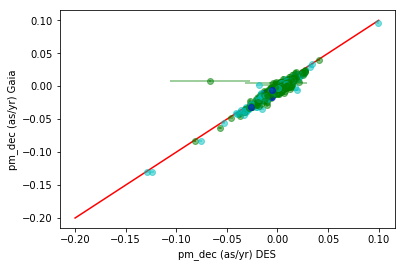

mu RA error (Gaia): median: 0.000626720014791 mean: 0.000891537169217
mu Dec error (Gaia): median: 0.000693505028034 mean: 0.00102844992565
mu RA difference: median: 0.00728312343134 mean: 0.00718817185277
mu Dec difference: median: -0.00382295361826 mean: -0.00387031574691


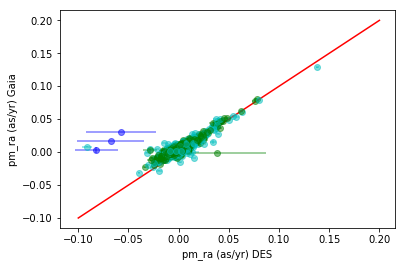

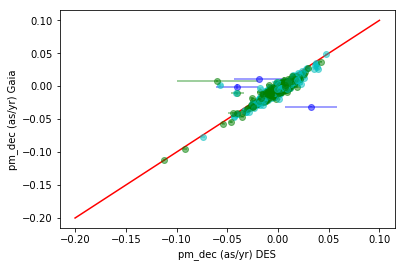

mu RA error (Gaia): median: 0.000591723684298 mean: 0.000825955097211
mu Dec error (Gaia): median: 0.000655148918432 mean: 0.000965964636501
mu RA difference: median: 0.00444959722434 mean: 0.00486688282207
mu Dec difference: median: -0.00398868186224 mean: -0.00400712266138


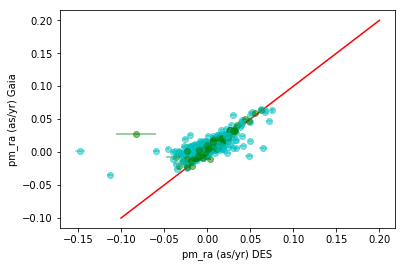

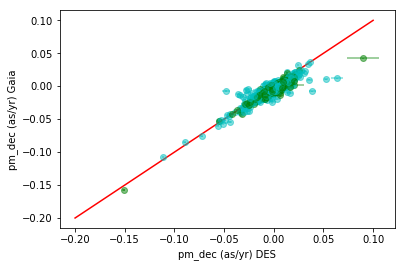

mu RA error (Gaia): median: 0.000609620922391 mean: 0.00081043869023
mu Dec error (Gaia): median: 0.000673811610704 mean: 0.000936623357943
mu RA difference: median: 0.00642789721855 mean: 0.00738714790744
mu Dec difference: median: -0.0039511756644 mean: -0.00392614738132


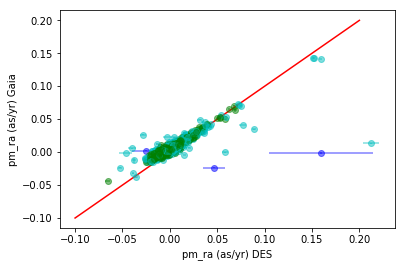

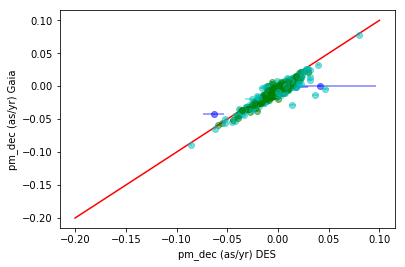

mu RA error (Gaia): median: 0.000621671584815 mean: 0.000861708772695
mu Dec error (Gaia): median: 0.000678860379981 mean: 0.000963425237452
mu RA difference: median: 0.00553938084212 mean: 0.00507238056028
mu Dec difference: median: -0.00477356701772 mean: -0.00501558661573


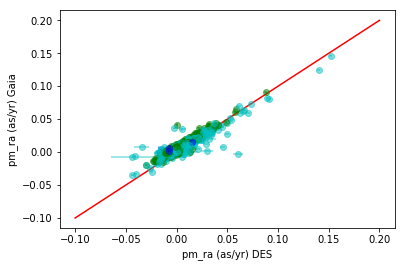

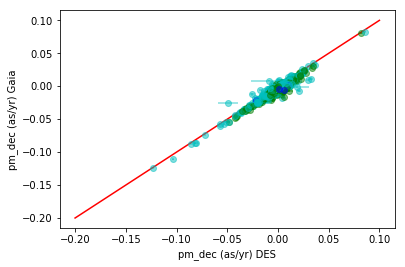

mu RA error (Gaia): median: 0.000543536456353 mean: 0.000764406611723
mu Dec error (Gaia): median: 0.000621739676161 mean: 0.000917099053089
mu RA difference: median: 0.00407598503524 mean: 0.0039095937095
mu Dec difference: median: -0.00387386755359 mean: -0.00392935153467


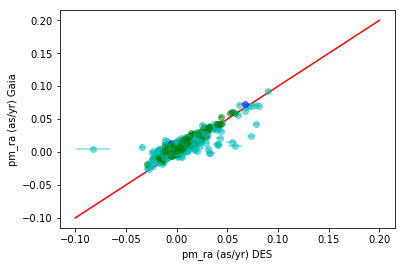

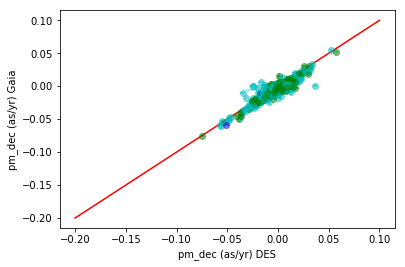

mu RA error (Gaia): median: 0.000574778176518 mean: 0.000835258777867
mu Dec error (Gaia): median: 0.000676712926379 mean: 0.000996481081675
mu RA difference: median: 0.00554036263304 mean: 0.00522086886097
mu Dec difference: median: -0.00390615028993 mean: -0.00366511763738


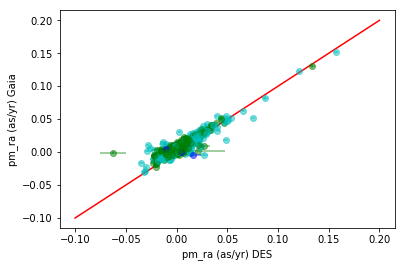

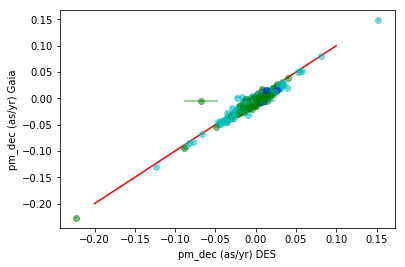

mu RA error (Gaia): median: 0.00059009086292 mean: 0.000837013046004
mu Dec error (Gaia): median: 0.000650090764716 mean: 0.000961717427706
mu RA difference: median: 0.00500376427502 mean: 0.00518388764664
mu Dec difference: median: -0.00371053387379 mean: -0.00369101768456


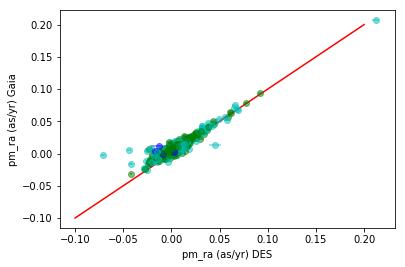

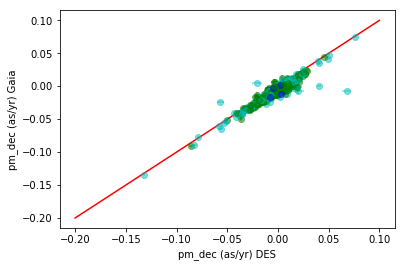

mu RA error (Gaia): median: 0.000567114178696 mean: 0.000813960011755
mu Dec error (Gaia): median: 0.000611740880966 mean: 0.000916806756045
mu RA difference: median: 0.00623953306786 mean: 0.0060488770316
mu Dec difference: median: -0.00479116343625 mean: -0.00491249773814


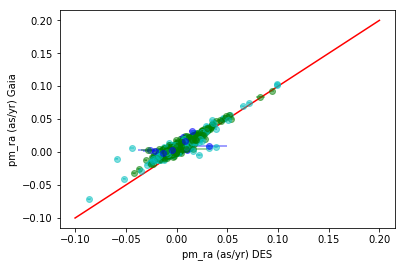

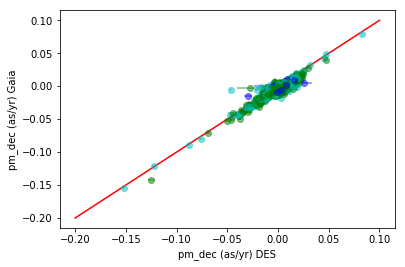

mu RA error (Gaia): median: 0.000640859662955 mean: 0.000851663221954
mu Dec error (Gaia): median: 0.000699308719641 mean: 0.000988012313588
mu RA difference: median: 0.00649872064463 mean: 0.00648636849985
mu Dec difference: median: -0.00320661295754 mean: -0.00334614769311


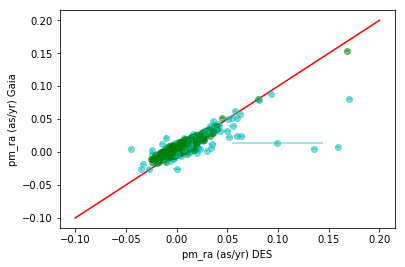

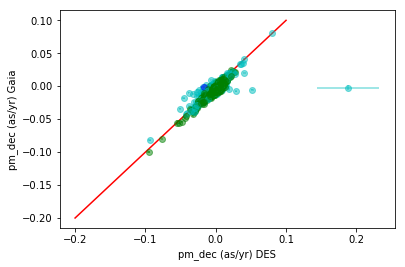

mu RA error (Gaia): median: 0.000643777865952 mean: 0.000874005941557
mu Dec error (Gaia): median: 0.000728836223252 mean: 0.00105344108859
mu RA difference: median: 0.00437576551554 mean: 0.00351029410372
mu Dec difference: median: -0.00288668709457 mean: -0.00290300325444


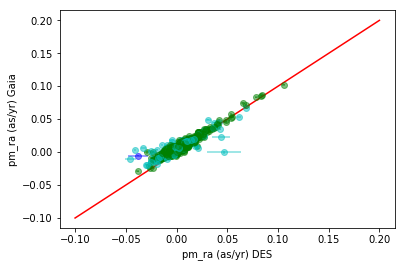

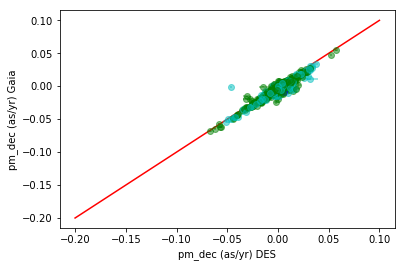

mu RA error (Gaia): median: 0.000580972060784 mean: 0.000812421972272
mu Dec error (Gaia): median: 0.000650698517989 mean: 0.000951357997646
mu RA difference: median: 0.00616823614442 mean: 0.00614634178279
mu Dec difference: median: -0.00373270793325 mean: -0.00377862222276


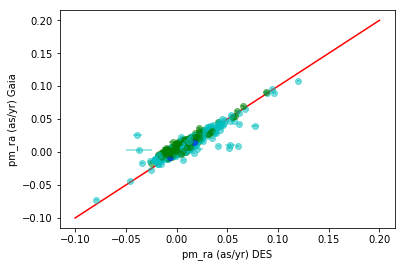

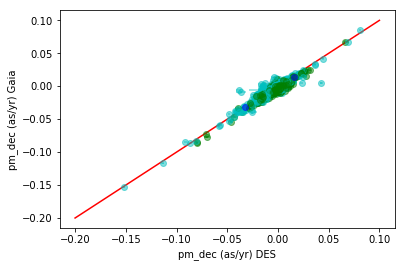

mu RA error (Gaia): median: 0.000594690938852 mean: 0.000805697521623
mu Dec error (Gaia): median: 0.000673916366427 mean: 0.000986531898421
mu RA difference: median: 0.0040076297878 mean: 0.00368538857698
mu Dec difference: median: -0.00199798847913 mean: -0.00162339917233


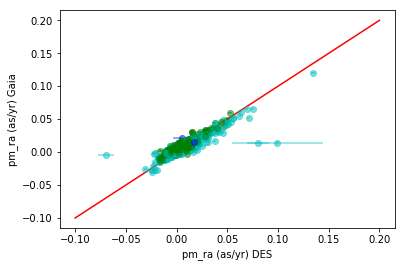

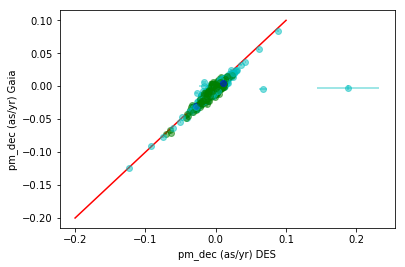

mu RA error (Gaia): median: 0.000570770650697 mean: 0.000774305268168
mu Dec error (Gaia): median: 0.000669464211616 mean: 0.000948245114219
mu RA difference: median: 0.00318124315743 mean: 0.00263346889361
mu Dec difference: median: -0.00336584974876 mean: -0.00341499788929


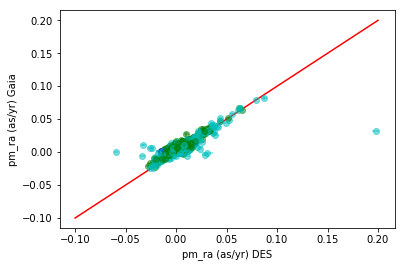

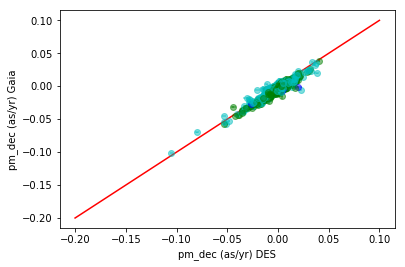

mu RA error (Gaia): median: 0.000626359916848 mean: 0.000828104674479
mu Dec error (Gaia): median: 0.000690932764647 mean: 0.000943178283134
mu RA difference: median: 0.00407365389616 mean: 0.00381723037822
mu Dec difference: median: -0.00300915065925 mean: -0.00299049769469


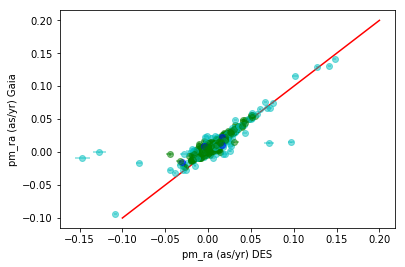

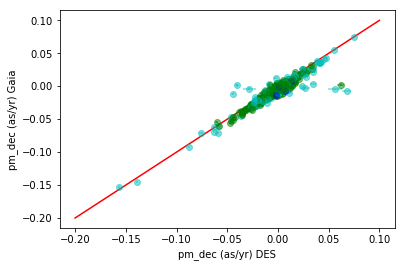

mu RA error (Gaia): median: 0.000595243975587 mean: 0.000824319545615
mu Dec error (Gaia): median: 0.000649933772651 mean: 0.000942078024059
mu RA difference: median: 0.00556127402251 mean: 0.00556870079261
mu Dec difference: median: -0.004008757276 mean: -0.0040755606401


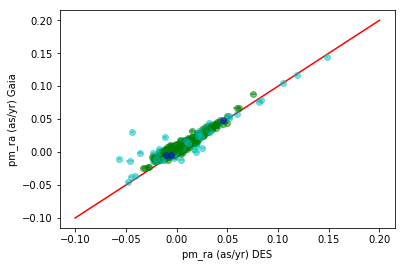

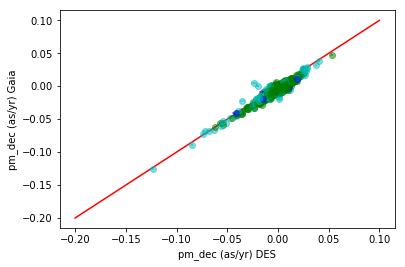

mu RA error (Gaia): median: 0.000624415063506 mean: 0.000838700596868
mu Dec error (Gaia): median: 0.000681682248104 mean: 0.000947989102195
mu RA difference: median: 0.00537213612068 mean: 0.00538879963788
mu Dec difference: median: -0.00366063401943 mean: -0.00361466146521


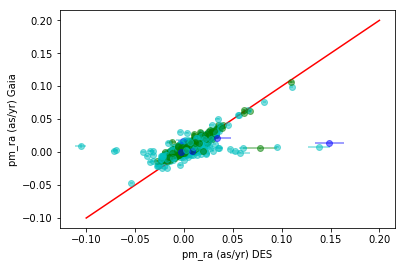

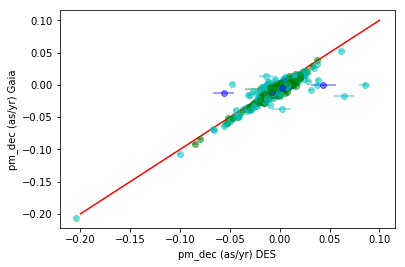

mu RA error (Gaia): median: 0.000598068499119 mean: 0.000811420575589
mu Dec error (Gaia): median: 0.000665367499097 mean: 0.000950008935026
mu RA difference: median: 0.00499122457331 mean: 0.00426510148905
mu Dec difference: median: -0.00485222087745 mean: -0.00468534446476


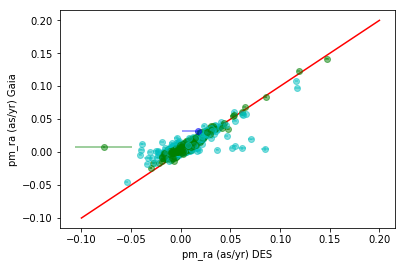

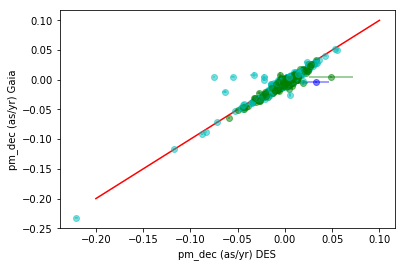

mu RA error (Gaia): median: 0.000629373081665 mean: 0.000863143648204
mu Dec error (Gaia): median: 0.0007374058582 mean: 0.00105498593398
mu RA difference: median: 0.00587363136581 mean: 0.00550971474716
mu Dec difference: median: -0.00372760776446 mean: -0.00366051189222


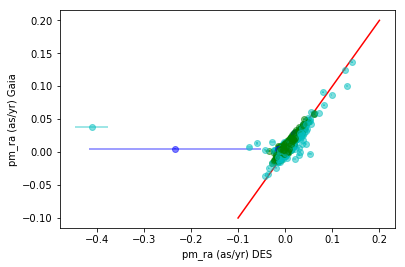

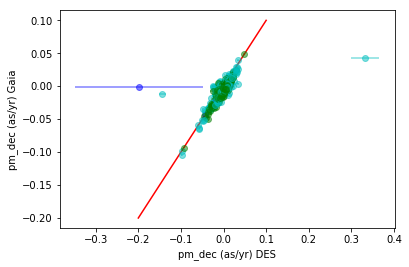

mu RA error (Gaia): median: 0.000577089365398 mean: 0.000794207194189
mu Dec error (Gaia): median: 0.000681563304791 mean: 0.000942142638073
mu RA difference: median: 0.00481583170331 mean: 0.00514145690747
mu Dec difference: median: -0.00394262887014 mean: -0.00348104879158


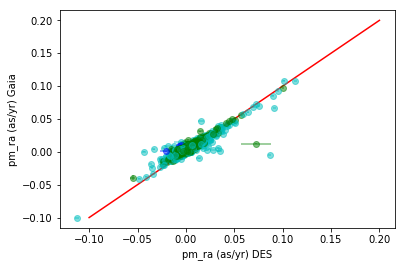

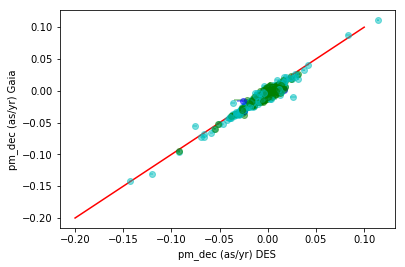

mu RA error (Gaia): median: 0.000606668727954 mean: 0.000860583863771
mu Dec error (Gaia): median: 0.000689652864705 mean: 0.000996452843535
mu RA difference: median: 0.0043388243265 mean: 0.00402008861199
mu Dec difference: median: -0.00345960212176 mean: -0.00354799439027


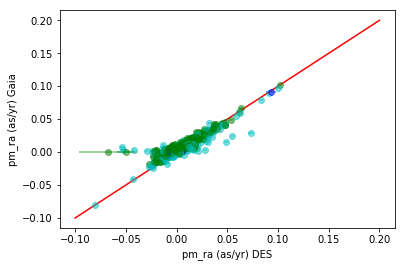

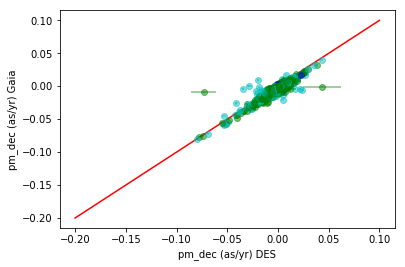

mu RA error (Gaia): median: 0.000629366707283 mean: 0.000817483161493
mu Dec error (Gaia): median: 0.000742052169039 mean: 0.00104174364482
mu RA difference: median: 0.00502318599581 mean: 0.00481154077078
mu Dec difference: median: -0.00371773939264 mean: -0.00356316210392


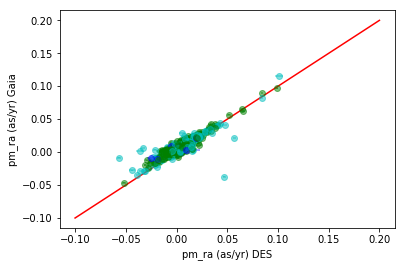

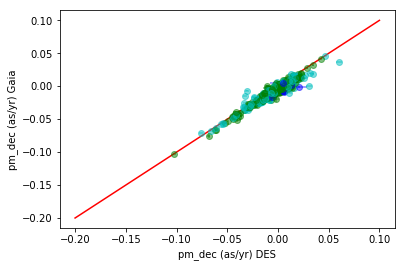

mu RA error (Gaia): median: 0.000598250531133 mean: 0.00080554643522
mu Dec error (Gaia): median: 0.000702358357822 mean: 0.000982472346807
mu RA difference: median: 0.00533940694264 mean: 0.0052294805419
mu Dec difference: median: -0.00434304128768 mean: -0.00417634773484


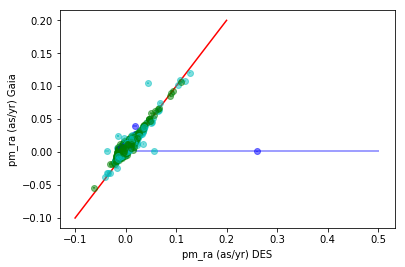

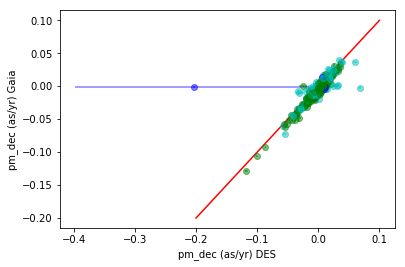

mu RA error (Gaia): median: 0.000578707198826 mean: 0.000822604872885
mu Dec error (Gaia): median: 0.000683786147625 mean: 0.00103657231807
mu RA difference: median: 0.00557275798272 mean: 0.00545694452149
mu Dec difference: median: -0.00453713871436 mean: -0.00437845263691


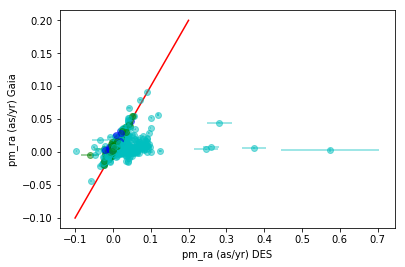

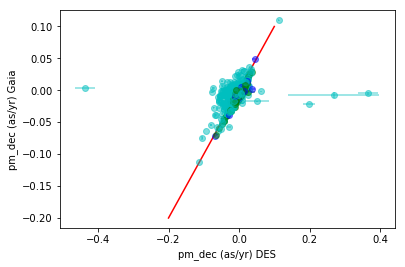

mu RA error (Gaia): median: 0.000652533711828 mean: 0.000882831596984
mu Dec error (Gaia): median: 0.000762765423504 mean: 0.00105216228379
mu RA difference: median: 0.00308973993826 mean: -0.00540888964896
mu Dec difference: median: -0.00210510050325 mean: 0.00108096707967


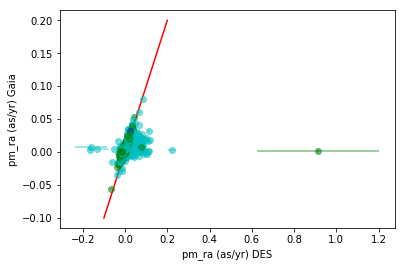

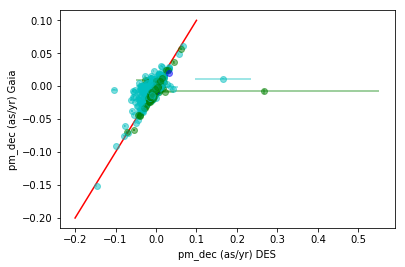

mu RA error (Gaia): median: 0.000590036712488 mean: 0.000818449219094
mu Dec error (Gaia): median: 0.000665015206293 mean: 0.000936851827402
mu RA difference: median: 0.00291435595197 mean: -0.00331256301506
mu Dec difference: median: -0.00131158282906 mean: 0.00138775330718


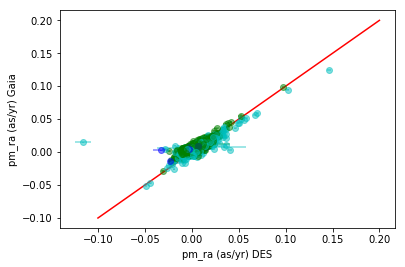

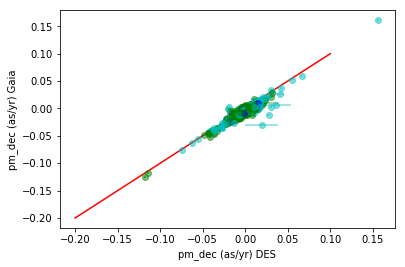

mu RA error (Gaia): median: 0.000634926512293 mean: 0.00086661271247
mu Dec error (Gaia): median: 0.000742212308238 mean: 0.00105463521962
mu RA difference: median: 0.00409746590164 mean: 0.00379088696789
mu Dec difference: median: -0.00396903349536 mean: -0.00407515731165


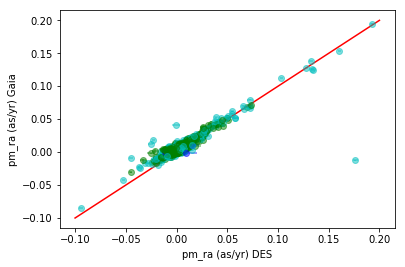

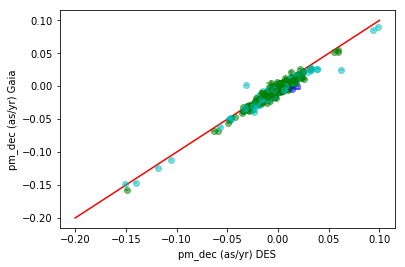

mu RA error (Gaia): median: 0.000549166392999 mean: 0.000789311451395
mu Dec error (Gaia): median: 0.000669292462956 mean: 0.000966440383863
mu RA difference: median: 0.00560574723495 mean: 0.00536712021037
mu Dec difference: median: -0.00428859199892 mean: -0.00426051649324


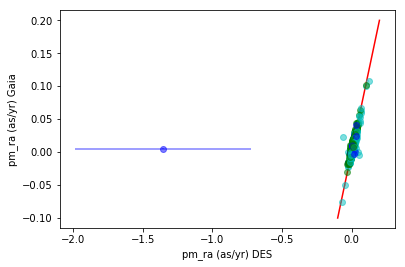

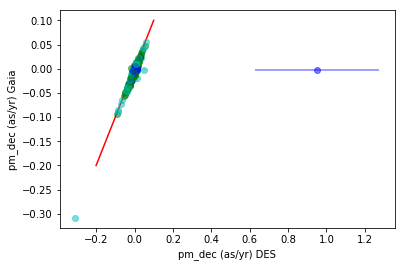

mu RA error (Gaia): median: 0.000545222829519 mean: 0.00077824165972
mu Dec error (Gaia): median: 0.000632448209818 mean: 0.00094288379207
mu RA difference: median: 0.00409310302556 mean: 0.00479320750717
mu Dec difference: median: -0.00369439943479 mean: -0.00449663719779


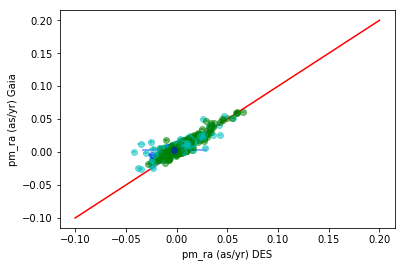

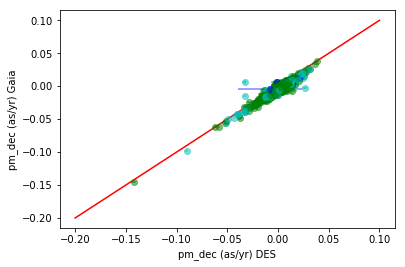

mu RA error (Gaia): median: 0.000594027442109 mean: 0.000834962003897
mu Dec error (Gaia): median: 0.000659606763079 mean: 0.000976591856698
mu RA difference: median: 0.00559882634964 mean: 0.00550696399947
mu Dec difference: median: -0.00428440119934 mean: -0.00434448807957


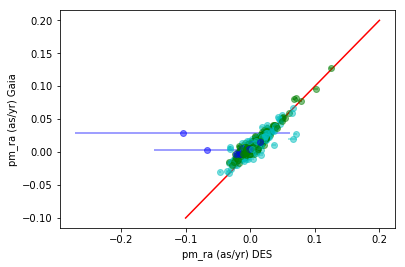

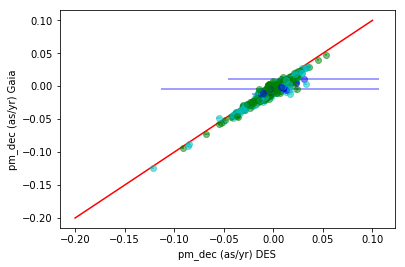

mu RA error (Gaia): median: 0.000632819676606 mean: 0.000824210471891
mu Dec error (Gaia): median: 0.000711933665962 mean: 0.000973560931954
mu RA difference: median: 0.00607983111357 mean: 0.00614293689349
mu Dec difference: median: -0.00446887022662 mean: -0.00457924535815


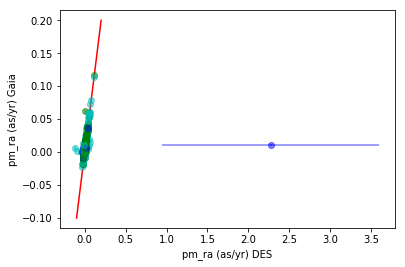

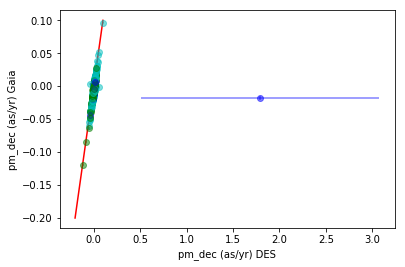

mu RA error (Gaia): median: 0.000607360909563 mean: 0.000852861277637
mu Dec error (Gaia): median: 0.000712893822039 mean: 0.00102964013626
mu RA difference: median: 0.00602128337481 mean: 0.00390442647004
mu Dec difference: median: -0.00447948796928 mean: -0.00610449801657


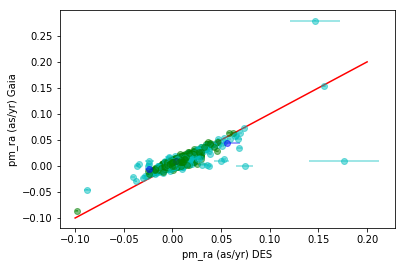

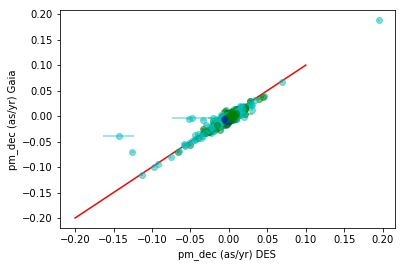

mu RA error (Gaia): median: 0.000609817604657 mean: 0.000822578872147
mu Dec error (Gaia): median: 0.000755544386313 mean: 0.00106417404932
mu RA difference: median: 0.00399880082024 mean: 0.00332458332612
mu Dec difference: median: -0.00243804419206 mean: -0.00216453028619


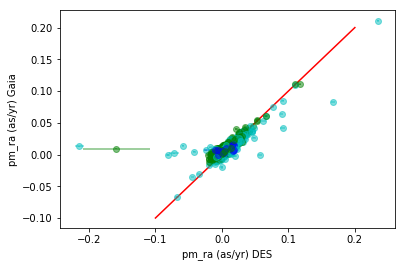

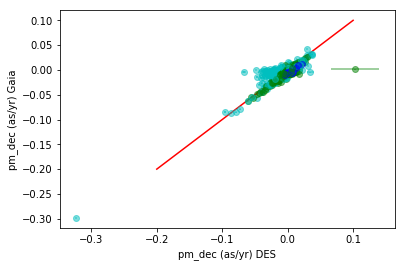

mu RA error (Gaia): median: 0.000594222150063 mean: 0.000786226006024
mu Dec error (Gaia): median: 0.000670780926935 mean: 0.000925758978483
mu RA difference: median: 0.00394044794363 mean: 0.00423718357394
mu Dec difference: median: -0.00309698366026 mean: -0.00227096495057


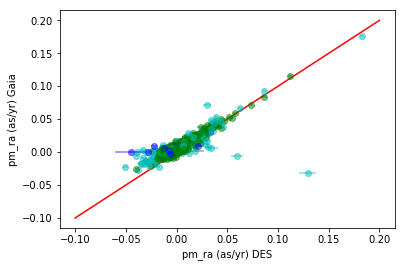

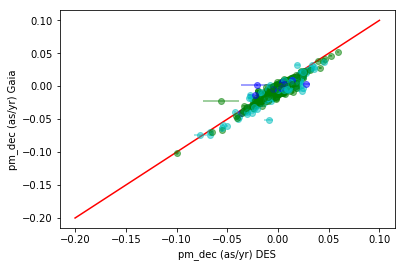

mu RA error (Gaia): median: 0.000582312213998 mean: 0.000855060996433
mu Dec error (Gaia): median: 0.000696776552413 mean: 0.00102851474953
mu RA difference: median: 0.00635741552408 mean: 0.00635196703535
mu Dec difference: median: -0.00471553853062 mean: -0.00478863339545


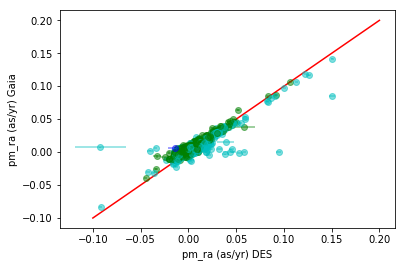

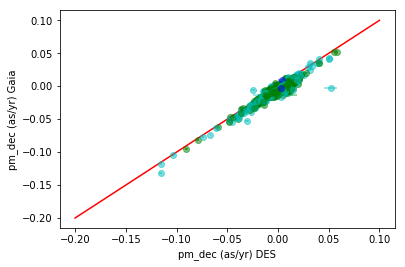

mu RA error (Gaia): median: 0.000618655132024 mean: 0.000842120574574
mu Dec error (Gaia): median: 0.000695554570753 mean: 0.000974766308608
mu RA difference: median: 0.00366282775827 mean: 0.00323066118109
mu Dec difference: median: -0.00442918510679 mean: -0.00457117756545


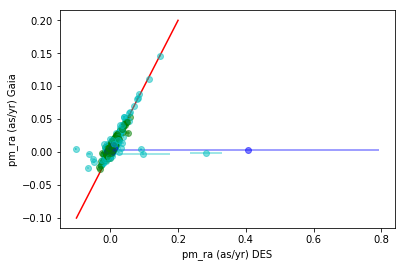

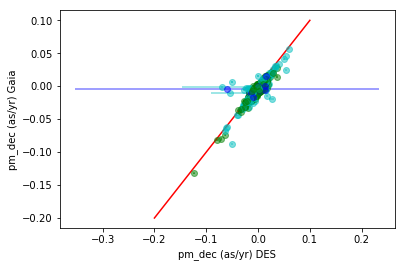

mu RA error (Gaia): median: 0.000650049418624 mean: 0.000841578346816
mu Dec error (Gaia): median: 0.000709147175052 mean: 0.00097393873795
mu RA difference: median: 0.00457706149344 mean: 0.00391173740075
mu Dec difference: median: -0.00343666022189 mean: -0.00344649419749


In [67]:
dicts2 = []
for i, tile in enumerate(tiles_55):
    dicts2.append(comparePM(tile, indices[i], g2))

In [70]:
matched[-4][np.where(matched[-4]['MU_DEC'] < -0.3)]

<Table length=1>
MATCH_ID   COADD_ID  ...          GAIA_MATCH           GAIA_MATCH_DIST 
float64    float64   ...            str50                  float64     
-------- ----------- ... ---------------------------- -----------------
  9894.0 358795173.0 ... Gaia DR2 5100228480944959744 6.31767671049e-09

NameError: name 'z_55' is not defined

In [158]:
# Is Parallax our problem?
para = []
for row in matched[-12]:
    gaia = g2[np.where(g2['designation'] == row['GAIA_MATCH'])]
    para.append(gaia['parallax'].data.data[0])

0.650946887617 mas


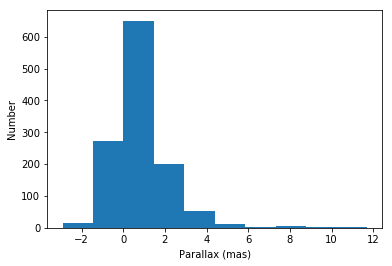

In [163]:
print(median(para), 'mas')
plt.hist(para)
plt.xlabel('Parallax (mas)')
plt.ylabel('Number')
plt.show()

In [172]:
para = np.array(para)
matched[-12][np.where(para > 7)]

<Table length=8>
MATCH_ID   COADD_ID  ...          GAIA_MATCH           GAIA_MATCH_DIST 
float64    float64   ...            str50                  float64     
-------- ----------- ... ---------------------------- -----------------
   448.0 351554531.0 ... Gaia DR2 5099349975449558656 2.11087077354e-09
   519.0 353472202.0 ... Gaia DR2 5099266446924546304 2.65013824084e-09
  1308.0 351548846.0 ... Gaia DR2 5099412986914967680 4.88682757297e-09
  4771.0 351532680.0 ... Gaia DR2 5099428453091941888 3.65216820009e-09
  6666.0 351531893.0 ... Gaia DR2 5099404504354278400 2.98896969411e-09
  6728.0 351539793.0 ... Gaia DR2 5099419377826346112 3.10157174127e-09
  6879.0 351543476.0 ... Gaia DR2 5099415907492759680 2.87687102836e-09
 11367.0 351555772.0 ... Gaia DR2 5099349730636587904  2.3479957626e-09

In [318]:
matched[-12][np.where(matched[-12]['CHI2_RED'] > 3)]

<Table length=706>
MATCH_ID   COADD_ID  ...          GAIA_MATCH           GAIA_MATCH_DIST 
float64    float64   ...            str50                  float64     
-------- ----------- ... ---------------------------- -----------------
     0.0 351553055.0 ... Gaia DR2 5099361928343224832 2.31315825106e-09
    14.0 351552119.0 ... Gaia DR2 5099362207516416640 2.22578010291e-09
    15.0 351551821.0 ... Gaia DR2 5099362203221139840 1.77900460556e-09
    19.0 351552080.0 ... Gaia DR2 5099362241876155520 2.12006455184e-09
    38.0 351551591.0 ... Gaia DR2 5099362959135883008 1.97507698782e-09
    51.0 351549732.0 ... Gaia DR2 5099363302732779776 2.50740905751e-09
    54.0 351552142.0 ... Gaia DR2 5099367876873246592 1.78877053544e-09
    55.0 351552212.0 ... Gaia DR2 5099367876872394496 2.23198047887e-09
    78.0 351552016.0 ... Gaia DR2 5099362787337189888 2.58926883238e-09
    82.0 351550247.0 ... Gaia DR2 5099368048671937152 1.74040620543e-09
     ...         ... ...                          ...               ...
 17661.0 351557153.0 ... Gaia DR2 5099270295216216960 6.38692789195e-10
 19676.0 351537552.0 ... Gaia DR2 5099432095224171648 3.56732573216e-09
 19677.0 351537433.0 ... Gaia DR2 5099432060864433792 3.27963625682e-09
 26928.0 351529247.0 ... Gaia DR2 5099449687410238080 2.32558187837e-09
 27020.0 351537370.0 ... Gaia DR2 5099432095224221824 3.43690165371e-09
 27550.0 351524840.0 ... Gaia DR2 5099465286730427008 3.26064779837e-09
 28360.0 351545550.0 ... Gaia DR2 5099416702061437056 4.27599683228e-09
 28374.0 351528871.0 ... Gaia DR2 5099450065367358976 2.36521171065e-09
 28687.0 351525987.0 ... Gaia DR2 5099455356766121088 2.29633877211e-09
 29583.0 351545590.0 ... Gaia DR2 5099358904686308224 2.46966739924e-09

In [173]:
sus55 = Table.read('DES0319-2206_final.fits')

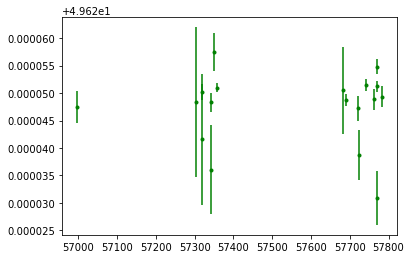

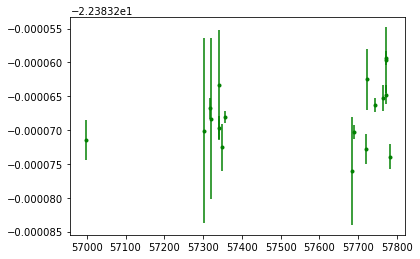

In [245]:
for row in sus55[np.where((sus55['MATCH_ID'] == 17643) & (sus55['IMAFLAGS_ISO'] == 0))]:
    plt.errorbar(row['MJD_OBS'], row['NEW_RA'],yerr=row['ERRAWIN_WORLD'], fmt='g.')
plt.show()
for row in sus55[np.where((sus55['MATCH_ID'] == 17643) & (sus55['IMAFLAGS_ISO'] == 0))]:
    plt.errorbar(row['MJD_OBS'], row['NEW_DEC'],yerr=row['ERRAWIN_WORLD'], fmt='g.')
plt.show()

In [164]:
para2 = []
for row in matched[4]:
    gaia = g2[np.where(g2['designation'] == row['GAIA_MATCH'])]
    para2.append(gaia['parallax'].data.data[0])

0.602718026464 mas


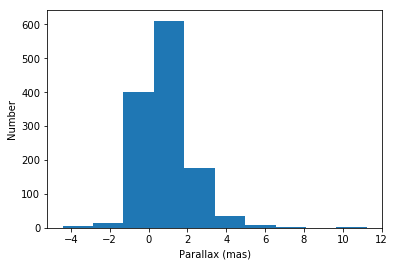

In [165]:
print(median(para2), 'mas')
plt.hist(para2)
plt.xlabel('Parallax (mas)')
plt.ylabel('Number')
plt.show()

## High Chi-square_red concentrations

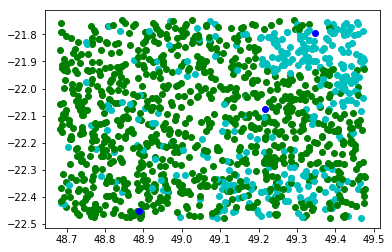

In [317]:
for row in matched[29]:
    plt.plot(row['RA'], row['DEC'], colorPoint(row['CHI2_RED'], row['N']))
plt.show()

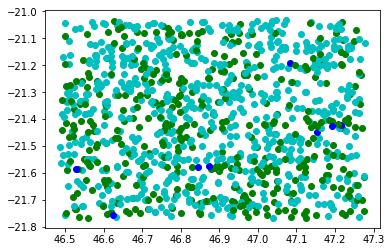

In [373]:
for row in matched[7]:
    plt.plot(row['RA'], row['DEC'], colorPoint(row['CHI2_RED'], row['N']))
plt.show()

In [321]:
filenames[7]

'/Users/Suyog/Documents/GitHub/DES-Proper-Motion/zone029/DES0138-0416_proper.fits'

In [287]:
lowc = []
highc = []
for row in matched[-12]:
    cod = sus55[np.where((sus55['MATCH_ID'] == row['MATCH_ID']) & (sus55['VERSION'] == 'COADD'))]
    if row['CHI2_RED'] > 3:
        highc.append(cod['MAG_AUTO_G'].data[0])
    else:
        lowc.append(cod['MAG_AUTO_G'].data[0])
    #plt.plot(cod['MAG_AUTO_G'], cod['MAG_AUTO_I'], colorPoint(row['CHI2_RED'], row['N']))


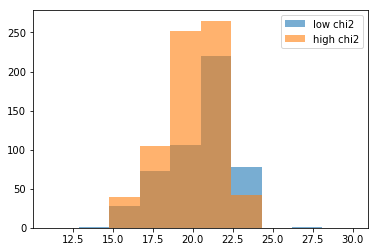

In [291]:
plt.hist(lowc, range=(11,30), alpha = 0.6, label = 'low chi2')
plt.hist(highc, range=(11,30), alpha=0.6, label = 'high chi2')
plt.legend()
plt.show()

## Gaia Matched Magnitude-wise PM error trends

In [42]:
mags = []
g_mags = []
ra_errors = []
dec_errors = []
gra_errors = []
gdec_errors = []
def pm_err_bymag(tile, gaia, final):
    for row in tile:
        coadd = final[np.where((final['MATCH_ID'] == row['MATCH_ID']) & (final['VERSION'] == 'COADD'))]
        g_mag = coadd['MAG_AUTO_G']
        i_mag = coadd['MAG_AUTO_I']
        if len(g_mag) == 1:
            G = g_mag -0.1115 -0.5263*(g_mag - i_mag) - 0.0869*(g_mag-i_mag)**2 +0.0025*(g_mag-i_mag)**3
            mags.append(G)
            ra_errors.append(np.sqrt(row['MU_RA_ERR']))
            dec_errors.append(np.sqrt(row['MU_DEC_ERR']))
            # gaia matched
            #g = gaia[np.where(gaia['designation'] == row['GAIA_MATCH'])]
            #gra_errors.append(g['pmra_error'])
            #gdec_errors.append(g['pmdec_error'])
    #ALL GAIA
    for i, row in enumerate(gaia):
        if gaia['pmra_error'].mask[i] == False:
            g_mags.append(row['phot_g_mean_mag'])
            gra_errors.append(row['pmra_error'])
            gdec_errors.append(row['pmdec_error'])

In [43]:
pm_err_bymag(tiles_n[0], g, fin)

In [6]:
g = Table.read('Gaia-Z29.csv')
max(g['phot_g_mean_mag'])

21.430235

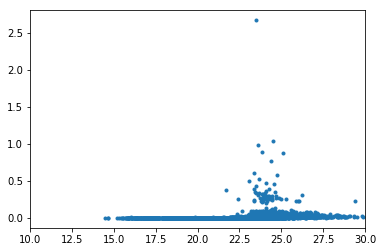

In [99]:
plt.plot(mags, ra_errors, '.')
plt.xlim(10, 30)
plt.show()

In [44]:
ranges = list(range(11,31))

In [45]:
ra_med = []
gra_med = []
dec_med = []
gdec_med = []
for i in range(19):
    idx = [j for j,v in enumerate(mags) if ((mags[j] > ranges[i]) & (mags[j] < ranges[i+1]))]
    if len(idx) != 0:
        m = median(np.array(ra_errors)[idx])
        ra_med.append(m)
        m3 = median(np.array(dec_errors)[idx])
        dec_med.append(m3)
    else:
        ra_med.append(-10)
        dec_med.append(-10)
    idx2 = [j for j,v in enumerate(g_mags) if ((g_mags[j] > ranges[i]) & (g_mags[j] < ranges[i+1]))]
    if len(idx2) != 0:
        tgt = np.array(gra_errors)[idx2]
        tgt = [k for j,k in enumerate(tgt) if k != 'masked']
        m2 = median(tgt)
        gra_med.append(m2/1000)
        tgt2 = np.array(gdec_errors)[idx2]
        tgt2 = [k for j,k in enumerate(tgt2) if k != 'masked']
        m4 = median(tgt2)
        gdec_med.append(m4/1000)
    else:
        gra_med.append(-10)
        gdec_med.append(-10)

In [53]:
tiles_n[0]

<Table length=11659>
MATCH_ID COADD_OBJECT_ID    SPREAD_MODEL   ...   MAG_AUTO_Z    MAG_AUTO_Y 
float64      float64          float64      ...    float64       float64   
-------- --------------- ----------------- ... ------------- -------------
     1.0     233002478.0  -0.0042734220624 ...  18.362947464 18.2619285583
     3.0     233002634.0  0.00328959245235 ... 22.1755332947 21.7814445496
     4.0     227624387.0 -0.00321618909948 ... 22.1103286743 21.8544616699
     5.0     233002531.0 -0.00245652813464 ... 18.2774925232 18.1537818909
     6.0     233002490.0 -0.00123213988263 ... 19.3319206238 19.1443862915
    10.0     233002270.0 -0.00131305796094 ... 20.4046916962 20.4746112823
    11.0     233002838.0 -0.00326508120634 ... 22.7256946564 22.4581623077
    12.0     233002643.0  0.00401662476361 ... 21.8706741333 21.6840343475
    14.0     229838864.0  0.00784293841571 ... 21.8692092896   22.47605896
    16.0     233002371.0 -0.00522769335657 ... 22.8061714172 21.9392910004
     ...             ...               ... ...           ...           ...
 23922.0     233018569.0  0.00388138485141 ... 22.7038078308 23.0049362183
 23945.0     233026129.0  0.00157985510305 ... 23.9147872925 23.0429592133
 23959.0     233030117.0   0.0066023315303 ... 23.0540332794          99.0
 23963.0     228494189.0   0.0120804337785 ... 22.5930309296  22.306476593
 23975.0     233033574.0 -0.00269794673659 ... 23.7291469574  23.320684433
 23997.0     233009741.0  0.00266564777121 ...  18.961856842  18.472946167
 24348.0     233018264.0   0.0122544681653 ... 22.7111682892 23.6267185211
 24364.0     233024277.0  0.00798278301954 ... 22.3342456818 24.4501152039
 24379.0     233021903.0  0.00657321512699 ... 22.5356235504 23.5980243683
 24437.0     233028863.0  0.00767834344879 ... 22.1077384949 21.0943279266

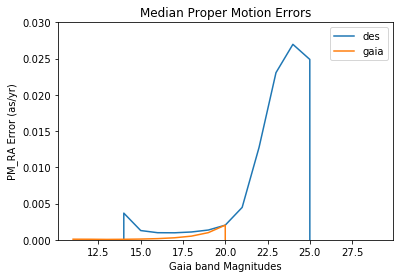

In [51]:
plt.plot(ranges[0:19], ra_med, label = 'des')
plt.plot(ranges[0:19], gra_med, label = 'gaia')
plt.ylim(0, 0.030)
plt.legend()
plt.title('Median Proper Motion Errors')
plt.xlabel('Gaia band Magnitudes')
plt.ylabel('PM_RA Error (as/yr)')
plt.show()

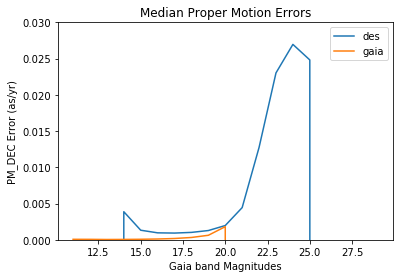

In [52]:
plt.plot(ranges[0:19], dec_med, label = 'des')
plt.plot(ranges[0:19], gdec_med, label = 'gaia')
plt.ylim(0, 0.030)
plt.legend()
plt.title('Median Proper Motion Errors')
plt.xlabel('Gaia band Magnitudes')
plt.ylabel('PM_DEC Error (as/yr)')
plt.show()

## Blacklists

In [319]:
blacklist = Table.read('blacklisted_expo.fits')

<Table masked=True length=72666>
        designation               source_id      ...  teff_val a_g_val
           str28                    int64        ...  float64  float64
---------------------------- ------------------- ... --------- -------
Gaia DR2 2467959886991365632 2467959886991365632 ...        --      --
Gaia DR2 2467840723123420672 2467840723123420672 ...        --      --
Gaia DR2 2467840516964792064 2467840516964792064 ...        --      --
Gaia DR2 2467920545090923776 2467920545090923776 ...        --      --
Gaia DR2 2467798980336607104 2467798980336607104 ...        --      --
Gaia DR2 2467950300624414976 2467950300624414976 ...    5044.0   0.016
Gaia DR2 2467812960458008320 2467812960458008320 ...        --      --
Gaia DR2 2467958512601829376 2467958512601829376 ...        --      --
Gaia DR2 2467886185352629760 2467886185352629760 ... 4279.1997   0.307
Gaia DR2 2467957103852556928 2467957103852556928 ...   5831.75  0.2057
                         ...                 ... ...       ...     ...
Gaia DR2 2505223843589910656 2505223843589910656 ...        --      --
Gaia DR2 2505238755716387072 2505238755716387072 ...   5779.25  1.9287
Gaia DR2 2505285420536369920 2505285420536369920 ...    3669.0   0.419
Gaia DR2 2505433747231603712 2505433747231603712 ...        --      --
Gaia DR2 2505208557801756032 2505208557801756032 ...  4902.785  0.1107
Gaia DR2 2505209210636149120 2505209210636149120 ...        --      --
Gaia DR2 2505449243474000128 2505449243474000128 ...        --      --
Gaia DR2 2505428735005166464 2505428735005166464 ...        --      --
Gaia DR2 2505432510280793856 2505432510280793856 ...        --      --
Gaia DR2 2505425569614353792 2505425569614353792 ...        --      --

In [363]:
blacklist.group_by('REASON').groups.keys

<Table length=56>
            REASON            
            str30             
------------------------------
4map problems                 
Airplane/Streak               
All zero                      
BADSPREADMODEL                
BAD_READ                      
Bad coma in donuts            
Bad readout                   
Blank                         
BlankImage                    
CloudPlusBackground           
                           ...
Y1A1 corrupt image            
Y3A1 Astrometry Failure       
Y3A1_astrom_fail              
catalog failure               
double                        
double/elongated              
geosync/Streak                
no stars                      
telescope moved               
z-domeflat shutter problem

In [322]:
junk = Table.read('zone029/zone029_junk.fits')

In [358]:
"{:0>3}".format(29)

'029'

In [347]:
lst = []
for i,row in enumerate(fin):
    x = np.where((row['EXPNUM'] == junk['EXPNUM']) & (row['CCDNUM'] == junk['CCDNUM']))
    if len(x) > 0:
        lst.append(i)

In [348]:
fin[lst]

<Table length=329164>
    RA       DEC      ERRAWIN_WORLD   ...     NEW_RA       NEW_DEC    
 float64   float64       float64      ...    float64       float64    
--------- --------- ----------------- ... ------------- --------------
23.478404 -3.915761 3.88414009649e-05 ... 23.4785317028 -3.91586355064
23.478435 -3.915774 2.99015991914e-05 ... 23.4784762788  -3.9157543522
 23.47843 -3.915789 1.85788994713e-05 ... 23.4784491716 -3.91578969938
23.478463 -3.915821 1.44384002851e-05 ... 23.4784637679 -3.91581501044
 23.47848 -3.915791 1.69454997376e-05 ... 23.4784791819 -3.91578291251
23.478446 -3.915816 1.74407996383e-05 ... 23.4784428849 -3.91581602488
 23.47838 -3.915759 3.00328993035e-05 ...  23.478437684 -3.91579263307
23.478498 -3.915769  4.3488900701e-05 ... 23.4784766579 -3.91580153506
23.478429 -3.915829 2.41762008955e-05 ... 23.4784367947 -3.91582319918
23.478402 -3.915739 1.31875003717e-05 ... 23.4784466743 -3.91578771195
      ...       ...               ... ...           ...            ...
24.090618 -3.900349             1e+20 ... 24.0906178439 -3.90034875142
24.111057 -3.900915             1e+20 ... 24.1110570021 -3.90091514349
24.151038 -3.900094             1e+20 ... 24.1510382421 -3.90009408016
24.120613 -3.902156             1e+20 ... 24.1206131985 -3.90215554865
24.123747 -3.898512             1e+20 ... 24.1237471337 -3.89851163624
24.131873 -3.908102             1e+20 ... 24.1318729772 -3.90810191207
24.132641 -3.906255             1e+20 ... 24.1326414828 -3.90625532916
24.142071 -3.908399             1e+20 ... 24.1420708188 -3.90839884064
24.144227 -3.898669             1e+20 ...  24.144227114 -3.89866904064
24.147794 -3.899224             1e+20 ... 24.1477942318 -3.89922398673

In [374]:
#filenames2[36]
filenames2[7]

'/Users/Suyog/Documents/GitHub/DES-Proper-Motion/zone055/DES0307-2124_proper_n.fits'

In [412]:
fin

<Table length=329164>
    RA       DEC      ERRAWIN_WORLD   ...     NEW_RA       NEW_DEC    
 float64   float64       float64      ...    float64       float64    
--------- --------- ----------------- ... ------------- --------------
23.478404 -3.915761 3.88414009649e-05 ... 23.4785317028 -3.91586355064
23.478435 -3.915774 2.99015991914e-05 ... 23.4784762788  -3.9157543522
 23.47843 -3.915789 1.85788994713e-05 ... 23.4784491716 -3.91578969938
23.478463 -3.915821 1.44384002851e-05 ... 23.4784637679 -3.91581501044
 23.47848 -3.915791 1.69454997376e-05 ... 23.4784791819 -3.91578291251
23.478446 -3.915816 1.74407996383e-05 ... 23.4784428849 -3.91581602488
 23.47838 -3.915759 3.00328993035e-05 ...  23.478437684 -3.91579263307
23.478498 -3.915769  4.3488900701e-05 ... 23.4784766579 -3.91580153506
23.478429 -3.915829 2.41762008955e-05 ... 23.4784367947 -3.91582319918
23.478402 -3.915739 1.31875003717e-05 ... 23.4784466743 -3.91578771195
      ...       ...               ... ...           ...            ...
24.090618 -3.900349             1e+20 ... 24.0906178439 -3.90034875142
24.111057 -3.900915             1e+20 ... 24.1110570021 -3.90091514349
24.151038 -3.900094             1e+20 ... 24.1510382421 -3.90009408016
24.120613 -3.902156             1e+20 ... 24.1206131985 -3.90215554865
24.123747 -3.898512             1e+20 ... 24.1237471337 -3.89851163624
24.131873 -3.908102             1e+20 ... 24.1318729772 -3.90810191207
24.132641 -3.906255             1e+20 ... 24.1326414828 -3.90625532916
24.142071 -3.908399             1e+20 ... 24.1420708188 -3.90839884064
24.144227 -3.898669             1e+20 ...  24.144227114 -3.89866904064
24.147794 -3.899224             1e+20 ... 24.1477942318 -3.89922398673

In [84]:
bd = Table.read('DES_Y3_known_BDs_with_motions.fits')

In [85]:
bd

<Table masked=True length=146>
 PSF_MAG_ERR_G   PSF_MAG_ERR_R   ...   Separation  
                                 ...     arcsec    
    float64         float64      ...    float64    
--------------- ---------------- ... --------------
 -1.11009319209    3.55240458275 ...  6.03531335978
0.0206906705416 0.00321587355841 ...  1.43748202965
 0.188395451973  0.0520005799501 ...  2.25333336248
  1.73503580833  0.0234711118177 ...   2.9298902501
 0.105551053431 0.00815470563715 ...  6.91765836587
 0.146304371604  0.0107884771499 ... 0.726997221718
 0.758372880435   0.017821507161 ...  2.62090669862
  1.27077136517  0.0711398931389 ...  1.97114132894
0.0277541587279 0.00530419358861 ...  3.75547744536
            ...              ... ...            ...
-0.582893952061  -0.185688230501 ...  1.77809530126
 0.220578437979  0.0148431364679 ... 0.471023538468
  2.17836033426   0.671343037638 ...   1.5572212665
 0.719681929771  0.0864700590719 ... 0.331352468358
 0.319995735309  0.0415829651222 ...  1.77050390556
 0.266963887461  0.0296311244214 ...   1.4869881338
 0.527988966204  0.0933928759671 ...  1.66815685937
  2.45661005126   0.128318531451 ...  1.71378235681
 0.448406316789  0.0695287588887 ...    3.128603524
-0.136370726984    3.30191056549 ...  5.40658406365

In [86]:
z_list = []
def zone_matcher(RA,Dec,row):
    tgt = zones[np.where((zones['RACMAX'] > RA) & (zones['RACMIN'] < RA) & (zones['DECCMAX'] > Dec) & (zones['DECCMIN'] < Dec))]
    zone = tgt['ZONE']
    tile = tgt['TILE']
    if (len(zone) != 0):
        #z_list.append(zone[0])
        if (zone[0] == 29):
            print(tgt)
            #print('Tile:', tile)
            #print(row['COADD_OBJECT_ID'])

In [87]:
for row in bd:
    zone_matcher(row['RA'],row['DEC'], row)

ZONE     TILE     GROUP_NAME   TILENAME   ...  DECCMAX    RACMIN    RACMAX 
---- ------------ ---------- ------------ ... --------- --------- ---------
  29 DES0137-0333  footprint DES0137-0333 ... -3.187477 24.069235 24.801404
ZONE     TILE     GROUP_NAME   TILENAME   ...  DECCMAX    RACMIN    RACMAX 
---- ------------ ---------- ------------ ... --------- --------- ---------
  29 DES0143-0707  footprint DES0143-0707 ... -6.756848 25.425412 26.162152
  29 DES0146-0707  footprint DES0146-0707 ... -6.756848 26.144853 26.881592


In [89]:
#z_list.sort()

In [484]:
r = tiles_n[5][np.where(tiles_n[5]['COADD_OBJECT_ID'] ==234381048)]
#268493828
r

<Table length=1>
MATCH_ID COADD_OBJECT_ID    SPREAD_MODEL   ... GAIA_MATCH GAIA_MATCH_DIST
float64      float64          float64      ...   str50        float64    
-------- --------------- ----------------- ... ---------- ---------------
  7781.0     234381048.0 0.000483208714286 ...                        0.0

In [458]:
bd[np.where(bd['COADD_OBJECT_ID'] == 234381048.0)]

<Table masked=True length=1>
PSF_MAG_ERR_G PSF_MAG_ERR_R  ...   Separation 
                             ...     arcsec   
   float64       float64     ...    float64   
------------- -------------- ... -------------
1.07235748043 0.374038478181 ... 1.93643477638

In [463]:
tiles_n[21][np.where(tiles_n[21]['COADD_OBJECT_ID'] ==268493828)]

<Table length=1>
MATCH_ID COADD_OBJECT_ID ...          GAIA_MATCH           GAIA_MATCH_DIST 
float64      float64     ...            str50                  float64     
-------- --------------- ... ---------------------------- -----------------
 13061.0     268493828.0 ... Gaia DR2 2467182154313027712 6.32988771045e-09

In [489]:
g[np.where(g['designation'] == 'Gaia DR2 2467182154313027712')]

<Table masked=True length=1>
        designation               source_id      ... teff_val a_g_val
           str28                    int64        ... float64  float64
---------------------------- ------------------- ... -------- -------
Gaia DR2 2467182154313027712 2467182154313027712 ...       --      --

In [464]:
bd[np.where(bd['COADD_OBJECT_ID'] == 268493828.0)]

<Table masked=True length=1>
PSF_MAG_ERR_G   PSF_MAG_ERR_R  ...   Separation 
                               ...     arcsec   
   float64         float64     ...    float64   
-------------- --------------- ... -------------
0.316235782582 0.0141261143262 ... 7.06697427309

In [479]:
tiles_55[9][np.where(tiles_55[9]['COADD_ID'] == 343338662)]

<Table length=1>
MATCH_ID   COADD_ID  ...          GAIA_MATCH           GAIA_MATCH_DIST 
float64    float64   ...            str50                  float64     
-------- ----------- ... ---------------------------- -----------------
  2615.0 343338662.0 ... Gaia DR2 5103855671020268032 9.26994620683e-09

In [491]:
g2[np.where(g2['designation'] == 'Gaia DR2 5103855671020268032')]

<Table masked=True length=1>
        designation               source_id      ... teff_val a_g_val
           str28                    int64        ... float64  float64
---------------------------- ------------------- ... -------- -------
Gaia DR2 5103855671020268032 5103855671020268032 ...       --      --

In [480]:
bd[np.where(bd['COADD_OBJECT_ID'] == 343338662)]

<Table masked=True length=1>
 PSF_MAG_ERR_G   PSF_MAG_ERR_R  ...   Separation 
                                ...     arcsec   
    float64         float64     ...    float64   
--------------- --------------- ... -------------
-0.592182802897 0.0348513503495 ... 3.31265305862

In [95]:
qry = Table.read('Query012.fits')

In [104]:
ms = [i for i,j in enumerate(g['designation']) if j in qry['GAIA_MATCH']]#g[np.where(g['designation'] in qry['GAIA_MATCH'])]

In [107]:
g[ms][np.where(g[ms]['parallax'] > 5)]

<Table masked=True length=8>
        designation               source_id      ... teff_val a_g_val
           str28                    int64        ... float64  float64
---------------------------- ------------------- ... -------- -------
Gaia DR2 2480810978896815872 2480810978896815872 ...       --      --
Gaia DR2 2480799056067605760 2480799056067605760 ...       --      --
Gaia DR2 2480893128736076544 2480893128736076544 ...       --      --
Gaia DR2 2480791904946629376 2480791904946629376 ...       --      --
Gaia DR2 2480791870587280768 2480791870587280768 ...       --      --
Gaia DR2 2480803930855066752 2480803930855066752 ...       --      --
Gaia DR2 2480813001829131648 2480813001829131648 ...       --      --
Gaia DR2 2480786063790982016 2480786063790982016 ...       --      --

In [167]:
qry[np.where(qry['GAIA_MATCH'] == 'Gaia DR2 2480791904946629376')]

<Table length=1>
MATCH_ID COADD_OBJECT_ID ...          GAIA_MATCH           GAIA_MATCH_DIST 
float64      float64     ...            str50                  float64     
-------- --------------- ... ---------------------------- -----------------
  4618.0     233028727.0 ... Gaia DR2 2480791904946629376 6.34688432923e-09

In [97]:
qry

<Table length=665>
MATCH_ID COADD_OBJECT_ID ...          GAIA_MATCH           GAIA_MATCH_DIST 
float64      float64     ...            str50                  float64     
-------- --------------- ... ---------------------------- -----------------
     1.0     233002478.0 ... Gaia DR2 2483887137553637248 6.59948250834e-09
     5.0     233002531.0 ... Gaia DR2 2483887133257938304 5.37526759423e-09
    42.0     233003205.0 ... Gaia DR2 2480904776687391744 5.40772009249e-09
    58.0     233002673.0 ... Gaia DR2 2480907628545387392 5.49359513704e-09
    63.0     229839074.0 ... Gaia DR2 2480907804639525888 4.63465797547e-09
    67.0     233003130.0 ... Gaia DR2 2480904604888699520 4.88639091164e-09
    69.0     233002595.0 ... Gaia DR2 2480904845406950400 4.56134462877e-09
    74.0     233002685.0 ... Gaia DR2 2480904811047133056 4.63035306596e-09
    81.0     229838491.0 ... Gaia DR2 2480907838999264128  4.8348669965e-09
    86.0     233002620.0 ... Gaia DR2 2480907559825955712 5.31597734261e-09
     ...             ... ...                          ...               ...
  8279.0     233033786.0 ... Gaia DR2 2480783521172397184 5.62342942148e-09
  8290.0     233033369.0 ... Gaia DR2 2480797643024287360 5.71432079561e-09
  8293.0     233030283.0 ... Gaia DR2 2480787919216866688 4.59077435014e-09
  8312.0     233034218.0 ... Gaia DR2 2480703737857938816 5.13734373755e-09
  8370.0     233004407.0 ... Gaia DR2 2480883576728526976 5.08766140654e-09
  8697.0     233005740.0 ... Gaia DR2 2480891685628396416 4.43805130744e-09
 19066.0     233004263.0 ... Gaia DR2 2480893266175032320 3.70246223104e-09
 19072.0     233005813.0 ... Gaia DR2 2480891479468622336 3.81947079583e-09
 19074.0     233005689.0 ... Gaia DR2 2480892956937373440 3.62910530095e-09
 19518.0     234203576.0 ... Gaia DR2 2480791153327814656 2.92405363653e-09

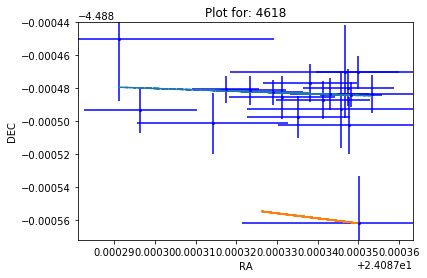

MU_RA -0.0237058763429


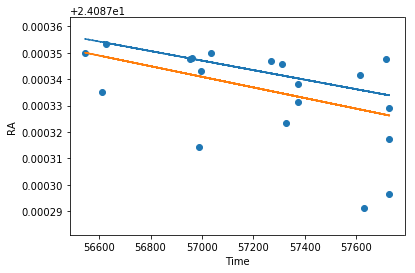

MU_DEC 0.00819100914851


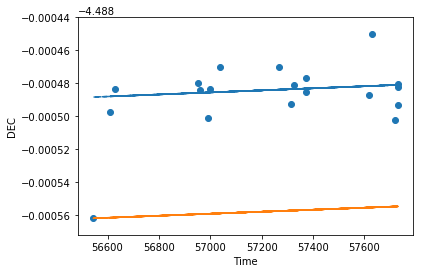

In [118]:
posOverTime(4618, fin)

1.13574457649


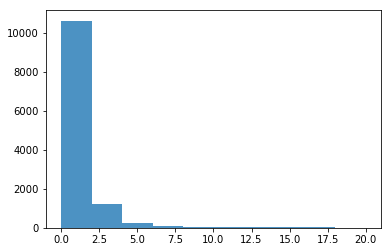

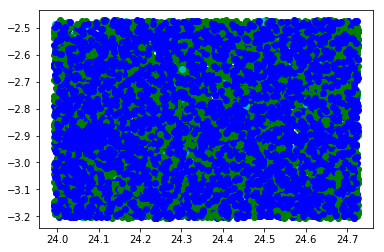

1.14659442157


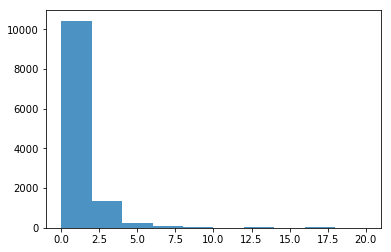

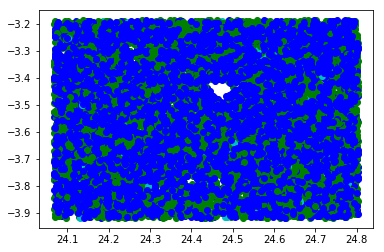

1.31055262426


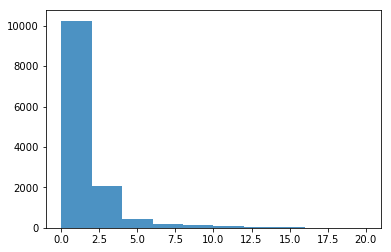

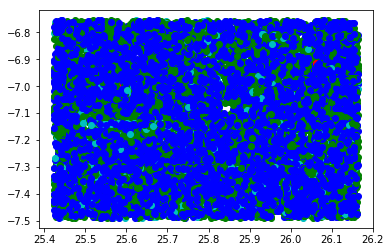

1.31758705307


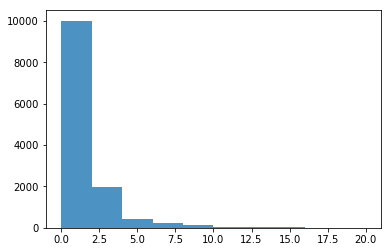

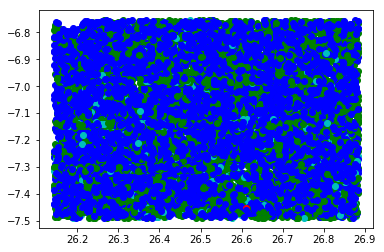

1.29662234528


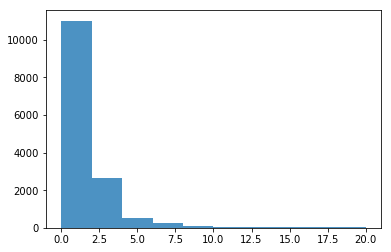

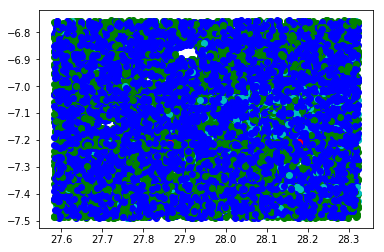

1.36206420914


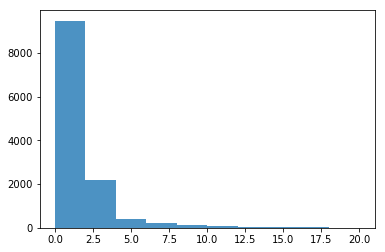

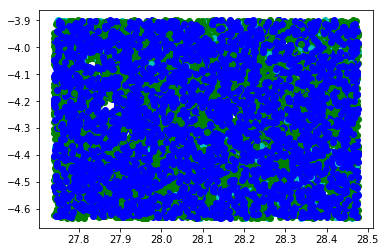

1.41129614532


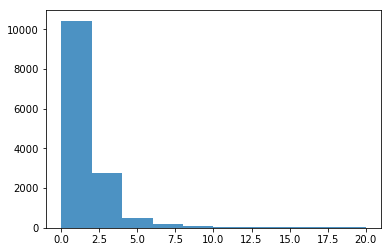

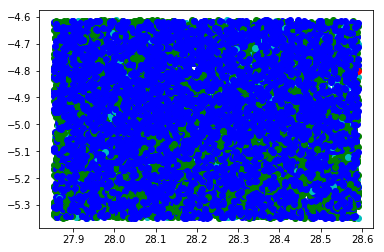

1.56789855732


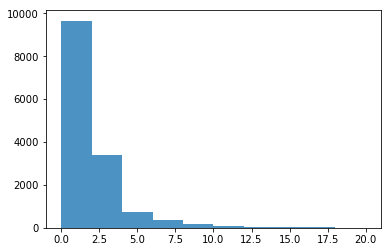

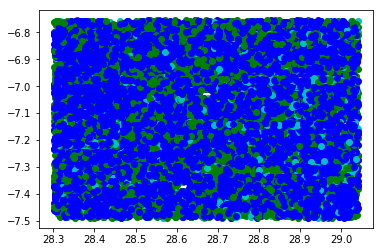

In [82]:
high_chi = [4, 5, 21, 28, 40, 42, 43, 47]
for i in high_chi:
    plt.hist(tiles_n[i]['CHI2_RED'], range = (0, 20), alpha = 0.8)
    print(median(tiles_n[i]['CHI2_RED']))
    plt.show()
    for row in tiles_n[i]:
        plt.plot(row['RA'], row['DEC'], colorPoint(row['CHI2_RED'], row['N'], row['DELTA_T']))
    plt.show()

1.14335433454


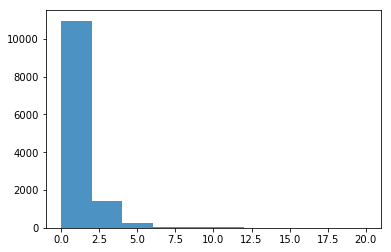

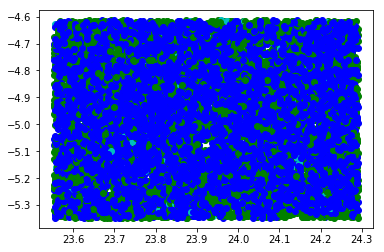

1.1486974009


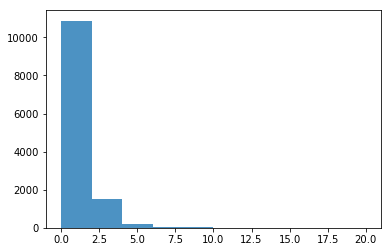

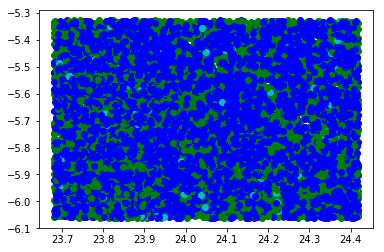

1.13254982297


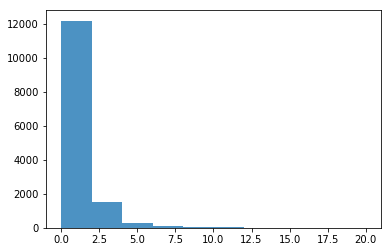

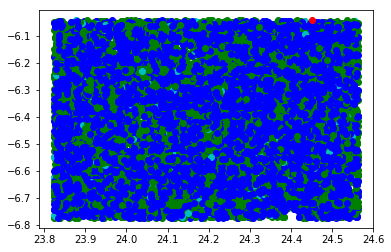

1.14180903594


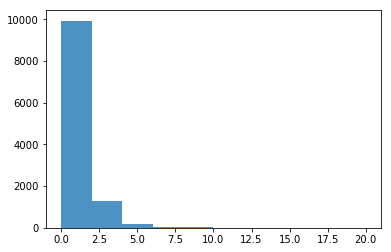

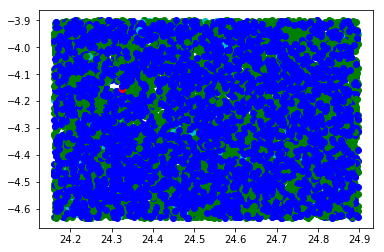

1.18543640208


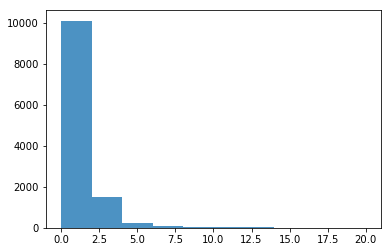

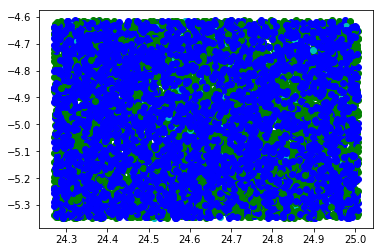

1.15128080191


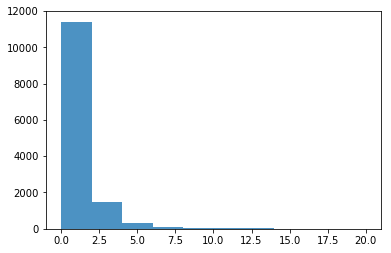

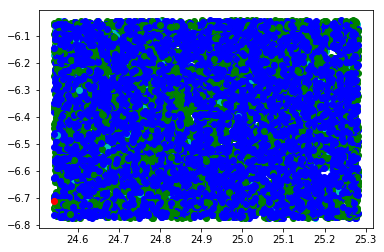

1.18031135079


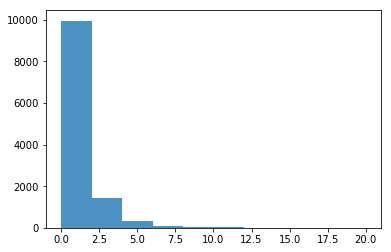

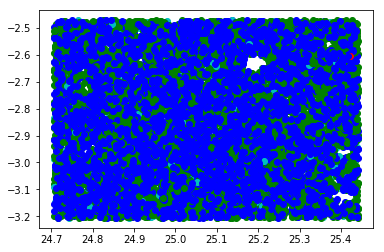

In [83]:
low_chi = [1, 2, 3, 7, 8, 10, 11]
for i in low_chi:
    plt.hist(tiles_n[i]['CHI2_RED'], range = (0, 20), alpha = 0.8)
    print(median(tiles_n[i]['CHI2_RED']))
    plt.show()
    for row in tiles_n[i]:
        plt.plot(row['RA'], row['DEC'], colorPoint(row['CHI2_RED'], row['N'], row['DELTA_T']))
    plt.show()

In [153]:
def residuals(match_id, final):
    pec = final[np.where(final['MATCH_ID'] == match_id)]
    pec2 = pec[np.where(pec['VERSION'] != 'COADD')]
    ra_1, dec_1 = calc_res(match_id, final, pec2['MJD_OBS'])
    #
    ts2 = theilslopes(pec2['NEW_RA'], pec2['MJD_OBS'])
    line2 = [ts2[0] * i + ts2[1] for i in pec2['MJD_OBS']]
    print('MU_RA', ts2[0] * 3600 *365.25)
    #plt.scatter(pec2['MJD_OBS'], pec2['NEW_RA'])
    #plt.plot(pec2['MJD_OBS'], line2, '--')
    ra_2 = np.array(pec2['NEW_RA']) + np.array(ra_1)
    plt.scatter(pec2['MJD_OBS'], ra_2)
    plt.ylim(min(pec2['NEW_RA']) - 10**-5, max(pec2['NEW_RA']) + 10**-5)
    plt.ylabel('RA')
    plt.xlabel('Time')
    #for i in pec2:
        #plt.text(i['MJD_OBS'], i['NEW_RA'], i['MJD_OBS'])
    plt.show()
    #
    ts3 = theilslopes(pec2['NEW_DEC'], pec2['MJD_OBS'])
    line3 = [ts3[0] * i + ts3[1] for i in pec2['MJD_OBS']]
    print('MU_DEC', ts3[0] * 3600 * 365.25)
    #plt.scatter(pec2['MJD_OBS'], pec2['NEW_DEC'])
    #plt.plot(pec2['MJD_OBS'], line3, '--')
    plt.scatter(pec2['MJD_OBS'], pec2['NEW_DEC'] + np.array(dec_1))
    plt.ylim(min(pec2['NEW_DEC']) - 10**-5, max(pec2['NEW_DEC']) + 10**-5)
    plt.ylabel('DEC')
    plt.xlabel('Time')
    plt.show()

In [163]:
def calc_res(match_id, final, mjd):
    pec = final[np.where(final['MATCH_ID'] == match_id)]
    pec2 = pec[np.where(pec['VERSION'] != 'COADD')]
    # get time range
    time0 = min(mjd)
    time_max = max(mjd)
    time = list(mjd)
    #time = np.linspace(np.ceil(time0), np.ceil(time_max), n = time_max - time0)
    # get mu_ra and mu_dec using match id
    pmra = tiles_n[0][np.where(tiles_n[0]['MATCH_ID'] == match_id)]['MU_RA'] / 3600
    pmdec = tiles_n[0][np.where(tiles_n[0]['MATCH_ID'] == match_id)]['MU_DEC'] / 3600
    # get earliest position
    ra0, dec0 = pec2[np.where(mjd == min(mjd))]['NEW_RA'], pec2[np.where(mjd == min(mjd))]['NEW_DEC']
    # ra and dec calc
    ra = []
    dec = []
    # calculate cumulative array
    for t in time:
        dt = (t - time0) / 365.25
        print(pmra)
        ra.append(-(pmra*dt).data[0])
        dec.append(-(pmdec*dt).data[0])
    return ra, dec

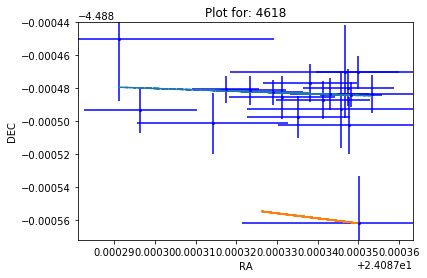

MU_RA -0.0237058763429


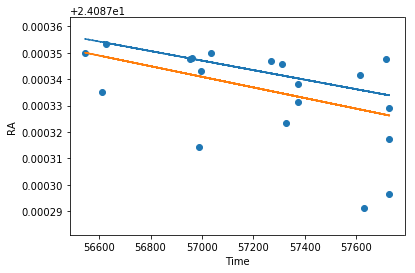

MU_DEC 0.00819100914851


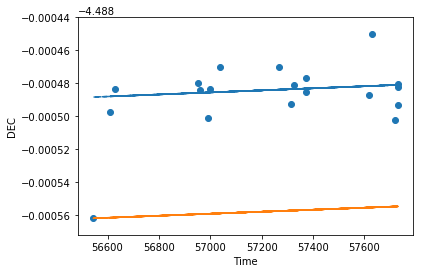

      MU_RA       
------------------
-7.33142683595e-06
      MU_RA       
------------------
-7.33142683595e-06
      MU_RA       
------------------
-7.33142683595e-06
      MU_RA       
------------------
-7.33142683595e-06
      MU_RA       
------------------
-7.33142683595e-06
      MU_RA       
------------------
-7.33142683595e-06
      MU_RA       
------------------
-7.33142683595e-06
      MU_RA       
------------------
-7.33142683595e-06
      MU_RA       
------------------
-7.33142683595e-06
      MU_RA       
------------------
-7.33142683595e-06
      MU_RA       
------------------
-7.33142683595e-06
      MU_RA       
------------------
-7.33142683595e-06
      MU_RA       
------------------
-7.33142683595e-06
      MU_RA       
------------------
-7.33142683595e-06
      MU_RA       
------------------
-7.33142683595e-06
      MU_RA       
------------------
-7.33142683595e-06
      MU_RA       
------------------
-7.33142683595e-06
      MU_RA       
------------

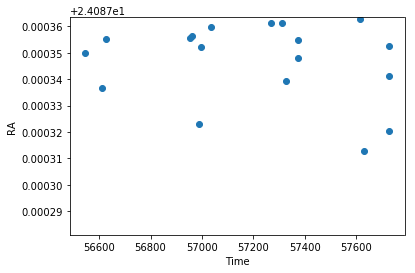

MU_DEC 0.00819100914851


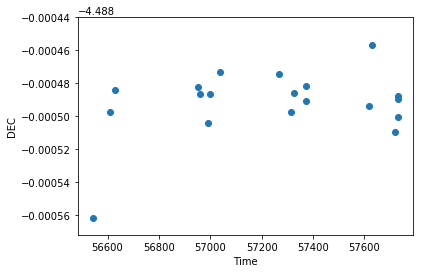

In [166]:
posOverTime(4618, fin)
residuals(4618, fin)

In [164]:
residuals(4148, fin)

MU_RA
-----


IndexError: index 0 is out of bounds for axis 0 with size 0